# Import Dataset

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/'EEG Dataset'/Latest

/content/gdrive/MyDrive/EEG Dataset/Latest


In [3]:
%ls

autoencoder_compress.png   Fold_1_Train_Dataset.csv  Fold_6_Test_Dataset.csv
boltzmann-machines/        Fold_2_Test_Dataset.csv   Fold_6_Train_Dataset.csv
dir/                       Fold_2_Train_Dataset.csv  Fold_7_Test_Dataset.csv
dir1/                      Fold_3_Test_Dataset.csv   Fold_7_Train_Dataset.csv
encoder_compress.png       Fold_3_Train_Dataset.csv  Fold_8_Test_Dataset.csv
encoder.h5                 Fold_4_Test_Dataset.csv   Fold_8_Train_Dataset.csv
Fold_10_Test_Dataset.csv   Fold_4_Train_Dataset.csv  Fold_9_Test_Dataset.csv
Fold_10_Train_Dataset.csv  Fold_5_Test_Dataset.csv   Fold_9_Train_Dataset.csv
Fold_1_Test_Dataset.csv    Fold_5_Train_Dataset.csv  my_dir/


# Import Libraries

In [4]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

In [6]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix

In [8]:
def confusionMatrix(cf_matrix):
  import numpy as np
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in 
                  cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.set(rc={'figure.figsize':(6,3)})
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

# User Model

In [9]:
def userModel(clf):
  clf.fit(df_trainX, df_trainY)
  df_pred = clf.predict(df_testX)
  confMatrix = confusion_matrix(df_testY, df_pred)
  acc = accuracy_score(df_testY,df_pred)
  f_measure = f1_score(df_testY,df_pred)
  print('Accuracy is:', acc)
  print('f-measure:', f_measure)
  print(classification_report(df_testY, df_pred))
  confusionMatrix(confMatrix)
  return acc, f_measure

# Plots

## Plot for each Subject 

In [10]:
def barPlot(accuracies, title, xname):
  sns.set_style(style='white')
  models = ['SVM', 'Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Boosting Trees']
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.set_title(title, size=17)
  ax.set(ylim=(0, 1.1))
  plots = sns.barplot(models, accuracies)
  plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='x-large')
  sns.set(rc={'figure.figsize':(11.7,8.27)})
  for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                    (bar.get_x() + bar.get_width() / 2,
                      bar.get_height()), ha='center', va='center',
                    size=15, xytext=(0, 8),
                    textcoords='offset points')
  plt.ylabel(xname, size=15)
  plt.xlabel('Models', size=15)
  plt.show()

## Plot for best accuracy for each Subject

In [11]:
def barPlotBestAccuracy(xVals, accuracies, title, xLabel):
  fig = plt.figure()
  sns.set(rc={'figure.figsize':(11.7,8.27)})
  ax = fig.add_axes([0,0,1,1])
  ax.set_title(title, size=17)
  ax.set(ylim=(0, 1))
  plots = sns.barplot(xVals, accuracies)
  plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='x-large')
  for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                    (bar.get_x() + bar.get_width() / 2,
                      bar.get_height()), ha='center', va='center',
                    size=15, xytext=(0, 8),
                    textcoords='offset points')
  plt.ylabel('Accuracy', size=15)
  plt.xlabel(xLabel, size=15)
  plt.show()

## Master Bar Plot

In [610]:
def masterBarPlot(df, title):
  sns.set_style(style='white')
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.set_title(title, size=17)
  ax.set(ylim=(0, 1))
  plots = sns.barplot(x='Subject', y='Accuracies', hue='Voting', data=df)
  sns.set(rc={'figure.figsize':(11.7,8.27)})
  plots.legend(bbox_to_anchor= (1,0.5))
  plt.setp(plots.get_legend().get_texts(), fontsize='10') 
  plt.ylabel('Accuracy', size=15)
  plt.xlabel('Subject', size=15)
  plt.show()

# Get Dataset

In [12]:
def getDataset(i):
  train_str = 'Fold_' + str(i) + '_Train_Dataset.csv'
  test_str = 'Fold_' + str(i) + '_Test_Dataset.csv'

  df_train = pd.read_csv(train_str, header=None) 
  df_test = pd.read_csv(test_str, header=None)

  return df_train, df_test

# Master Train Validation Dataset

In [13]:
def createMasterTrainVal(ind):
  df_train, df_val = dict(), dict()
  for i in range(1, 11):
    if i == ind:
      continue
    df_train_master = getDataset(1)[1][0:0]
    for j in range(1, 11):
      if j == i or j == ind:
        continue
      else:
        _, df_test_te = getDataset(j)
        df_train_master = pd.concat([df_train_master, df_test_te], ignore_index=True)
    df_train[i] = df_train_master
    _, df_val[i] = getDataset(i)
  return df_train, df_val

In [14]:
def getTrainValXY(i, df_train_master, df_val_master):
  df_train = df_train_master[i]
  df_val = df_val_master[i]

  df_trainX = df_train.iloc[:,:-1]
  df_trainY = df_train.iloc[:,-1]
  df_valX = df_val.iloc[:,:-1]
  df_valY = df_val.iloc[:,-1]

  df_trainY[df_trainY==1] = 0
  df_trainY[df_trainY==2] = 1
  df_valY[df_valY==1] = 0
  df_valY[df_valY==2] = 1

  return df_trainX, df_trainY, df_valX, df_valY

In [15]:
def getMasterTrainValXY(ind, df_train_master, df_val_master):
  df_trainX_master, df_trainY_master, df_valX_master, df_valY_master = dict(), dict(), dict(), dict()
  for i in range(1, 11):
    if i == ind:
      continue
    else:
      df_trainX_master[i], df_trainY_master[i], df_valX_master[i], df_valY_master[i] = getTrainValXY(i, df_train_master, df_val_master)
  return df_trainX_master, df_trainY_master, df_valX_master, df_valY_master

# Model Tuning

In [16]:
def userModelTuning(ind, clf, df_trainX_te, df_trainY_te, df_valX_te, df_valY_te):
  acc = 0
  f_measure = 0
  n = len(df_trainX_te)
  for i in range(1, n+1):
    if i == ind:
      continue
    df_trainX, df_trainY, df_valX, df_valY = df_trainX_te[i], df_trainY_te[i], df_valX_te[i], df_valY_te[i] 
    clf.fit(df_trainX, df_trainY)
    pred = clf.predict(df_valX)
    acc += accuracy_score(df_valY, pred)
    f_measure += f1_score(df_valY, pred)
  return acc/float(n), f_measure/float(n)

# Hyperparameter Tuning

In [17]:
def getMaxFStr(check):
  f = 0
  s = ''
  f_measure, acc = 0, 0
  for i in check:
    if f == 0 or check[i][0] > f_measure:
      f = 1
      s = i
      f_measure, acc = check[i]
  return s      

## SVM

In [18]:
def hyperparameterSearchSVM(ind):

  C = [0.1, 1, 10, 100, 1000]  
  gamma = [1, 0.1, 0.01, 0.001, 0.0001] 
  check = dict()
  for i in range(len(C)):
    for j in range(len(gamma)):
      print("Iteration", i*len(gamma)+j+1, 'C =', C[i], 'gamma =', gamma[j])
      svmClf = svm.SVC(C = C[i], gamma = gamma[j], kernel='rbf')
      svmClfAcc, svmClfF = userModelTuning(ind, svmClf, df_trainX_master, df_trainY_master, df_valX_master, df_valY_master)
      s = str(C[i]) + str(gamma[j])
      print('Accuracy is:', svmClfAcc)
      print('F-measure:', svmClfF)
      print()
      check[s] = (svmClfF, svmClfAcc)
  ind = getMaxFStr(check)
  print(ind, check[ind])
  return check

## Logistic Regression

In [19]:
def hyperparameterSearchLR(ind):

  penalty = ['l2', 'l1']
  C = np.logspace(-4, 4, 20)
  solver = ['liblinear']
  fit_intercept = [True, False]

  import random
  random.seed(42)
  check = dict()
  i = 0
  while i<80:
    penalty_val = penalty[random.randint(0, len(penalty)-1)]
    C_val = C[random.randint(0, len(C)-1)]
    solver_val = solver[random.randint(0, len(solver)-1)]
    fit_intercept_val = fit_intercept[random.randint(0, len(fit_intercept)-1)]
    indexVal = str(penalty_val) + str(C_val) + str(solver_val) + str(fit_intercept_val)
    if check.get(indexVal):
      continue
    else:
      # print('Iteration', i+1)
      # print(indexVal)
      lr = LogisticRegression(penalty = penalty_val, C = C_val, solver = solver_val, fit_intercept = fit_intercept_val)
      lra, lrf =  userModelTuning(ind, lr, df_trainX_master, df_trainY_master, df_valX_master, df_valY_master)
      # print('Accuracy is:', lra)
      # print()
      i+=1
      check[indexVal] = (lrf, lra)
      # print()
  ind = getMaxFStr(check)
  print(ind, check[ind])
  return check

## KNN

In [20]:
def getVal(x, random):
  val = x[random.randint(0, len(x)-1)]
  return val

In [21]:
def hyperparameterSearchKNN(ind):

  n_neighbors = [5, 10, 20, 40, 80, 160]
  weights = ['uniform', 'distance']
  algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
  leaf_size = [15, 30, 45, 60, 75, 100]
  p = [1, 2]

  import random
  random.seed(42)
  check = dict()
  i = 0
  while i<150:
    n_neighbors_val = getVal(n_neighbors, random)
    weights_val = getVal(weights, random)
    algorithm_val = getVal(algorithm, random)
    leaf_size_val = getVal(leaf_size, random)
    p_val = getVal(p, random)

    indexVal = str(n_neighbors_val) + str(weights_val) + str(algorithm_val) + str(leaf_size_val) + str(p_val)
    if check.get(indexVal):
      continue
    else:
      # print('Iteration', i+1)
      # print(indexVal)
      knnClf = KNeighborsClassifier(n_neighbors = n_neighbors_val, weights = weights_val, algorithm = algorithm_val, 
                                    leaf_size = leaf_size_val, p = p_val)
      knnClfa, knnClfF = userModelTuning(ind, knnClf, df_trainX_master, df_trainY_master, df_valX_master, df_valY_master)
      # print('Accuracy is:', knnClfa)
      # print()
      i+=1
      check[indexVal] = (knnClfF, knnClfa)
      
      # print()
  ind = getMaxFStr(check)
  print(ind, check[ind])
  return check

## Decision Tree

In [22]:
def hyperparameterSearchDecisionTree(ind):

  criterion = ['gini', 'entropy']
  max_features = ["auto","log2","sqrt",None]
  max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
  max_depth.append(None)
  min_samples_split = [2, 5, 10]
  min_samples_leaf = [1,2,3,4,5,6,7,8,9,10]
  max_leaf_nodes = [None,10,20,30,40,50,60,70,80,90]
  min_weight_fraction_leaf = [0.1,0.2,0.3,0.4,0.5]
  splitter = ['random', 'best']

  import random
  random.seed(42)
  check = dict()
  i = 0
  while i<150:
    criterion_val = criterion[random.randint(0, len(criterion)-1)]
    max_features_val = max_features[random.randint(0, len(max_features)-1)]
    max_depth_val = max_depth[random.randint(0, len(max_depth)-1)]
    min_samples_split_val = min_samples_split[random.randint(0, len(min_samples_split)-1)]
    min_samples_leaf_val = min_samples_leaf[random.randint(0, len(min_samples_leaf)-1)]
    max_leaf_nodes_val = max_leaf_nodes[random.randint(0, len(max_leaf_nodes)-1)]
    min_weight_fraction_leaf_val = min_weight_fraction_leaf[random.randint(0, len(min_weight_fraction_leaf)-1)]
    splitter_val = splitter[random.randint(0, len(splitter)-1)]

    indexVal = str(criterion_val) + str(max_features_val) + str(max_depth_val) + str(min_samples_split_val) + str(min_samples_leaf_val) + str(max_leaf_nodes_val) + str(min_weight_fraction_leaf_val) + str(splitter_val)
    if check.get(indexVal):
      continue
    else:
      # print('Iteration', i+1)
      # print(indexVal)
      dtc = DecisionTreeClassifier(max_features = max_features_val, max_depth = max_depth_val, 
                                  min_samples_split = min_samples_split_val, min_samples_leaf = min_samples_leaf_val, 
                                  max_leaf_nodes = max_leaf_nodes_val, min_weight_fraction_leaf = min_weight_fraction_leaf_val)
      dtca, dtcF = userModelTuning(ind, dtc, df_trainX_master, df_trainY_master, df_valX_master, df_valY_master)
      # print('Accuracy is:', dtca)
      # print()
      i+=1
      check[indexVal] = (dtcF, dtca)
      # print()
  
  ind = getMaxFStr(check)
  print(ind, check[ind])
  return check

## Random Forest

In [23]:
def hyperparameterSearchRandomForest(ind):

  # Number of trees in random forest
  n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
  # Number of features to consider at every split
  max_features = ['auto', 'sqrt', 'log2']
  # Maximum number of levels in tree
  max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
  max_depth.append(None)
  # Minimum number of samples required to split a node
  min_samples_split = [2, 5, 10]
  # Minimum number of samples required at each leaf node
  min_samples_leaf = [1, 2, 4]
  # Method of selecting samples for training each tree
  bootstrap = [True, False]

  import random
  random.seed(42)
  check = dict()
  i = 0
  while i<20:
    n_estimators_val = n_estimators[random.randint(0, len(n_estimators)-1)]
    max_features_val = max_features[random.randint(0, len(max_features)-1)]
    max_depth_val = max_depth[random.randint(0, len(max_depth)-1)]
    min_samples_split_val = min_samples_split[random.randint(0, len(min_samples_split)-1)]
    min_samples_leaf_val = min_samples_leaf[random.randint(0, len(min_samples_leaf)-1)]
    bootstrap_val = bootstrap[random.randint(0, len(bootstrap)-1)]
    indexVal = str(n_estimators_val) + str(max_features_val) + str(max_depth_val) + str(min_samples_split_val) + str(min_samples_leaf_val) + str(bootstrap_val)
    if check.get(indexVal):
      continue
    else:
      # print('Iteration', i+1)
      # print(indexVal)
      rfc = RandomForestClassifier(n_estimators = n_estimators_val, max_features = max_features_val, max_depth = max_depth_val, 
                                  min_samples_split = min_samples_split_val, min_samples_leaf = min_samples_leaf_val, 
                                  bootstrap = bootstrap_val)
      rfca, rfcF = userModelTuning(ind, rfc, df_trainX_master, df_trainY_master, df_valX_master, df_valY_master)
      # print('Accuracy is:', rfca)
      # print()
      i+=1
      check[indexVal] = (rfcF, rfca)
      # print()

  ind = getMaxFStr(check)
  print(ind, check[ind])
  return check

## Boosting Trees

In [24]:
def hyperparameterSearchXgb(ind):
  n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
  max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
  learning_rate = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
  gamma = [i/10.0 for i in range(0,5)]
  # min_child_weight = [1, 2, 3, 4, 5, 6]
  subsample = [i/10.0 for i in range(6,10)]
  colsample_bytree = [i/10.0 for i in range(6,10)]
  reg_alpha = [1e-5, 1e-2, 0.1, 1, 100]

  import xgboost as xgb
  import random
  random.seed(42)
  check = dict()
  i = 0
  while i<40:
    n_estimators_val = getVal(n_estimators, random)
    max_depth_val = getVal(max_depth, random)
    learning_rate_val = getVal(learning_rate, random)
    gamma_val = getVal(gamma, random)
    # min_child_weight_val = getVal(min_child_weight, random)
    subsample_val = getVal(subsample, random)
    colsample_bytree_val = getVal(colsample_bytree, random)
    reg_alpha_val = getVal(reg_alpha, random)

    indexVal = str(n_estimators_val) + str(max_depth_val) + str(learning_rate_val) + str(gamma_val) + str(subsample_val) + str(colsample_bytree_val) + str(reg_alpha_val)
    if check.get(indexVal):
      continue
    else:
      # print('Iteration', i+1)
      # print(indexVal)
      xgbClf = xgb.XGBClassifier(n_estimators = n_estimators_val, max_depth = max_depth_val, learning_rate = learning_rate_val, 
                              gamma = gamma_val, subsample = subsample_val,
                              colsample_bytree = colsample_bytree_val, reg_alpha = reg_alpha_val)
      xgbClfa, xgbClfF = userModelTuning(ind, xgbClf, df_trainX_master, df_trainY_master, df_valX_master, df_valY_master)
      # print('Accuracy is:', xgbClfa)
      # print()
      i+=1
      check[indexVal] = (xgbClfF, xgbClfa)
      # print()

  ind = getMaxFStr(check)
  print(ind, check[ind])
  return check

# Voting

## Weighted Voting

In [29]:
def WeightedVotingClassification(clf_list, weight_list):
 
  w = np.array(weight_list)
  total = float(np.sum(w))
  w = w/total
  
  n = len(clf_list)
  pred = np.array([0.0 for i in range(len(df_testY))])
  
  for i in range(n):
    clf = clf_list[i]
    clf.fit(df_trainX, df_trainY)

    df_pred_prob = clf.predict_proba(df_testX)[:, 1]
    pred = pred + w[i] * df_pred_prob
  
  pred[pred>=0.5] = 1
  pred[pred<0.5] = 0
  return pred

## Majority Voting

In [30]:
def MajorityVotingClassification(clf_list):
 
  n = len(clf_list)
  master_pred = []

  for i in range(n):
    clf = clf_list[i]
    clf.fit(df_trainX, df_trainY)
    pred = np.array(clf.predict(df_testX))
    master_pred.append(pred)
    
  master_pred = np.array(master_pred)
  pred = np.sum(master_pred, axis=0)
  threshold = n//2
  pred[pred<=threshold] = 0
  pred[pred>threshold] = 1
  return pred

## Unanimous Voting

In [31]:
def UnanimousVotingClassification(clf_list):
 
  n = len(clf_list)
  master_pred = []

  for i in range(n):
    clf = clf_list[i]
    clf.fit(df_trainX, df_trainY)
    pred = np.array(clf.predict(df_testX))
    master_pred.append(pred)
    
  master_pred = np.array(master_pred)
  pred = np.min(master_pred, axis=0)
  return pred

# Fold 1

In [291]:
df_train = pd.read_csv('Fold_1_Train_Dataset.csv', header=None) 
df_test = pd.read_csv('Fold_1_Test_Dataset.csv', header=None)

df_trainX = df_train.iloc[:,:-1]
df_trainY = df_train.iloc[:,-1]
df_testX = df_test.iloc[:,:-1]
df_testY = df_test.iloc[:,-1]

df_trainY[df_trainY==1] = 0
df_trainY[df_trainY==2] = 1
df_testY[df_testY==1] = 0
df_testY[df_testY==2] = 1

## Train Validation Sets

In [292]:
df_train_master, df_val_master = createMasterTrainVal(1)
df_trainX_master, df_trainY_master, df_valX_master, df_valY_master = getMasterTrainValXY(1, df_train_master, df_val_master)

## Hyperparameter Tuning

### SVM

In [ ]:
hyperparameterSearchSVM(1)

Iteration 1 C = 0.1 gamma = 1
Accuracy is: 0.5333333333333333
F-measure: 0.29970976681503

Iteration 2 C = 0.1 gamma = 0.1
Accuracy is: 0.48888888888888893
F-measure: 0.3961768682804429

Iteration 3 C = 0.1 gamma = 0.01
Accuracy is: 0.4592592592592592
F-measure: 0.5463847088420222

Iteration 4 C = 0.1 gamma = 0.001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 5 C = 0.1 gamma = 0.0001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 6 C = 1 gamma = 1
Accuracy is: 0.701851851851852
F-measure: 0.5712255029516361

Iteration 7 C = 1 gamma = 0.1
Accuracy is: 0.6444444444444444
F-measure: 0.5884548401205619

Iteration 8 C = 1 gamma = 0.01
Accuracy is: 0.5370370370370371
F-measure: 0.5805439297195796

Iteration 9 C = 1 gamma = 0.001
Accuracy is: 0.4462962962962963
F-measure: 0.5409576848166542

Iteration 10 C = 1 gamma = 0.0001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 11 C = 10 gamma = 1
Accuracy is: 0.7907407407407409
F-measure: 0.7530885473146804

Itera

{'0.10.0001': (0.0, 0.4444444444444444),
 '0.10.001': (0.0, 0.4444444444444444),
 '0.10.01': (0.5463847088420222, 0.4592592592592592),
 '0.10.1': (0.3961768682804429, 0.48888888888888893),
 '0.11': (0.29970976681503, 0.5333333333333333),
 '10.0001': (0.0, 0.4444444444444444),
 '10.001': (0.5409576848166542, 0.4462962962962963),
 '10.01': (0.5805439297195796, 0.5370370370370371),
 '10.1': (0.5884548401205619, 0.6444444444444444),
 '100.0001': (0.0, 0.3907407407407407),
 '100.001': (0.5108909166812325, 0.4833333333333334),
 '100.01': (0.40549622321886636, 0.5296296296296297),
 '100.1': (0.5338236592487294, 0.6444444444444444),
 '1000.0001': (0.46071910152643547, 0.47777777777777775),
 '1000.001': (0.4809425440603233, 0.5296296296296297),
 '1000.01': (0.5109891916022818, 0.6018518518518517),
 '1000.1': (0.631771961008133, 0.711111111111111),
 '10000.0001': (0.4976702130158059, 0.5537037037037037),
 '10000.001': (0.5739580266627248, 0.6018518518518517),
 '10000.01': (0.5293633072035042, 0.

### Logistic Regression

In [ ]:
hyperparameterSearchLR(1)

l20.615848211066026liblinearFalse (0.48905185460194406, 0.5333333333333333)


{'l10.0001liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0001liblinearTrue': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearFalse': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearTrue': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearFalse': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearTrue': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearFalse': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearTrue': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearFalse': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearTrue': (0.0, 0.4444444444444444),
 'l10.08858667904100823liblinearFalse': (0.21978292432689295,
  0.34629629629

### KNN

In [ ]:
hyperparameterSearchKNN(1)

10distancekd_tree302 (0.8205756137823741, 0.8148148148148149)


{'10distanceauto1001': (0.7334709089421816, 0.7648148148148148),
 '10distanceauto152': (0.8144481628019818, 0.8074074074074075),
 '10distanceauto602': (0.8144481628019818, 0.8074074074074075),
 '10distanceball_tree152': (0.8174654362318982, 0.8111111111111113),
 '10distanceball_tree452': (0.8205756137823741, 0.8148148148148149),
 '10distancebrute1001': (0.7334709089421816, 0.7648148148148148),
 '10distancebrute451': (0.7334709089421816, 0.7648148148148148),
 '10distancebrute751': (0.7334709089421816, 0.7648148148148148),
 '10distancebrute752': (0.8144481628019818, 0.8074074074074075),
 '10distancekd_tree302': (0.8205756137823741, 0.8148148148148149),
 '10uniformauto1001': (0.13320194883662376, 0.42962962962962964),
 '10uniformauto1002': (0.3824973157790495, 0.5703703703703704),
 '10uniformauto152': (0.3824973157790495, 0.5703703703703704),
 '10uniformauto451': (0.13320194883662376, 0.42962962962962964),
 '10uniformball_tree1001': (0.21937919751387244, 0.47962962962962963),
 '10uniformb

### Decision Tree

In [ ]:
hyperparameterSearchDecisionTree(1)

giniauto7052900.1random (0.616057089309929, 0.6759259259259259)


{'entropyNone1025300.4random': (0.151395820115296, 0.3555555555555555),
 'entropyNone1029500.5best': (0.0, 0.4444444444444444),
 'entropyNone20106900.3random': (0.256712962962963, 0.46481481481481485),
 'entropyNone2024100.3random': (0.256712962962963, 0.46481481481481485),
 'entropyNone3059700.3best': (0.256712962962963, 0.46481481481481485),
 'entropyNone40510900.4best': (0.151395820115296, 0.3555555555555555),
 'entropyNone5027700.1random': (0.4834083656942002, 0.6314814814814815),
 'entropyNone5028None0.5random': (0.0, 0.4444444444444444),
 'entropyNone5055300.1random': (0.4834083656942002, 0.6314814814814815),
 'entropyNone60109600.5random': (0.0, 0.4444444444444444),
 'entropyNone6024900.4random': (0.151395820115296, 0.3555555555555555),
 'entropyNone6028500.3best': (0.256712962962963, 0.46481481481481485),
 'entropyNone7051100.1best': (0.4834083656942002, 0.6314814814814815),
 'entropyNone80104800.4random': (0.151395820115296, 0.3555555555555555),
 'entropyNone80510600.3random':

### Random Forest

In [ ]:
hyperparameterSearchRandomForest(1)

200autoNone52False (0.7706862418837475, 0.8111111111111112)


{'1000auto40104False': (0.7706862418837475, 0.8111111111111112),
 '1200auto4022False': (0.7706862418837475, 0.8111111111111112),
 '1600log22051False': (0.7672700669643996, 0.8074074074074075),
 '1800sqrt4054False': (0.7689235061178388, 0.8092592592592593),
 '2000sqrt10024True': (0.7672700669643996, 0.8074074074074075),
 '2000sqrt10052True': (0.7689235061178388, 0.8092592592592593),
 '2000sqrt1021True': (0.7689235061178388, 0.8092592592592593),
 '200autoNone52False': (0.7706862418837475, 0.8111111111111112),
 '200log24051True': (0.7654539944516058, 0.8055555555555557),
 '400autoNone51True': (0.7672700669643996, 0.8074074074074075),
 '400log211024True': (0.7672700669643996, 0.8074074074074075),
 '400sqrt5054False': (0.7689235061178388, 0.8092592592592593),
 '400sqrt60102True': (0.7672700669643996, 0.8074074074074075),
 '600auto6021False': (0.7672700669643996, 0.8074074074074075),
 '600log220104True': (0.6793510283812244, 0.7592592592592593),
 '600sqrt3024False': (0.7689235061178388, 0.80

### Xgboost

In [ ]:
hyperparameterSearchXgb(1)

1200800.30.00.70.71e-05 (0.8631967661267915, 0.8629629629629629)


{'10001100.030.00.80.90.01': (0.7741651287080574, 0.8148148148148149),
 '1000300.0030.20.60.61': (0.6775976677733927, 0.7574074074074075),
 '1000300.0030.40.80.9100': (0.0, 0.4444444444444444),
 '1000400.00010.10.60.61': (0.5685661384564082, 0.701851851851852),
 '1200100.0030.40.70.61e-05': (0.7689328812759157, 0.8092592592592593),
 '1200200.0030.10.70.90.01': (0.7656768780199125, 0.8055555555555557),
 '1200400.010.00.70.70.01': (0.7741651287080574, 0.8148148148148149),
 '1200800.30.00.70.71e-05': (0.8631967661267915, 0.8629629629629629),
 '1400300.010.30.70.61': (0.7724023929421487, 0.812962962962963),
 '1400600.0030.10.90.61e-05': (0.7689328812759157, 0.8092592592592593),
 '1400700.30.00.60.61': (0.7758719046083817, 0.8166666666666668),
 '1400900.30.10.70.80.01': (0.851025495362184, 0.8500000000000001),
 '1600100.010.40.70.60.1': (0.7724702134538202, 0.812962962962963),
 '16001000.010.00.70.90.1': (0.7741651287080574, 0.8148148148148149),
 '1600700.0030.00.60.90.1': (0.77063965717624

## SVM

Accuracy is: 0.4166666666666667
f-measure: 0.14634146341463417
              precision    recall  f1-score   support

           0       0.45      0.73      0.56        30
           1       0.27      0.10      0.15        30

    accuracy                           0.42        60
   macro avg       0.36      0.42      0.35        60
weighted avg       0.36      0.42      0.35        60



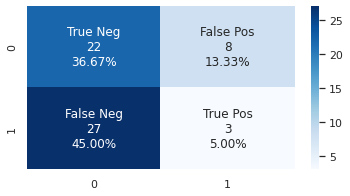

In [293]:
svmClfValF = 0.8267606549975114
svmClfValAcc = 0.8222222222222224
svmClf = svm.SVC(C = 1000, gamma = 0.1, kernel='rbf', probability=True)
svmClfAcc, svmClfF = userModel(svmClf)

## Logistic Regression

Accuracy is: 0.75
f-measure: 0.8
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        30
           1       0.67      1.00      0.80        30

    accuracy                           0.75        60
   macro avg       0.83      0.75      0.73        60
weighted avg       0.83      0.75      0.73        60



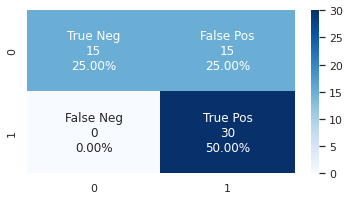

In [294]:
lrValF = 0.48905185460194406
lrValAcc = 0.5333333333333333
lr = LogisticRegression(penalty='l2', C=0.615848211066026, solver='liblinear', fit_intercept=False)
lrAcc, lrF = userModel(lr)

## KNN

Accuracy is: 0.43333333333333335
f-measure: 0.15
              precision    recall  f1-score   support

           0       0.46      0.77      0.57        30
           1       0.30      0.10      0.15        30

    accuracy                           0.43        60
   macro avg       0.38      0.43      0.36        60
weighted avg       0.38      0.43      0.36        60



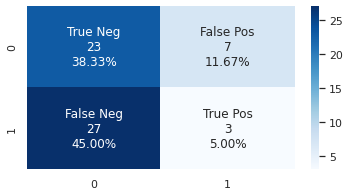

In [295]:
knnValF = 0.8205756137823741
knnValAcc = 0.8148148148148149
knn = KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='kd_tree', leaf_size=30, p=2)
knnAcc, knnF = userModel(knn)

## Decision Tree

Accuracy is: 0.5
f-measure: 0.0
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        30
           1       0.00      0.00      0.00        30

    accuracy                           0.50        60
   macro avg       0.25      0.50      0.33        60
weighted avg       0.25      0.50      0.33        60



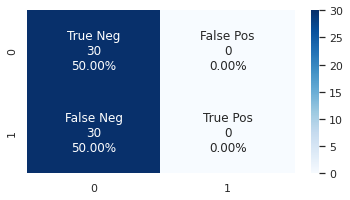

In [296]:
dtValF = 0.616057089309929
dtValAcc = 0.6759259259259259
dt = DecisionTreeClassifier(criterion='gini', max_features='auto', max_depth=70, min_samples_split=5, min_samples_leaf=2, 
                            max_leaf_nodes=90, min_weight_fraction_leaf=0.1, splitter='random')
dtAcc, dtF = userModel(dt)

## Random Forest

Accuracy is: 0.55
f-measure: 0.18181818181818182
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        30
           1       1.00      0.10      0.18        30

    accuracy                           0.55        60
   macro avg       0.76      0.55      0.44        60
weighted avg       0.76      0.55      0.44        60



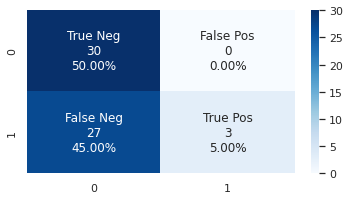

In [297]:
rfValF = 0.7706862418837475
rfValAcc = 0.8111111111111112
rf = RandomForestClassifier(n_estimators=200, max_features='auto', max_depth=None, min_samples_split=5, min_samples_leaf=2, bootstrap=False)
rfAcc, rfF = userModel(rf)

## Boosting

Accuracy is: 0.55
f-measure: 0.18181818181818182
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        30
           1       1.00      0.10      0.18        30

    accuracy                           0.55        60
   macro avg       0.76      0.55      0.44        60
weighted avg       0.76      0.55      0.44        60



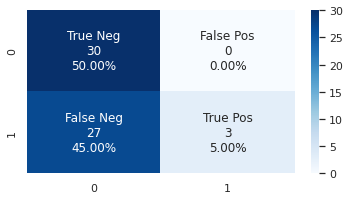

In [298]:
xgbClfValF = 0.8631967661267915
xgbClfValAcc = 0.8629629629629629
xgbClf = xgb.XGBClassifier(n_estimators=1200, max_depth=80, learning_rate=0.3, gamma=0, subsample=0.7, colsample_bytree=0.7,  
                           reg_alpha=1e-05)
xgbClfAcc, xgbClfF = userModel(xgbClf)

## Plots

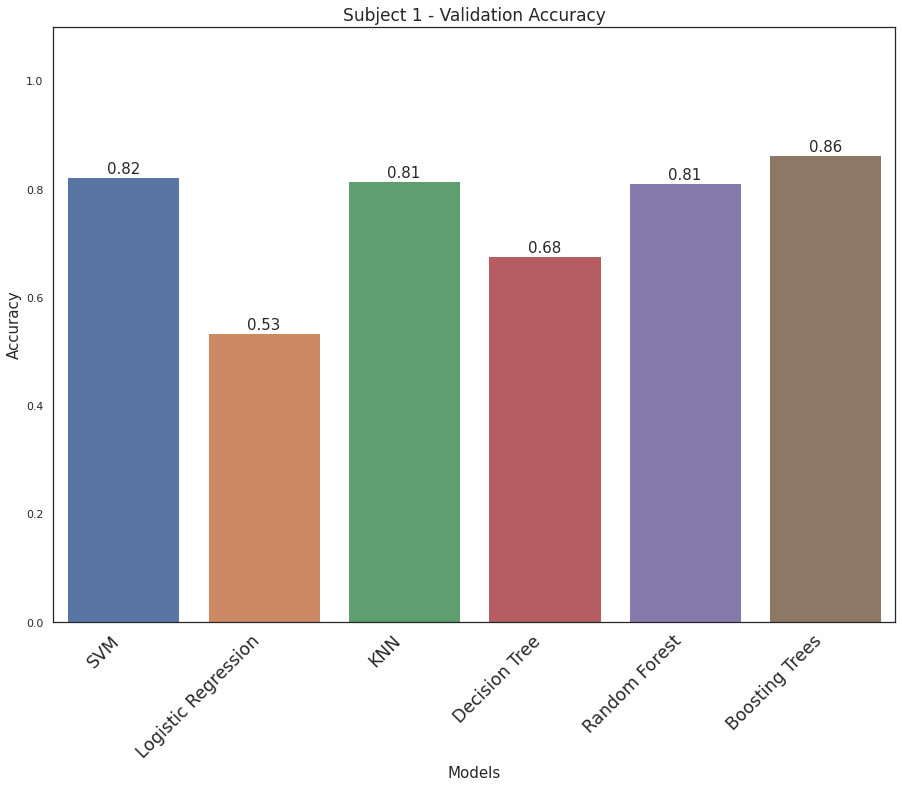

In [300]:
accuracies = [svmClfValAcc, lrValAcc, knnValAcc, dtValAcc, rfValAcc, xgbClfValAcc]
barPlot(accuracies, 'Subject 1 - Validation Accuracy', 'Accuracy')

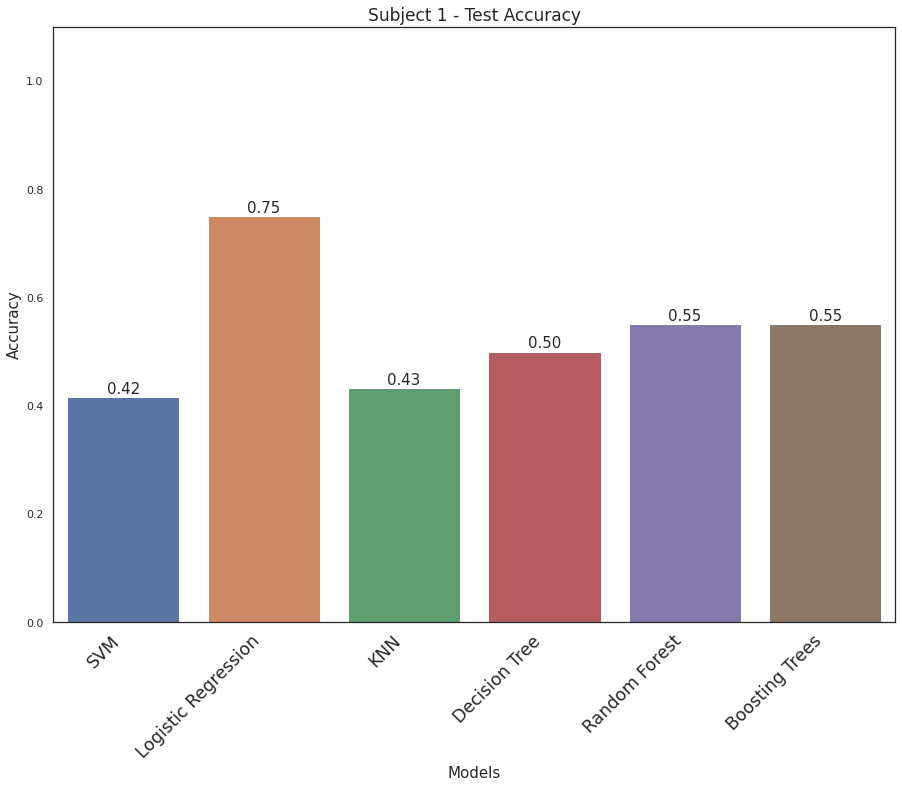

In [301]:
accuracies = [svmClfAcc, lrAcc, knnAcc, dtAcc, rfAcc, xgbClfAcc]
barPlot(accuracies, 'Subject 1 - Test Accuracy', 'Accuracy')

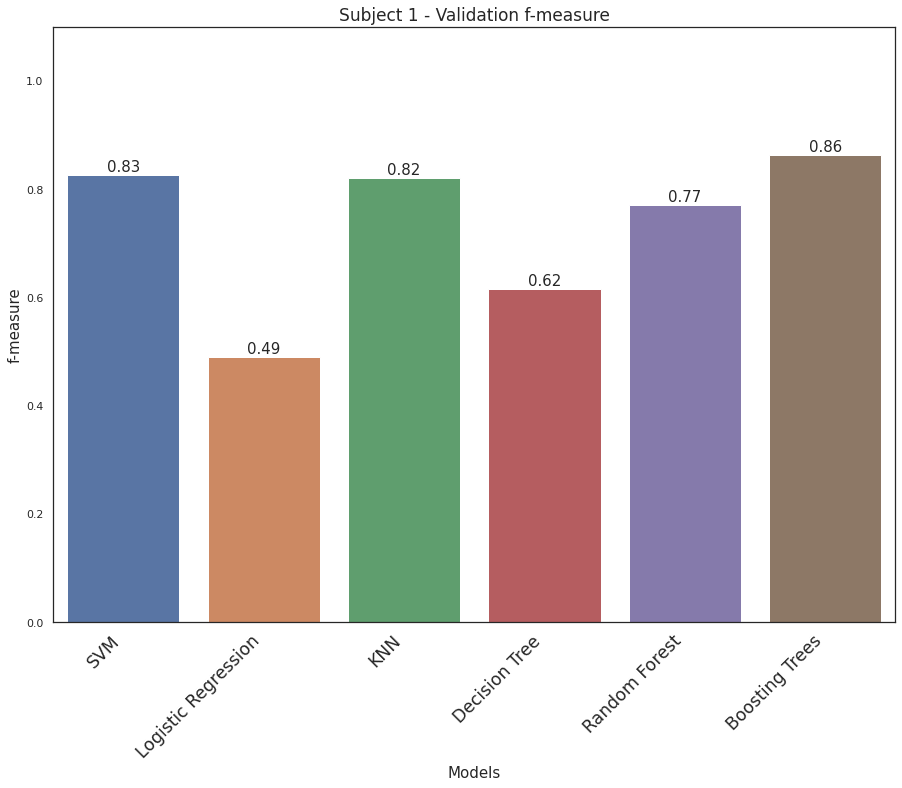

In [302]:
f_measure = [svmClfValF, lrValF, knnValF, dtValF, rfValF, xgbClfValF]
barPlot(f_measure, 'Subject 1 - Validation f-measure', 'f-measure')

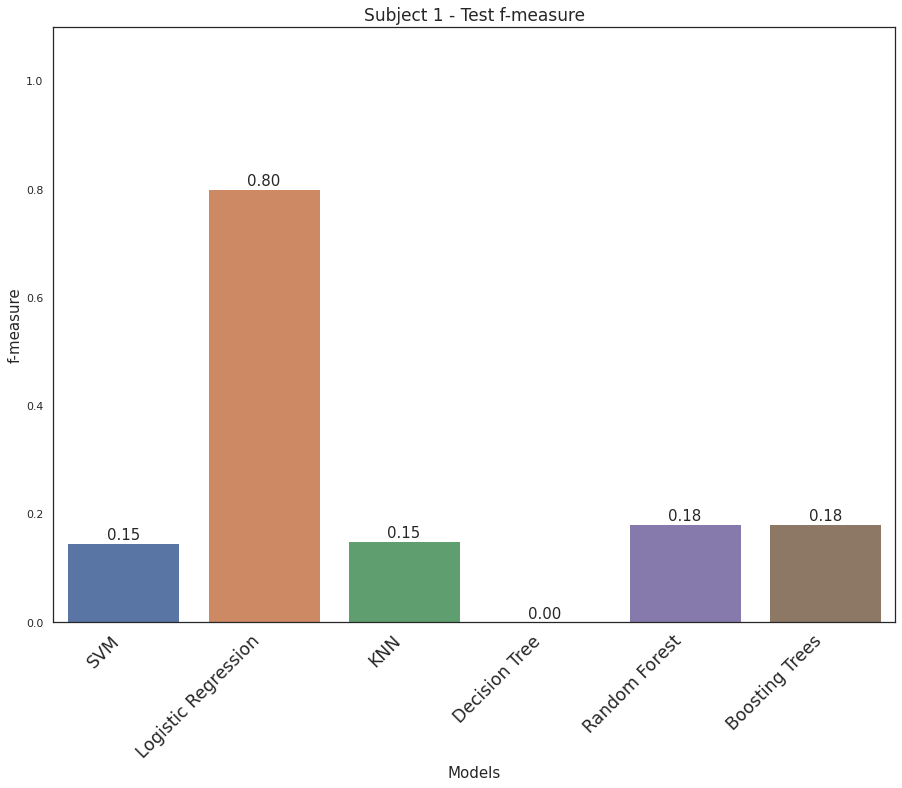

In [303]:
f_measure = [svmClfF, lrF, knnF, dtF, rfF, xgbClfF]
barPlot(f_measure, 'Subject 1 - Test f-measure', 'f-measure')

## Weighted Voting

### 3 WV

In [312]:
clf = [xgbClf, svmClf, knn]
weights = np.array([xgbClfValAcc, svmClfValAcc, knnValAcc])
pred = WeightedVotingClassification(clf, weights)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
s1_3wv = accuracy_score(df_testY, pred)
s1_3wv

0.48333333333333334

### 4 WV

In [313]:
clf = [xgbClf, svmClf, knn, rf]
weights = np.array([xgbClfValAcc, svmClfValAcc, knnValAcc, rfValAcc])
pred = WeightedVotingClassification(clf, weights)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
s1_4wv = accuracy_score(df_testY, pred)
s1_4wv

0.5333333333333333

### 5 WV

In [314]:
clf = [xgbClf, svmClf, knn, rf, dt]
weights = np.array([xgbClfValAcc, svmClfValAcc, knnValAcc, rfValAcc, dtValAcc])
pred = WeightedVotingClassification(clf, weights)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
s1_5wv = accuracy_score(df_testY, pred)
s1_5wv

0.5333333333333333

## Majority Voting

### 3 MV

In [315]:
clf = [xgbClf, svmClf, knn]
pred = MajorityVotingClassification(clf)
s1_3mv = accuracy_score(df_testY, pred)
s1_3mv

0.5

### 4 MV

In [316]:
clf = [xgbClf, svmClf, knn, rf]
pred = MajorityVotingClassification(clf)
s1_4mv = accuracy_score(df_testY, pred)
s1_4mv

0.55

### 5 MV

In [317]:
clf = [xgbClf, svmClf, knn, dt]
pred = MajorityVotingClassification(clf)
s1_5mv = accuracy_score(df_testY, pred)
s1_5mv

0.55

## Unanimous Voting

### 3 UV

In [318]:
clf = [xgbClf, svmClf, knn]
pred = UnanimousVotingClassification(clf)
s1_3uv = accuracy_score(df_testY, pred)
s1_3uv

0.55

### 4 UV

In [319]:
clf = [xgbClf, svmClf, knn, rf]
pred = UnanimousVotingClassification(clf)
s1_4uv = accuracy_score(df_testY, pred)
s1_4uv

0.55

### 5 UV

In [320]:
clf = [xgbClf, svmClf, knn, rf, dt]
pred = UnanimousVotingClassification(clf)
s1_5uv = accuracy_score(df_testY, pred)
s1_5uv

0.5

# Fold 2

In [321]:
df_train = pd.read_csv('Fold_2_Train_Dataset.csv', header=None) 
df_test = pd.read_csv('Fold_2_Test_Dataset.csv', header=None)

df_trainX = df_train.iloc[:,:-1]
df_trainY = df_train.iloc[:,-1]
df_testX = df_test.iloc[:,:-1]
df_testY = df_test.iloc[:,-1]

df_trainY[df_trainY==1] = 0
df_trainY[df_trainY==2] = 1
df_testY[df_testY==1] = 0
df_testY[df_testY==2] = 1

## Train Validation Sets

In [322]:
df_train_master, df_val_master = createMasterTrainVal(2)
df_trainX_master, df_trainY_master, df_valX_master, df_valY_master = getMasterTrainValXY(2, df_train_master, df_val_master)

## Hyperparameter Tuning

### SVM

In [ ]:
hyperparameterSearchSVM(2)

Iteration 1 C = 0.1 gamma = 1
Accuracy is: 0.4833333333333333
F-measure: 0.1933654775760039

Iteration 2 C = 0.1 gamma = 0.1
Accuracy is: 0.5425925925925925
F-measure: 0.5415528808094168

Iteration 3 C = 0.1 gamma = 0.01
Accuracy is: 0.46851851851851856
F-measure: 0.5482873921463616

Iteration 4 C = 0.1 gamma = 0.001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 5 C = 0.1 gamma = 0.0001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 6 C = 1 gamma = 1
Accuracy is: 0.6425925925925926
F-measure: 0.46153829473501606

Iteration 7 C = 1 gamma = 0.1
Accuracy is: 0.6518518518518518
F-measure: 0.5898099220921015

Iteration 8 C = 1 gamma = 0.01
Accuracy is: 0.5314814814814814
F-measure: 0.5347419903550826

Iteration 9 C = 1 gamma = 0.001
Accuracy is: 0.4629629629629629
F-measure: 0.5270136467346851

Iteration 10 C = 1 gamma = 0.0001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 11 C = 10 gamma = 1
Accuracy is: 0.7314814814814815
F-measure: 0.6463200305760739

I

{'0.10.0001': (0.0, 0.4444444444444444),
 '0.10.001': (0.0, 0.4444444444444444),
 '0.10.01': (0.5482873921463616, 0.46851851851851856),
 '0.10.1': (0.5415528808094168, 0.5425925925925925),
 '0.11': (0.1933654775760039, 0.4833333333333333),
 '10.0001': (0.0, 0.4444444444444444),
 '10.001': (0.5270136467346851, 0.4629629629629629),
 '10.01': (0.5347419903550826, 0.5314814814814814),
 '10.1': (0.5898099220921015, 0.6518518518518518),
 '100.0001': (0.011904761904761904, 0.3907407407407407),
 '100.001': (0.4709763175498815, 0.5092592592592592),
 '100.01': (0.4928477931539781, 0.5944444444444444),
 '100.1': (0.5306227520201663, 0.6407407407407407),
 '1000.0001': (0.4720857321642025, 0.5425925925925926),
 '1000.001': (0.42891918620643704, 0.5574074074074074),
 '1000.01': (0.5852286727466067, 0.6425925925925926),
 '1000.1': (0.46733826938430517, 0.6222222222222222),
 '10000.0001': (0.4377715618833807, 0.5648148148148149),
 '10000.001': (0.569669959846876, 0.6203703703703703),
 '10000.01': (0.4

### Logistic Regression

In [ ]:
hyperparameterSearchLR(2)

l20.23357214690901212liblinearFalse (0.6313635751857931, 0.6129629629629629)


{'l10.0001liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0001liblinearTrue': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearFalse': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearTrue': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearFalse': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearTrue': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearFalse': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearTrue': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearFalse': (0.0, 0.38518518518518513),
 'l10.03359818286283781liblinearTrue': (0.0, 0.38518518518518513),
 'l10.08858667904100823liblinearFalse': (0.46800288067550433,
  0.498148148

### KNN

In [ ]:
hyperparameterSearchKNN(2)

20distanceball_tree302 (0.7872875046545571, 0.7722222222222223)


{'10distanceauto1001': (0.6324995783834937, 0.701851851851852),
 '10distanceauto152': (0.6486846550270084, 0.7111111111111111),
 '10distanceauto602': (0.6486846550270084, 0.7111111111111111),
 '10distanceball_tree152': (0.6501922684749206, 0.712962962962963),
 '10distanceball_tree452': (0.6486846550270084, 0.7111111111111111),
 '10distancebrute1001': (0.6324995783834937, 0.701851851851852),
 '10distancebrute451': (0.6324995783834937, 0.701851851851852),
 '10distancebrute751': (0.6324995783834937, 0.701851851851852),
 '10distancebrute752': (0.6486846550270084, 0.7111111111111111),
 '10distancekd_tree302': (0.6486846550270084, 0.7111111111111111),
 '10uniformauto1001': (0.19560613678260738, 0.461111111111111),
 '10uniformauto1002': (0.21369251899979863, 0.4722222222222222),
 '10uniformauto152': (0.21369251899979863, 0.4722222222222222),
 '10uniformauto451': (0.19560613678260738, 0.461111111111111),
 '10uniformball_tree1001': (0.21227280344927404, 0.46851851851851856),
 '10uniformball_tre

### Decision Tree

In [ ]:
hyperparameterSearchDecisionTree(2)

giniauto20103800.1best (0.44992150022348454, 0.5833333333333334)


{'entropyNone1025300.4random': (0.11076555023923446, 0.3574074074074074),
 'entropyNone1029500.5best': (0.0, 0.4444444444444444),
 'entropyNone20106900.3random': (0.1452991452991453, 0.43333333333333335),
 'entropyNone2024100.3random': (0.1452991452991453, 0.43333333333333335),
 'entropyNone3059700.3best': (0.1452991452991453, 0.43333333333333335),
 'entropyNone40510900.4best': (0.11076555023923446, 0.3574074074074074),
 'entropyNone5027700.1random': (0.19387943699509394, 0.43333333333333335),
 'entropyNone5028None0.5random': (0.0, 0.4444444444444444),
 'entropyNone5055300.1random': (0.19387943699509394, 0.43333333333333335),
 'entropyNone60109600.5random': (0.0, 0.4444444444444444),
 'entropyNone6024900.4random': (0.11076555023923446, 0.3574074074074074),
 'entropyNone6028500.3best': (0.1452991452991453, 0.43333333333333335),
 'entropyNone7051100.1best': (0.19387943699509394, 0.43333333333333335),
 'entropyNone80104800.4random': (0.11076555023923446, 0.3574074074074074),
 'entropyNone

### Random Forest

In [ ]:
hyperparameterSearchRandomForest(2)

200log24051True (0.6642719589988763, 0.7592592592592592)


{'1000auto40104False': (0.6625092232329676, 0.7574074074074074),
 '1200auto4022False': (0.6625092232329676, 0.7574074074074074),
 '1600log22051False': (0.6608024473326433, 0.7555555555555555),
 '1800sqrt4054False': (0.6625092232329676, 0.7574074074074074),
 '2000sqrt10024True': (0.6590930483136197, 0.7518518518518519),
 '2000sqrt10052True': (0.6625092232329676, 0.7574074074074074),
 '2000sqrt1021True': (0.6625092232329676, 0.7574074074074074),
 '200autoNone52False': (0.6575464440766399, 0.7518518518518519),
 '200log24051True': (0.6642719589988763, 0.7592592592592592),
 '400autoNone51True': (0.6625092232329676, 0.7574074074074074),
 '400log211024True': (0.6590930483136197, 0.7537037037037037),
 '400sqrt5054False': (0.6608024473326433, 0.7555555555555555),
 '400sqrt60102True': (0.6608024473326433, 0.7555555555555555),
 '600auto6021False': (0.662565183098552, 0.7574074074074074),
 '600log220104True': (0.6590930483136197, 0.7537037037037037),
 '600sqrt3024False': (0.6625092232329676, 0.757

### Xgboost

In [ ]:
hyperparameterSearchXgb(2)

1400900.30.10.70.80.01 (0.6787102666089516, 0.7574074074074075)


{'10001100.030.00.80.90.01': (0.6625185983910445, 0.7574074074074075),
 '1000300.0030.20.60.61': (0.6550193509689427, 0.7444444444444445),
 '1000300.0030.40.80.9100': (0.0, 0.4444444444444444),
 '1000400.00010.10.60.61': (0.2897726214987546, 0.55),
 '1200100.0030.40.70.61e-05': (0.6613500396899012, 0.7574074074074075),
 '1200200.0030.10.70.90.01': (0.6555354758390812, 0.75),
 '1200400.010.00.70.70.01': (0.6648755112217186, 0.7611111111111112),
 '1200800.30.00.70.71e-05': (0.6787008914508745, 0.7574074074074075),
 '1400300.010.30.70.61': (0.6631246361018969, 0.7592592592592593),
 '1400600.0030.10.90.61e-05': (0.6579483485353397, 0.7537037037037038),
 '1400700.30.00.60.61': (0.6642719589988763, 0.7592592592592593),
 '1400900.30.10.70.80.01': (0.6787102666089516, 0.7574074074074075),
 '1600100.010.40.70.60.1': (0.6631805959674814, 0.7592592592592593),
 '16001000.010.00.70.90.1': (0.6642813341569532, 0.7592592592592593),
 '1600700.0030.00.60.90.1': (0.6596551244356639, 0.7537037037037038),

## SVM

Accuracy is: 0.9666666666666667
f-measure: 0.967741935483871
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.94      1.00      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



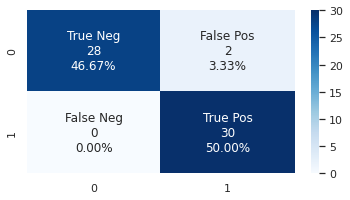

In [323]:
svmClfValF = 0.6588284600237547
svmClfValAcc = 0.7203703703703704
svmClf = svm.SVC(C = 1000, gamma = 0.1, kernel='rbf', probability=True)
svmClfAcc, svmClfF = userModel(svmClf)

## Logistic Regression

Accuracy is: 0.38333333333333336
f-measure: 0.13953488372093023
              precision    recall  f1-score   support

           0       0.43      0.67      0.52        30
           1       0.23      0.10      0.14        30

    accuracy                           0.38        60
   macro avg       0.33      0.38      0.33        60
weighted avg       0.33      0.38      0.33        60



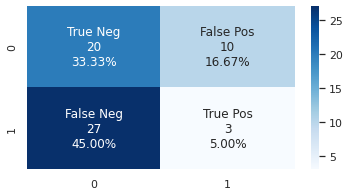

In [324]:
lrValF = 0.6313635751857931
lrValAcc = 0.6129629629629629
lr = LogisticRegression(penalty='l2', C=0.23357214690901212, solver='liblinear', fit_intercept=False)
lrAcc, lrF = userModel(lr)

## KNN

Accuracy is: 0.9333333333333333
f-measure: 0.9375
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        30
           1       0.88      1.00      0.94        30

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



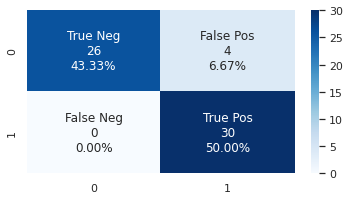

In [325]:
knnValF = 0.7872875046545571
knnValAcc = 0.7722222222222223
knn = KNeighborsClassifier(n_neighbors=20, weights='distance', algorithm='ball_tree', leaf_size=30, p=2)
knnAcc, knnF = userModel(knn)

## Decision Tree

Accuracy is: 0.8833333333333333
f-measure: 0.8955223880597014
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        30
           1       0.81      1.00      0.90        30

    accuracy                           0.88        60
   macro avg       0.91      0.88      0.88        60
weighted avg       0.91      0.88      0.88        60



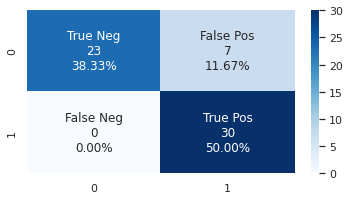

In [326]:
dtValF = 0.44992150022348454
dtValAcc = 0.5833333333333334
dt = DecisionTreeClassifier(criterion='gini', max_features='auto', max_depth=20, min_samples_split=10, min_samples_leaf=3, 
                            max_leaf_nodes=80, min_weight_fraction_leaf=0.1, splitter='best')
dtAcc, dtF = userModel(dt)

## Random Forest

Accuracy is: 0.9833333333333333
f-measure: 0.9836065573770492
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



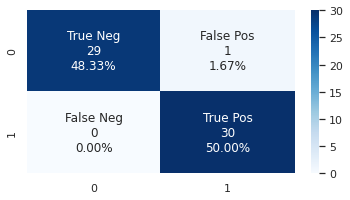

In [327]:
rfValF = 0.6642719589988763
rfValAcc = 0.7592592592592592
rf = RandomForestClassifier(n_estimators=200, max_features='log2', max_depth=40, min_samples_split=5, min_samples_leaf=1, bootstrap=True)
rfAcc, rfF = userModel(rf)

## Boosting

Accuracy is: 0.95
f-measure: 0.9523809523809523
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.91      1.00      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



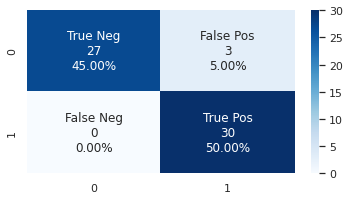

In [328]:
xgbClfValF = 0.6787102666089516
xgbClfValAcc = 0.7574074074074075
xgbClf = xgb.XGBClassifier(n_estimators=1400, max_depth=90, learning_rate=0.3, gamma=0.1, subsample=0.7, colsample_bytree=0.8,  
                           reg_alpha=0.01)
xgbClfAcc, xgbClfF = userModel(xgbClf)

## Plots

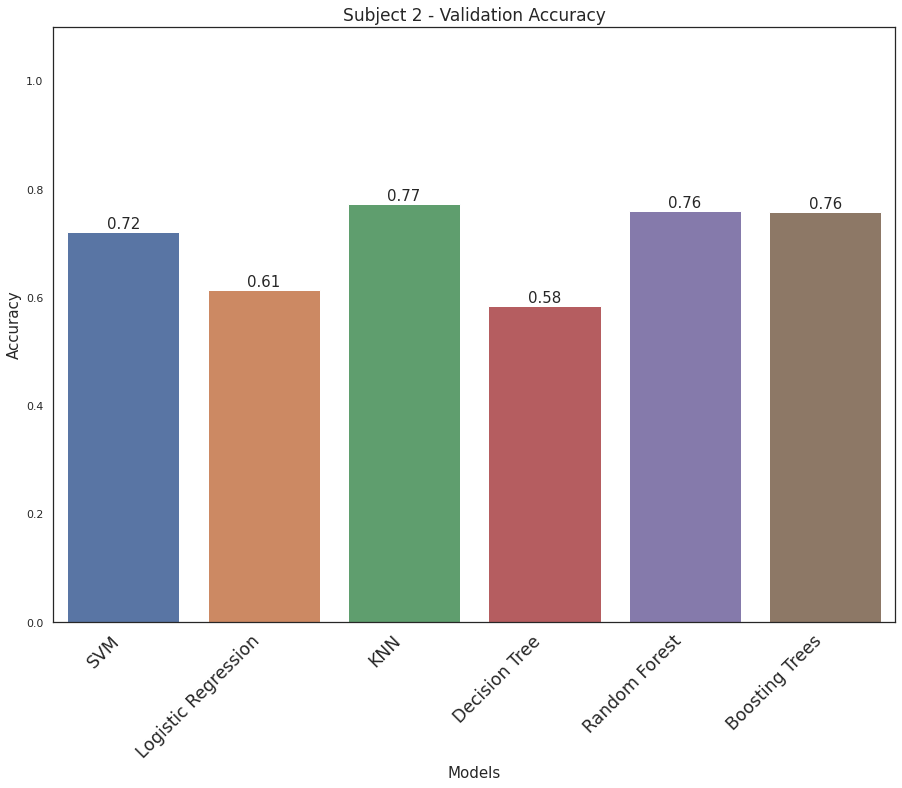

In [330]:
accuracies = [svmClfValAcc, lrValAcc, knnValAcc, dtValAcc, rfValAcc, xgbClfValAcc]
barPlot(accuracies, 'Subject 2 - Validation Accuracy', 'Accuracy')

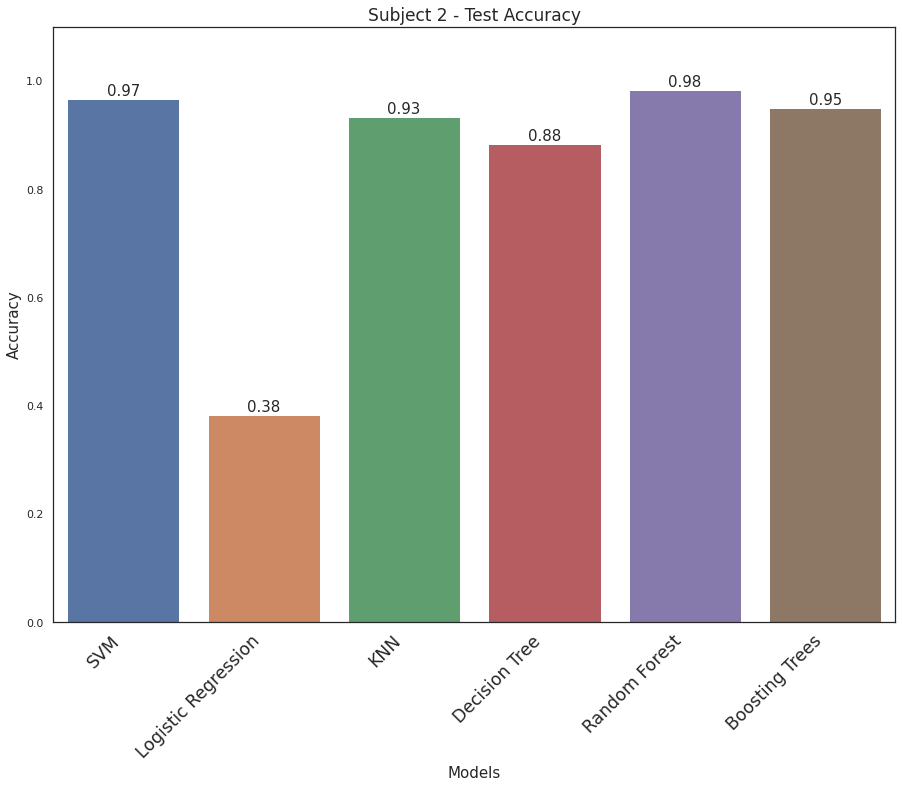

In [331]:
accuracies = [svmClfAcc, lrAcc, knnAcc, dtAcc, rfAcc, xgbClfAcc]
barPlot(accuracies, 'Subject 2 - Test Accuracy', 'Accuracy')

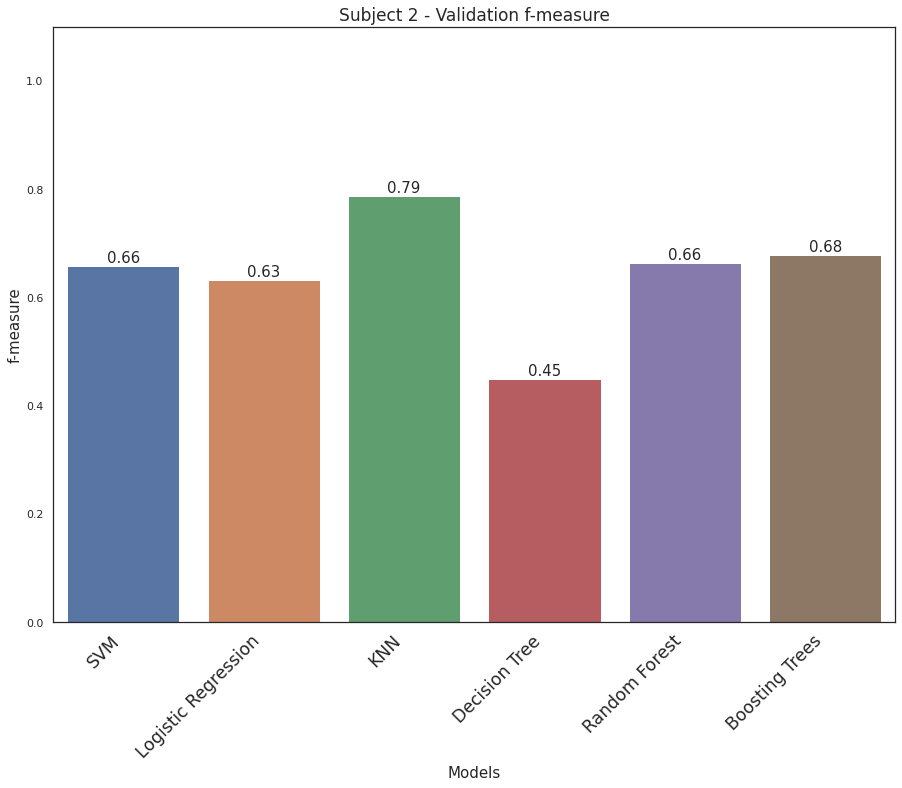

In [332]:
f_measure = [svmClfValF, lrValF, knnValF, dtValF, rfValF, xgbClfValF]
barPlot(f_measure, 'Subject 2 - Validation f-measure', 'f-measure')

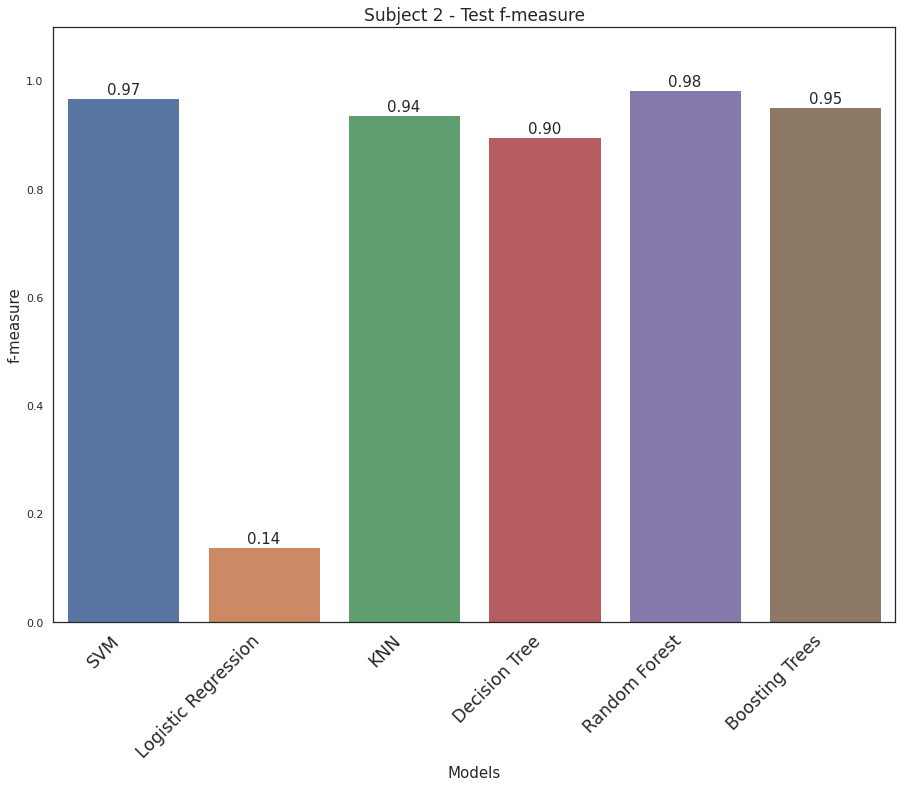

In [333]:
f_measure = [svmClfF, lrF, knnF, dtF, rfF, xgbClfF]
barPlot(f_measure, 'Subject 2 - Test f-measure', 'f-measure')

## Weighted Voting

### 3 WV

In [335]:
clf = [xgbClf, knn, svmClf]
weights = [xgbClfValAcc, knnValAcc, svmClfValAcc]
pred = WeightedVotingClassification(clf, weights)
s2_3wv = accuracy_score(df_testY, pred)
s2_3wv 

0.9666666666666667

### 4 WV

In [334]:
clf = [xgbClf, knn, svmClf, rf]
weights = [xgbClfValAcc, knnValAcc, svmClfValAcc, rfValAcc]
pred = WeightedVotingClassification(clf, weights)
s2_4wv = accuracy_score(df_testY, pred)
s2_4wv 

0.9666666666666667

### 5 WV

In [336]:
clf = [xgbClf, knn, svmClf, rf, lr]
weights = [xgbClfValAcc, knnValAcc, svmClfValAcc, rfValAcc, lrValAcc]
pred = WeightedVotingClassification(clf, weights)
s2_5wv = accuracy_score(df_testY, pred)
s2_5wv

0.9666666666666667

## Majority Voting

### 3 MV

In [337]:
clf = [xgbClf, knn, svmClf]
pred = MajorityVotingClassification(clf)
s2_3mv = accuracy_score(df_testY, pred)
s2_3mv

0.9666666666666667

### 4 MV

In [338]:
clf = [xgbClf, knn, svmClf, rf]
pred = MajorityVotingClassification(clf)
s2_4mv = accuracy_score(df_testY, pred)
s2_4mv

0.9833333333333333

### 5 MV

In [339]:
clf = [xgbClf, knn, svmClf, rf, lr]
pred = MajorityVotingClassification(clf)
s2_5mv = accuracy_score(df_testY, pred)
s2_5mv

0.9666666666666667

## Unanimous Voting

### 3 UV

In [340]:
clf = [xgbClf, knn, svmClf]
pred = UnanimousVotingClassification(clf)
s2_3uv = accuracy_score(df_testY, pred)
s2_3uv

0.9833333333333333

### 4 UV

In [341]:
clf = [xgbClf, knn, svmClf, rf]
pred = UnanimousVotingClassification(clf)
s2_4uv = accuracy_score(df_testY, pred)
s2_4uv

0.9833333333333333

### 5 UV

In [342]:
clf = [xgbClf, knn, svmClf, rf, lr]
pred = UnanimousVotingClassification(clf)
s2_5uv = accuracy_score(df_testY, pred)
s2_5uv

0.55

# Fold 3

In [343]:
df_train = pd.read_csv('Fold_3_Train_Dataset.csv', header=None) 
df_test = pd.read_csv('Fold_3_Test_Dataset.csv', header=None)

df_trainX = df_train.iloc[:,:-1]
df_trainY = df_train.iloc[:,-1]
df_testX = df_test.iloc[:,:-1]
df_testY = df_test.iloc[:,-1]

df_trainY[df_trainY==1] = 0
df_trainY[df_trainY==2] = 1
df_testY[df_testY==1] = 0
df_testY[df_testY==2] = 1

## Train Validation Sets

In [344]:
df_train_master, df_val_master = createMasterTrainVal(3)
df_trainX_master, df_trainY_master, df_valX_master, df_valY_master = getMasterTrainValXY(3, df_train_master, df_val_master)

## Hyperparameter Tuning

### SVM

In [ ]:
hyperparameterSearchSVM(3)

Iteration 1 C = 0.1 gamma = 1
Accuracy is: 0.5314814814814814
F-measure: 0.2799596845649477

Iteration 2 C = 0.1 gamma = 0.1
Accuracy is: 0.4870370370370371
F-measure: 0.3942412279394037

Iteration 3 C = 0.1 gamma = 0.01
Accuracy is: 0.461111111111111
F-measure: 0.5472554855748678

Iteration 4 C = 0.1 gamma = 0.001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 5 C = 0.1 gamma = 0.0001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 6 C = 1 gamma = 1
Accuracy is: 0.6444444444444444
F-measure: 0.4799156758652676

Iteration 7 C = 1 gamma = 0.1
Accuracy is: 0.6092592592592593
F-measure: 0.49398729332516833

Iteration 8 C = 1 gamma = 0.01
Accuracy is: 0.587037037037037
F-measure: 0.6082740226295338

Iteration 9 C = 1 gamma = 0.001
Accuracy is: 0.4574074074074074
F-measure: 0.5295679251510325

Iteration 10 C = 1 gamma = 0.0001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 11 C = 10 gamma = 1
Accuracy is: 0.7351851851851852
F-measure: 0.6625659601345755

Iter

{'0.10.0001': (0.0, 0.4444444444444444),
 '0.10.001': (0.0, 0.4444444444444444),
 '0.10.01': (0.5472554855748678, 0.461111111111111),
 '0.10.1': (0.3942412279394037, 0.4870370370370371),
 '0.11': (0.2799596845649477, 0.5314814814814814),
 '10.0001': (0.0, 0.4444444444444444),
 '10.001': (0.5295679251510325, 0.4574074074074074),
 '10.01': (0.6082740226295338, 0.587037037037037),
 '10.1': (0.49398729332516833, 0.6092592592592593),
 '100.0001': (0.0784313725490196, 0.4277777777777778),
 '100.001': (0.5302790287014622, 0.5462962962962963),
 '100.01': (0.5894056667677354, 0.6648148148148149),
 '100.1': (0.4357606372813674, 0.5777777777777778),
 '1000.0001': (0.4692096682723936, 0.5277777777777778),
 '1000.001': (0.42224984009200556, 0.538888888888889),
 '1000.01': (0.5166054045703289, 0.612962962962963),
 '1000.1': (0.5465246985729223, 0.6592592592592592),
 '10000.0001': (0.40924268296720134, 0.5351851851851852),
 '10000.001': (0.4036866633356805, 0.5351851851851852),
 '10000.01': (0.436271

### Logistic Regression

In [ ]:
hyperparameterSearchLR(3)

l11.623776739188721liblinearFalse (0.6458532847570049, 0.6388888888888888)


{'l10.0001liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0001liblinearTrue': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearFalse': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearTrue': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearFalse': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearTrue': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearFalse': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearTrue': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearFalse': (0.0, 0.38518518518518513),
 'l10.03359818286283781liblinearTrue': (0.0, 0.38518518518518513),
 'l10.08858667904100823liblinearFalse': (0.5421769737183629,
  0.5574074074

### KNN

In [ ]:
hyperparameterSearchKNN(3)

20distanceball_tree302 (0.7908115002085351, 0.7777777777777777)


{'10distanceauto1001': (0.6441725616127244, 0.7037037037037037),
 '10distanceauto152': (0.723934627142108, 0.7481481481481482),
 '10distanceauto602': (0.723934627142108, 0.7481481481481482),
 '10distanceball_tree152': (0.7268630987883716, 0.751851851851852),
 '10distanceball_tree452': (0.7257619894055005, 0.751851851851852),
 '10distancebrute1001': (0.6441725616127244, 0.7037037037037037),
 '10distancebrute451': (0.6441725616127244, 0.7037037037037037),
 '10distancebrute751': (0.6441725616127244, 0.7037037037037037),
 '10distancebrute752': (0.723934627142108, 0.7481481481481482),
 '10distancekd_tree302': (0.7257619894055005, 0.751851851851852),
 '10uniformauto1001': (0.28495722673325286, 0.5111111111111111),
 '10uniformauto1002': (0.29299813425248666, 0.5111111111111111),
 '10uniformauto152': (0.29299813425248666, 0.5111111111111111),
 '10uniformauto451': (0.28495722673325286, 0.5111111111111111),
 '10uniformball_tree1001': (0.2897763206827816, 0.5185185185185185),
 '10uniformball_tree

### Decision Tree

In [ ]:
hyperparameterSearchDecisionTree(3)

ginilog28055300.2random (0.46641343771169524, 0.574074074074074)


{'entropyNone1025300.4random': (0.20872396959353484, 0.41111111111111115),
 'entropyNone1029500.5best': (0.0, 0.4444444444444444),
 'entropyNone20106900.3random': (0.22973484848484846, 0.46481481481481474),
 'entropyNone2024100.3random': (0.22973484848484846, 0.46481481481481474),
 'entropyNone3059700.3best': (0.22973484848484846, 0.46481481481481474),
 'entropyNone40510900.4best': (0.20872396959353484, 0.41111111111111115),
 'entropyNone5027700.1random': (0.36309250537717364, 0.5777777777777778),
 'entropyNone5028None0.5random': (0.0, 0.4444444444444444),
 'entropyNone5055300.1random': (0.36309250537717364, 0.5777777777777778),
 'entropyNone60109600.5random': (0.0, 0.4444444444444444),
 'entropyNone6024900.4random': (0.20872396959353484, 0.41111111111111115),
 'entropyNone6028500.3best': (0.22973484848484846, 0.46481481481481474),
 'entropyNone7051100.1best': (0.36309250537717364, 0.5777777777777778),
 'entropyNone80104800.4random': (0.20872396959353484, 0.41111111111111115),
 'entrop

### Random Forest

In [ ]:
hyperparameterSearchRandomForest(3)

2000sqrt1021True (0.6809895504073007, 0.7629629629629631)


{'1000auto40104False': (0.6809895504073007, 0.7629629629629631),
 '1200auto4022False': (0.6803953733425353, 0.7611111111111112),
 '1600log22051False': (0.6735190619150315, 0.7537037037037038),
 '1800sqrt4054False': (0.6803953733425353, 0.7611111111111112),
 '2000sqrt10024True': (0.679226814641392, 0.7611111111111112),
 '2000sqrt10052True': (0.6809895504073007, 0.7629629629629631),
 '2000sqrt1021True': (0.6809895504073007, 0.7629629629629631),
 '200autoNone52False': (0.6809895504073007, 0.7629629629629631),
 '200log24051True': (0.6803953733425353, 0.7611111111111112),
 '400autoNone51True': (0.6798351492528995, 0.7592592592592593),
 '400log211024True': (0.679226814641392, 0.7611111111111112),
 '400sqrt5054False': (0.6809895504073007, 0.7629629629629631),
 '400sqrt60102True': (0.6809895504073007, 0.7629629629629631),
 '600auto6021False': (0.6735190619150315, 0.7537037037037038),
 '600log220104True': (0.6786326375766266, 0.7592592592592593),
 '600sqrt3024False': (0.6803953733425353, 0.7611

### Xgboost

In [ ]:
hyperparameterSearchXgb(3)

1200400.010.00.70.70.01 (0.6774828291916373, 0.7592592592592593)


{'10001100.030.00.80.90.01': (0.6757200934257286, 0.7574074074074075),
 '1000300.0030.20.60.61': (0.6751646517247579, 0.751851851851852),
 '1000300.0030.40.80.9100': (0.0, 0.4444444444444444),
 '1000400.00010.10.60.61': (0.572371739018052, 0.7074074074074075),
 '1200100.0030.40.70.61e-05': (0.673472477207524, 0.7537037037037038),
 '1200200.0030.10.70.90.01': (0.6712757360401946, 0.75),
 '1200400.010.00.70.70.01': (0.6774828291916373, 0.7592592592592593),
 '1200800.30.00.70.71e-05': (0.673421625948649, 0.7537037037037038),
 '1400300.010.30.70.61': (0.6758293900381981, 0.7574074074074075),
 '1400600.0030.10.90.61e-05': (0.6752352129734328, 0.7555555555555556),
 '1400700.30.00.60.61': (0.67230902711309, 0.7537037037037038),
 '1400900.30.10.70.80.01': (0.6745775529174144, 0.7537037037037038),
 '1600100.010.40.70.60.1': (0.6774828291916373, 0.7592592592592593),
 '16001000.010.00.70.90.1': (0.6757200934257286, 0.7574074074074075),
 '1600700.0030.00.60.90.1': (0.6712757360401946, 0.75),
 '160

## SVM

Accuracy is: 0.9166666666666666
f-measure: 0.923076923076923
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        30
           1       0.86      1.00      0.92        30

    accuracy                           0.92        60
   macro avg       0.93      0.92      0.92        60
weighted avg       0.93      0.92      0.92        60



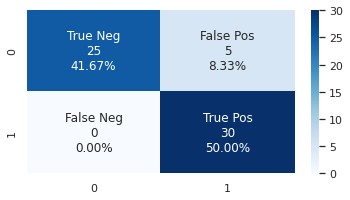

In [345]:
svmClfValF = 0.732329482447388
svmClfValAcc = 0.7611111111111112
svmClf = svm.SVC(C = 1000, gamma = 0.1, kernel='rbf', probability=True)
svmClfAcc, svmClfF = userModel(svmClf)

## Logistic Regression

Accuracy is: 0.3
f-measure: 0.125
              precision    recall  f1-score   support

           0       0.36      0.50      0.42        30
           1       0.17      0.10      0.12        30

    accuracy                           0.30        60
   macro avg       0.26      0.30      0.27        60
weighted avg       0.26      0.30      0.27        60



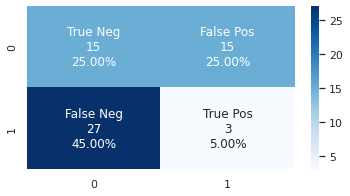

In [346]:
lrValF = 0.6458532847570049
lrValAcc = 0.6388888888888888
lr = LogisticRegression(penalty='l1', C=1.623776739188721, solver='liblinear', fit_intercept=False)
lrAcc, lrF = userModel(lr)

## KNN

Accuracy is: 0.8166666666666667
f-measure: 0.8450704225352113
              precision    recall  f1-score   support

           0       1.00      0.63      0.78        30
           1       0.73      1.00      0.85        30

    accuracy                           0.82        60
   macro avg       0.87      0.82      0.81        60
weighted avg       0.87      0.82      0.81        60



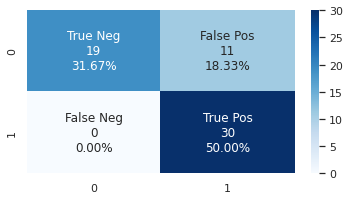

In [347]:
knnValF = 0.7908115002085351
knnValAcc = 0.7777777777777777
knn = KNeighborsClassifier(n_neighbors=20, weights='distance', algorithm='ball_tree', leaf_size=30, p=2)
knnAcc, knnF = userModel(knn)

## Decision Tree

Accuracy is: 0.5
f-measure: 0.0
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        30
           1       0.00      0.00      0.00        30

    accuracy                           0.50        60
   macro avg       0.25      0.50      0.33        60
weighted avg       0.25      0.50      0.33        60



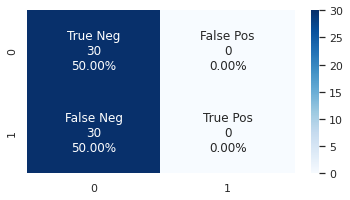

In [348]:
dtValF = 0.46641343771169524
dtValAcc = 0.574074074074074
dt = DecisionTreeClassifier(criterion='gini', max_features='log2', max_depth=80, min_samples_split=5, min_samples_leaf=5, 
                            max_leaf_nodes=30, min_weight_fraction_leaf=0.2, splitter='random')
dtAcc, dtF = userModel(dt)

## Random Forest

Accuracy is: 0.9666666666666667
f-measure: 0.967741935483871
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.94      1.00      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



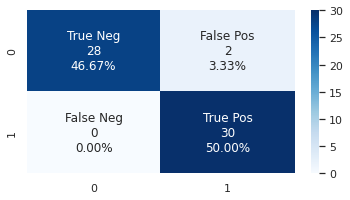

In [349]:
rfValF = 0.6809895504073007
rfValAcc = 0.7629629629629631
rf = RandomForestClassifier(n_estimators=2000, max_features='sqrt', max_depth=10, min_samples_split=2, min_samples_leaf=1, bootstrap=True)
rfAcc, rfF = userModel(rf)

## Boosting

Accuracy is: 0.9833333333333333
f-measure: 0.9836065573770492
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



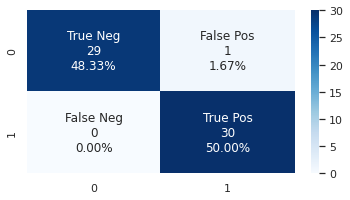

In [350]:
xgbClfValF = 0.6774828291916373
xgbClfValAcc = 0.7592592592592593
xgbClf = xgb.XGBClassifier(n_estimators=1200, max_depth=40, learning_rate=0.01, gamma=0, subsample=0.7, colsample_bytree=0.7,  
                           reg_alpha=0.01)
xgbClfAcc, xgbClfF = userModel(xgbClf)

## Plots

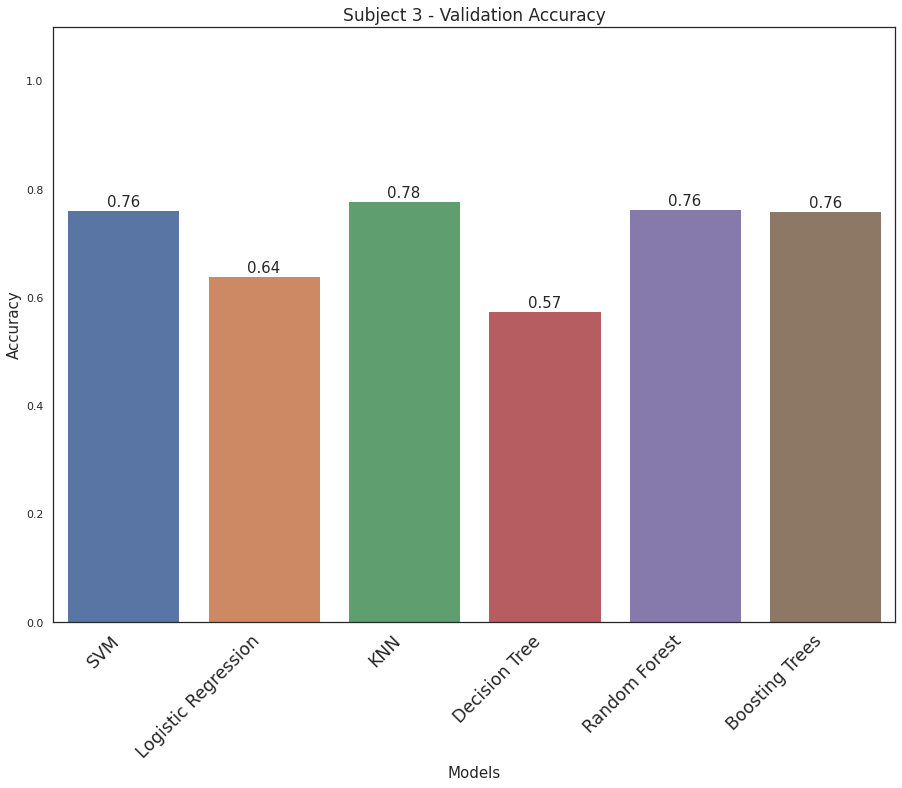

In [353]:
accuracies = [svmClfValAcc, lrValAcc, knnValAcc, dtValAcc, rfValAcc, xgbClfValAcc]
barPlot(accuracies, 'Subject 3 - Validation Accuracy', 'Accuracy')

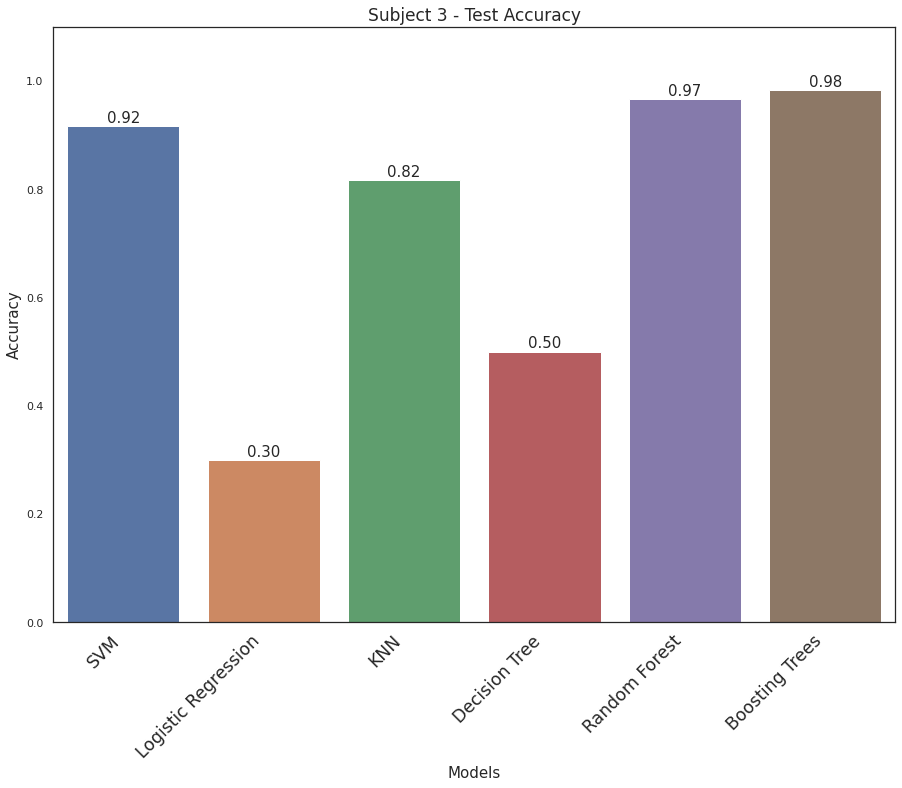

In [354]:
accuracies = [svmClfAcc, lrAcc, knnAcc, dtAcc, rfAcc, xgbClfAcc]
barPlot(accuracies, 'Subject 3 - Test Accuracy', 'Accuracy')

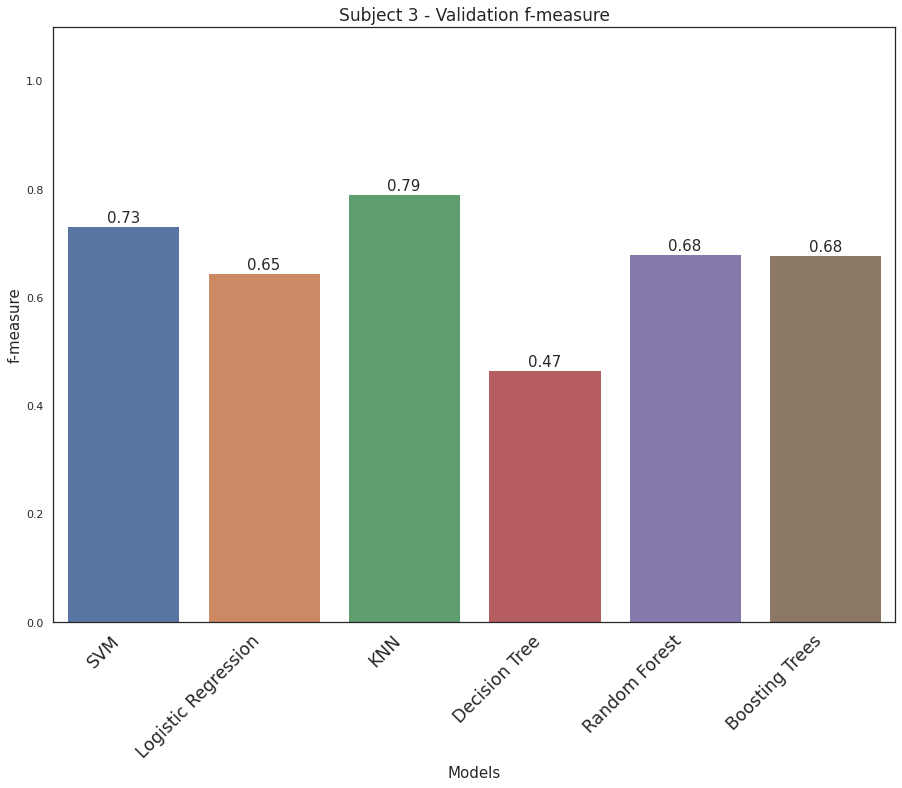

In [355]:
f_measure = [svmClfValF, lrValF, knnValF, dtValF, rfValF, xgbClfValF]
barPlot(f_measure, 'Subject 3 - Validation f-measure', 'f-measure')

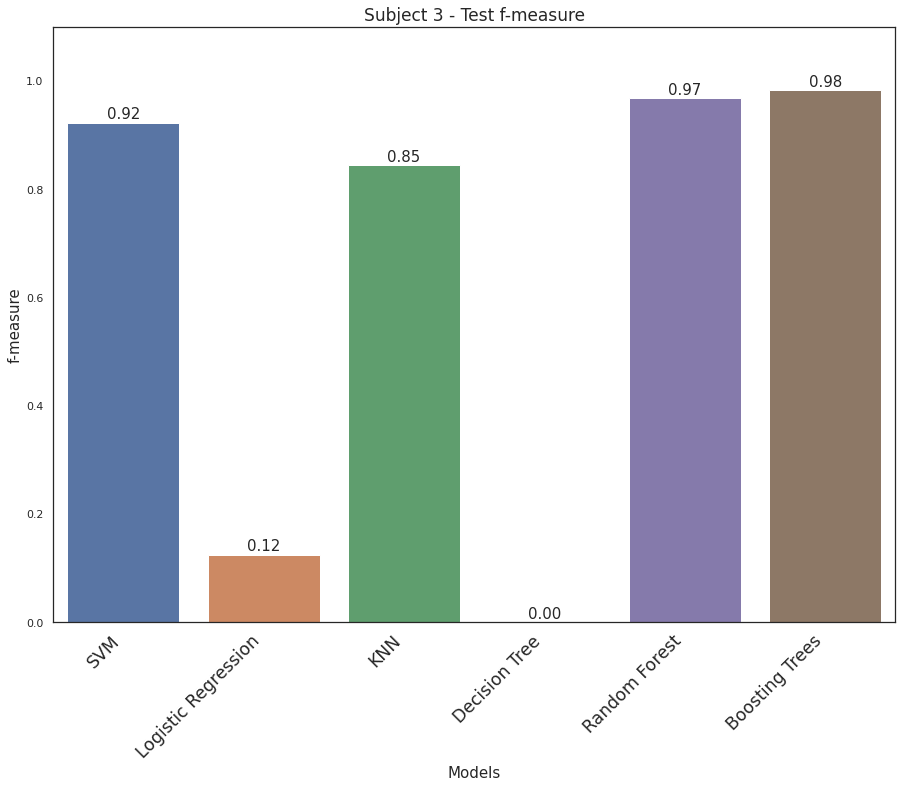

In [356]:
f_measure = [svmClfF, lrF, knnF, dtF, rfF, xgbClfF]
barPlot(f_measure, 'Subject 3 - Test f-measure', 'f-measure')

## Weighted Voting

### 3 WV

In [357]:
clf = [knn, svmClf, xgbClf]
weights = [knnValAcc, svmClfValAcc, xgbClfValAcc]
pred = WeightedVotingClassification(clf, weights)
s3_3wv = accuracy_score(df_testY, pred)
s3_3wv

0.95

### 4 WV

In [358]:
clf = [knn, svmClf, xgbClf, rf]
weights = [knnValAcc, svmClfValAcc, xgbClfValAcc, rfValAcc]
pred = WeightedVotingClassification(clf, weights)
s3_4wv = accuracy_score(df_testY, pred)
s3_4wv 

0.95

### 5 WV

In [359]:
clf = [knn, svmClf, xgbClf, rf, lr]
weights = [knnValAcc, svmClfValAcc, xgbClfValAcc, rfValAcc, lrValAcc]
pred = WeightedVotingClassification(clf, weights)
s3_5wv = accuracy_score(df_testY, pred)
s3_5wv

0.9333333333333333

## Majority Voting

### 3 MV

In [360]:
clf = [knn, svmClf, xgbClf]
pred = MajorityVotingClassification(clf)
s3_3mv = accuracy_score(df_testY, pred)
s3_3mv

0.9166666666666666

### 4 MV

In [362]:
clf = [knn, svmClf, xgbClf, rf]
pred = MajorityVotingClassification(clf)
s3_4mv = accuracy_score(df_testY, pred)
s3_4mv

0.9833333333333333

### 5 MV

In [363]:
clf = [xgbClf, knn, svmClf, rf, lr]
pred = MajorityVotingClassification(clf)
s3_5mv = accuracy_score(df_testY, pred)
s3_5mv

0.9333333333333333

## Unanimous Voting

### 3 UV

In [365]:
clf = [knn, svmClf, xgbClf]
pred = UnanimousVotingClassification(clf)
s3_3uv = accuracy_score(df_testY, pred)
s3_3uv

0.9833333333333333

### 4 UV

In [366]:
clf = [knn, svmClf, xgbClf, rf]
pred = UnanimousVotingClassification(clf)
s3_4uv = accuracy_score(df_testY, pred)
s3_4uv

0.9833333333333333

### 5 UV

In [367]:
clf = [xgbClf, knn, svmClf, rf, lr]
pred = UnanimousVotingClassification(clf)
s3_5uv = accuracy_score(df_testY, pred)
s3_5uv 

0.55

# Fold 4

In [592]:
df_train = pd.read_csv('Fold_4_Train_Dataset.csv', header=None) 
df_test = pd.read_csv('Fold_4_Test_Dataset.csv', header=None)

df_trainX = df_train.iloc[:,:-1]
df_trainY = df_train.iloc[:,-1]
df_testX = df_test.iloc[:,:-1]
df_testY = df_test.iloc[:,-1]

df_trainY[df_trainY==1] = 0
df_trainY[df_trainY==2] = 1
df_testY[df_testY==1] = 0
df_testY[df_testY==2] = 1

## Train Validation Sets

In [593]:
df_train_master, df_val_master = createMasterTrainVal(4)
df_trainX_master, df_trainY_master, df_valX_master, df_valY_master = getMasterTrainValXY(4, df_train_master, df_val_master)

## Hyperparameter Tuning

### SVM

In [ ]:
hyperparameterSearchSVM(4)

Iteration 1 C = 0.1 gamma = 1
Accuracy is: 0.5351851851851852
F-measure: 0.2852438477438477

Iteration 2 C = 0.1 gamma = 0.1
Accuracy is: 0.5296296296296297
F-measure: 0.4553374010476683

Iteration 3 C = 0.1 gamma = 0.01
Accuracy is: 0.45370370370370366
F-measure: 0.5443393273287316

Iteration 4 C = 0.1 gamma = 0.001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 5 C = 0.1 gamma = 0.0001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 6 C = 1 gamma = 1
Accuracy is: 0.6481481481481483
F-measure: 0.4781415265286233

Iteration 7 C = 1 gamma = 0.1
Accuracy is: 0.6037037037037036
F-measure: 0.49664794194169937

Iteration 8 C = 1 gamma = 0.01
Accuracy is: 0.5333333333333334
F-measure: 0.5784896952823748

Iteration 9 C = 1 gamma = 0.001
Accuracy is: 0.4351851851851852
F-measure: 0.5374774804743809

Iteration 10 C = 1 gamma = 0.0001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 11 C = 10 gamma = 1
Accuracy is: 0.7425925925925927
F-measure: 0.6656627462732607

I

{'0.10.0001': (0.0, 0.4444444444444444),
 '0.10.001': (0.0, 0.4444444444444444),
 '0.10.01': (0.5443393273287316, 0.45370370370370366),
 '0.10.1': (0.4553374010476683, 0.5296296296296297),
 '0.11': (0.2852438477438477, 0.5351851851851852),
 '10.0001': (0.0, 0.4444444444444444),
 '10.001': (0.5374774804743809, 0.4351851851851852),
 '10.01': (0.5784896952823748, 0.5333333333333334),
 '10.1': (0.49664794194169937, 0.6037037037037036),
 '100.0001': (0.015151515151515154, 0.42962962962962964),
 '100.001': (0.5025150323522838, 0.46851851851851856),
 '100.01': (0.4928102963873556, 0.5888888888888889),
 '100.1': (0.3626819245054975, 0.5629629629629629),
 '1000.0001': (0.46494668330417116, 0.49444444444444446),
 '1000.001': (0.4843816893524495, 0.537037037037037),
 '1000.01': (0.5026879163230653, 0.6148148148148148),
 '1000.1': (0.4721770140355271, 0.6296296296296297),
 '10000.0001': (0.49370293814738253, 0.55),
 '10000.001': (0.5050282341381191, 0.5777777777777777),
 '10000.01': (0.43889259667

### Logistic Regression

In [ ]:
hyperparameterSearchLR(4)

l20.08858667904100823liblinearFalse (0.48587618559212586, 0.5296296296296297)


{'l10.0001liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0001liblinearTrue': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearFalse': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearTrue': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearFalse': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearTrue': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearFalse': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearTrue': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearFalse': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearTrue': (0.0, 0.4444444444444444),
 'l10.08858667904100823liblinearFalse': (0.1620239033359601,
  0.327777777777

### KNN

In [ ]:
hyperparameterSearchKNN(4)

10distancebrute451 (0.7210767516063941, 0.7537037037037037)


{'10distanceauto1001': (0.7210767516063941, 0.7537037037037037),
 '10distanceauto152': (0.6435727169602162, 0.7074074074074075),
 '10distanceauto602': (0.6435727169602162, 0.7074074074074075),
 '10distanceball_tree152': (0.6469540807776102, 0.712962962962963),
 '10distanceball_tree452': (0.6435727169602162, 0.7074074074074075),
 '10distancebrute1001': (0.7210767516063941, 0.7537037037037037),
 '10distancebrute451': (0.7210767516063941, 0.7537037037037037),
 '10distancebrute751': (0.7210767516063941, 0.7537037037037037),
 '10distancebrute752': (0.6435727169602162, 0.7074074074074075),
 '10distancekd_tree302': (0.6435727169602162, 0.7074074074074075),
 '10uniformauto1001': (0.2812579281569051, 0.5148148148148148),
 '10uniformauto1002': (0.29632651917222275, 0.5148148148148148),
 '10uniformauto152': (0.29632651917222275, 0.5148148148148148),
 '10uniformauto451': (0.2812579281569051, 0.5148148148148148),
 '10uniformball_tree1001': (0.2832401301391071, 0.5240740740740741),
 '10uniformball_t

### Decision Tree

In [ ]:
hyperparameterSearchDecisionTree(4)

entropyauto80107400.1best (0.6828715815142279, 0.7055555555555555)


{'entropyNone1025300.4random': (0.3698858080789682, 0.47777777777777775),
 'entropyNone1029500.5best': (0.0, 0.4444444444444444),
 'entropyNone20106900.3random': (0.24484235571192092, 0.5),
 'entropyNone2024100.3random': (0.24484235571192092, 0.5),
 'entropyNone3059700.3best': (0.24484235571192092, 0.5),
 'entropyNone40510900.4best': (0.3698858080789682, 0.47777777777777775),
 'entropyNone5027700.1random': (0.47825948295918735, 0.6222222222222221),
 'entropyNone5028None0.5random': (0.0, 0.4444444444444444),
 'entropyNone5055300.1random': (0.47825948295918735, 0.6222222222222221),
 'entropyNone60109600.5random': (0.0, 0.4444444444444444),
 'entropyNone6024900.4random': (0.3698858080789682, 0.47777777777777775),
 'entropyNone6028500.3best': (0.24484235571192092, 0.5),
 'entropyNone7051100.1best': (0.47825948295918735, 0.6222222222222221),
 'entropyNone80104800.4random': (0.3698858080789682, 0.47777777777777775),
 'entropyNone80510600.3random': (0.24484235571192092, 0.5),
 'entropyNone805

### Random Forest

In [ ]:
hyperparameterSearchRandomForest(4)

1200auto4022False (0.6809895504073006, 0.7629629629629631)


{'1000auto40104False': (0.6803953733425353, 0.7611111111111112),
 '1200auto4022False': (0.6809895504073006, 0.7629629629629631),
 '1600log22051False': (0.6777335471512973, 0.7592592592592592),
 '1800sqrt4054False': (0.6803953733425353, 0.7611111111111112),
 '2000sqrt10024True': (0.6768792769687949, 0.7574074074074075),
 '2000sqrt10052True': (0.6809895504073006, 0.7629629629629631),
 '2000sqrt1021True': (0.679236189799469, 0.7611111111111112),
 '200autoNone52False': (0.6793361112538614, 0.7611111111111112),
 '200log24051True': (0.6775827506460298, 0.7592592592592593),
 '400autoNone51True': (0.6774734540335603, 0.7592592592592593),
 '400log211024True': (0.6768792769687949, 0.7574074074074075),
 '400sqrt5054False': (0.6803953733425353, 0.7611111111111112),
 '400sqrt60102True': (0.6786420127347036, 0.7592592592592593),
 '600auto6021False': (0.6725339490940553, 0.75),
 '600log220104True': (0.6786420127347036, 0.7592592592592593),
 '600sqrt3024False': (0.6803953733425353, 0.7611111111111112)

### Xgboost

In [ ]:
hyperparameterSearchXgb(4)

400900.0010.10.90.70.1 (0.763154251556608, 0.8037037037037038)


{'10001100.030.00.80.90.01': (0.6774828291916373, 0.7592592592592593),
 '1000300.0030.20.60.61': (0.6752258378153557, 0.7555555555555556),
 '1000300.0030.40.80.9100': (0.0, 0.4444444444444444),
 '1000400.00010.10.60.61': (0.573431001106726, 0.7074074074074075),
 '1200100.0030.40.70.61e-05': (0.6787419341890961, 0.7592592592592593),
 '1200200.0030.10.70.90.01': (0.6752258378153557, 0.7555555555555556),
 '1200400.010.00.70.70.01': (0.6775827506460297, 0.7592592592592593),
 '1200800.30.00.70.71e-05': (0.6739692183059068, 0.7555555555555556),
 '1400300.010.30.70.61': (0.6736232737127916, 0.7537037037037037),
 '1400600.0030.10.90.61e-05': (0.6759801865434656, 0.7574074074074074),
 '1400700.30.00.60.61': (0.6774640788754832, 0.7592592592592593),
 '1400900.30.10.70.80.01': (0.6750699564953788, 0.7555555555555556),
 '1600100.010.40.70.60.1': (0.6775827506460297, 0.7592592592592593),
 '16001000.010.00.70.90.1': (0.6792361897994689, 0.7611111111111112),
 '1600700.0030.00.60.90.1': (0.67522583781

## SVM

Accuracy is: 0.9
f-measure: 0.9090909090909091
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        30
           1       0.83      1.00      0.91        30

    accuracy                           0.90        60
   macro avg       0.92      0.90      0.90        60
weighted avg       0.92      0.90      0.90        60



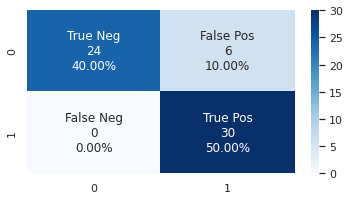

In [594]:
svmClfValF = 0.7413418530068581
svmClfValAcc = 0.7777777777777779
svmClf = svm.SVC(C = 1000, gamma = 0.1, kernel='rbf', probability=True)
svmClfAcc, svmClfF = userModel(svmClf)

## Logistic Regression

Accuracy is: 0.7666666666666667
f-measure: 0.8108108108108109
              precision    recall  f1-score   support

           0       1.00      0.53      0.70        30
           1       0.68      1.00      0.81        30

    accuracy                           0.77        60
   macro avg       0.84      0.77      0.75        60
weighted avg       0.84      0.77      0.75        60



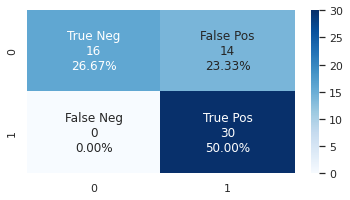

In [595]:
lrValF = 0.48587618559212586
lrValAcc = 0.5296296296296297
lr = LogisticRegression(penalty='l2', C=0.08858667904100823, solver='liblinear', fit_intercept=False)
lrAcc, lrF = userModel(lr)

## KNN

Accuracy is: 0.8833333333333333
f-measure: 0.8955223880597014
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        30
           1       0.81      1.00      0.90        30

    accuracy                           0.88        60
   macro avg       0.91      0.88      0.88        60
weighted avg       0.91      0.88      0.88        60



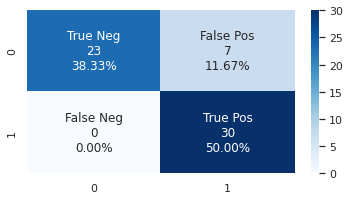

In [596]:
knnValF = 0.7210767516063941
knnValAcc = 0.7537037037037037
knn = KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='brute', leaf_size=45, p=1)
knnAcc, knnF = userModel(knn)

## Decision Tree

Accuracy is: 0.48333333333333334
f-measure: 0.16216216216216217
              precision    recall  f1-score   support

           0       0.49      0.87      0.63        30
           1       0.43      0.10      0.16        30

    accuracy                           0.48        60
   macro avg       0.46      0.48      0.39        60
weighted avg       0.46      0.48      0.39        60



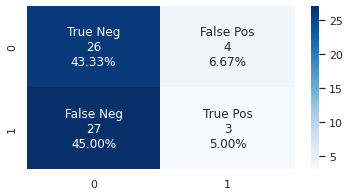

In [597]:
dtValF = 0.6828715815142279
dtValAcc = 0.7055555555555555
dt = DecisionTreeClassifier(criterion='entropy', max_features='auto', max_depth=80, min_samples_split=10, min_samples_leaf=7, 
                            max_leaf_nodes=40, min_weight_fraction_leaf=0.1, splitter='best')
dtAcc, dtF = userModel(dt)

## Random Forest

Accuracy is: 0.95
f-measure: 0.9523809523809523
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.91      1.00      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



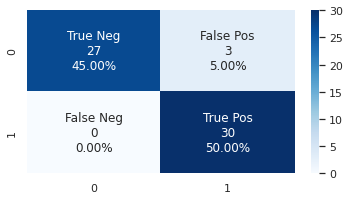

In [598]:
rfValF = 0.6809895504073006
rfValAcc = 0.7629629629629631
rf = RandomForestClassifier(n_estimators=1200, max_features='auto', max_depth=40, min_samples_split=2, min_samples_leaf=2, bootstrap=False)
rfAcc, rfF = userModel(rf)

## Boosting

Accuracy is: 0.9333333333333333
f-measure: 0.9375
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        30
           1       0.88      1.00      0.94        30

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



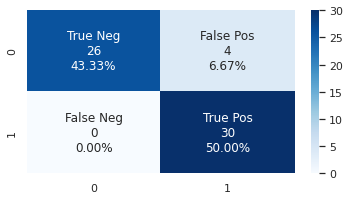

In [599]:
xgbClfValF = 0.763154251556608
xgbClfValAcc = 0.8037037037037038
xgbClf = xgb.XGBClassifier(n_estimators=400, max_depth=90, learning_rate=0.001, gamma=0.1, subsample=0.9, colsample_bytree=0.7,  
                           reg_alpha=0.1)
xgbClfAcc, xgbClfF = userModel(xgbClf)

## Plots

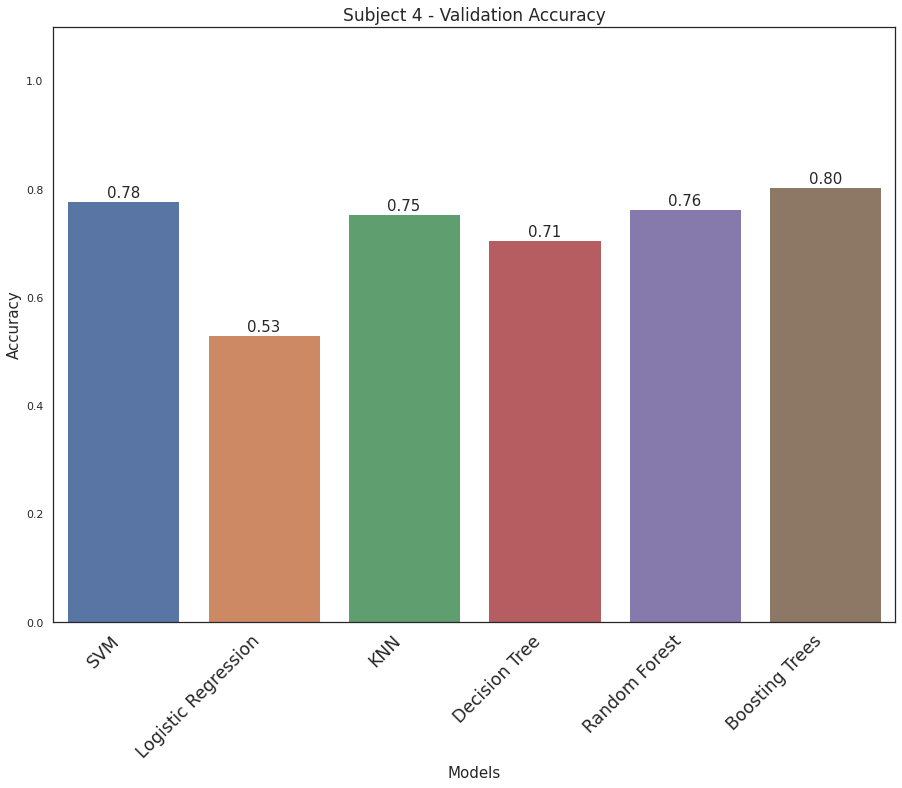

In [381]:
accuracies = [svmClfValAcc, lrValAcc, knnValAcc, dtValAcc, rfValAcc, xgbClfValAcc]
barPlot(accuracies, 'Subject 4 - Validation Accuracy', 'Accuracy')

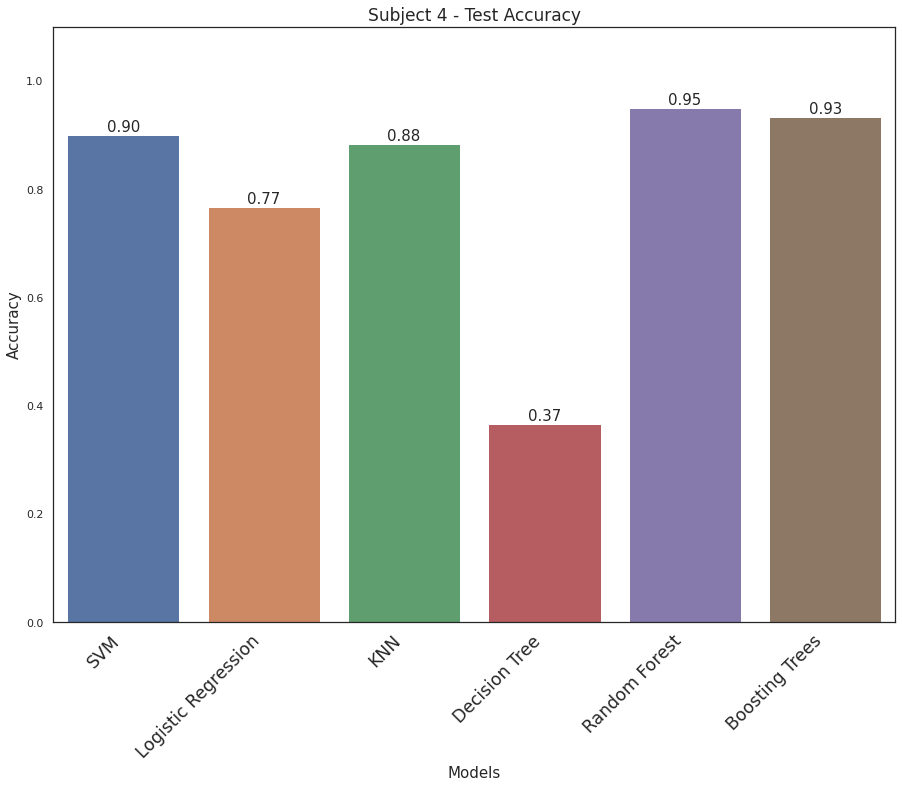

In [382]:
accuracies = [svmClfAcc, lrAcc, knnAcc, dtAcc, rfAcc, xgbClfAcc]
barPlot(accuracies, 'Subject 4 - Test Accuracy', 'Accuracy')

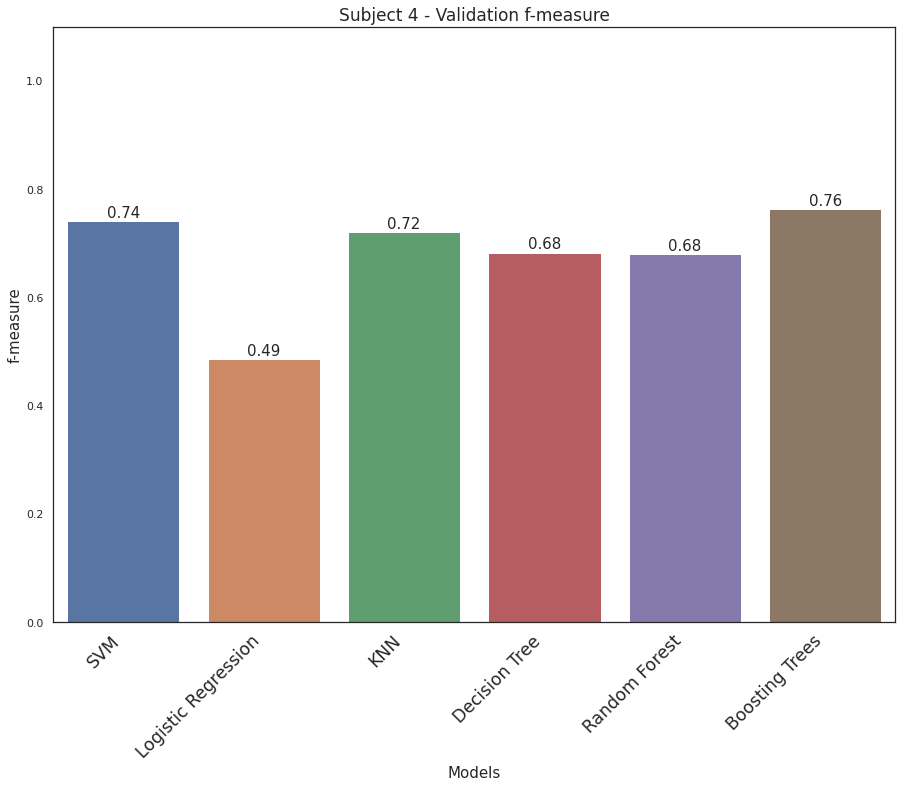

In [383]:
f_measure = [svmClfValF, lrValF, knnValF, dtValF, rfValF, xgbClfValF]
barPlot(f_measure, 'Subject 4 - Validation f-measure', 'f-measure')

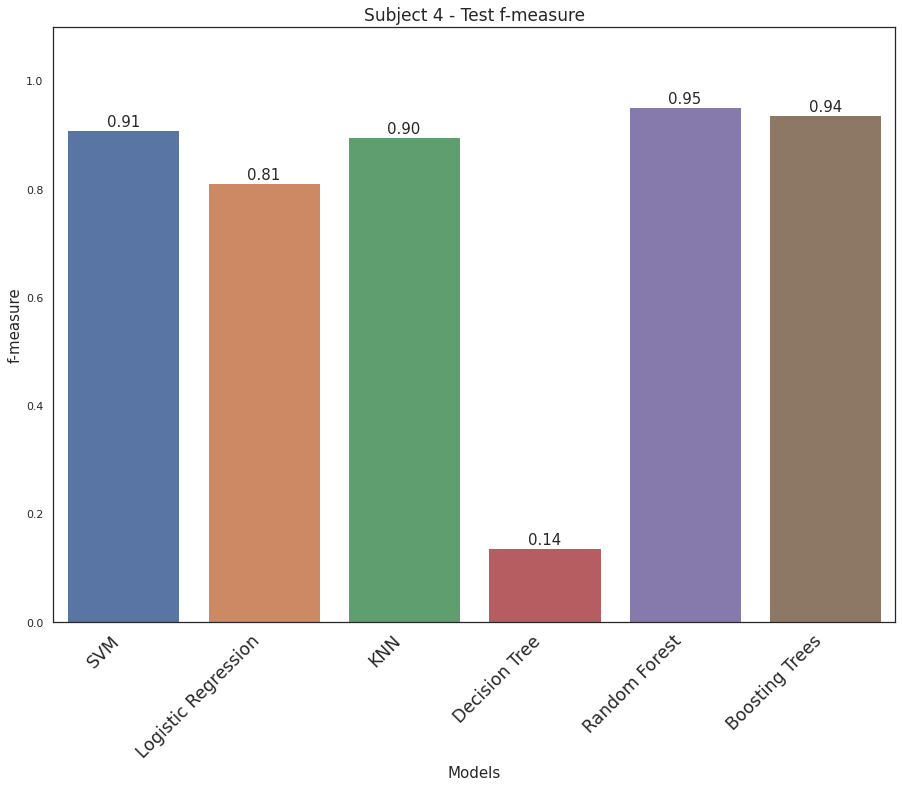

In [384]:
f_measure = [svmClfF, lrF, knnF, dtF, rfF, xgbClfF]
barPlot(f_measure, 'Subject 4 - Test f-measure', 'f-measure')

## Weighted Voting

### 3 WV

In [385]:
clf = [xgbClf, svmClf, knn]
weights = [xgbClfValAcc, svmClfValAcc, knnValAcc]
pred = WeightedVotingClassification(clf, weights)
s4_3wv = accuracy_score(df_testY, pred)
s4_3wv

0.8833333333333333

### 4 WV

In [387]:
clf = [xgbClf, svmClf, knn, rf]
weights = [xgbClfValAcc, svmClfValAcc, knnValAcc, rfValAcc]
pred = WeightedVotingClassification(clf, weights)
s4_4wv = accuracy_score(df_testY, pred)
s4_4wv

0.9166666666666666

### 5 WV

In [388]:
clf = [xgbClf, svmClf, knn, rf, dt]
weights = [xgbClfValAcc, svmClfValAcc, knnValAcc, rfValAcc, dtValAcc]
pred = WeightedVotingClassification(clf, weights)
s4_5wv = accuracy_score(df_testY, pred)
s4_5wv

0.9166666666666666

## Majority Voting

### 3 MV

In [394]:
clf = [xgbClf, svmClf, knn]
pred = MajorityVotingClassification(clf)
s4_3mv = accuracy_score(df_testY, pred)
s4_3mv

0.9166666666666666

### 4 MV

In [390]:
clf = [xgbClf, svmClf, knn, rf]
pred = MajorityVotingClassification(clf)
s4_4mv = accuracy_score(df_testY, pred)
s4_4mv

0.95

### 5 MV

In [395]:
clf = [xgbClf, svmClf, knn, rf, dt]
pred = MajorityVotingClassification(clf)
s4_5mv = accuracy_score(df_testY, pred)
s4_5mv

0.9333333333333333

## Unanimous Voting

### 3 UV

In [600]:
clf = [xgbClf, svmClf, knn]
pred = UnanimousVotingClassification(clf)
s4_3uv = accuracy_score(df_testY, pred)
s4_3uv

0.95

### 4 UV

In [396]:
clf = [xgbClf, svmClf, knn, rf]
pred = UnanimousVotingClassification(clf)
s4_4uv = accuracy_score(df_testY, pred)
s4_4uv

0.95

### 5 UV

In [402]:
clf = [xgbClf, svmClf, knn, rf, dt]
pred = UnanimousVotingClassification(clf)
s4_5uv = accuracy_score(df_testY, pred)
s4_5uv

0.5166666666666667

# Fold 5

In [443]:
df_train = pd.read_csv('Fold_5_Train_Dataset.csv', header=None) 
df_test = pd.read_csv('Fold_5_Test_Dataset.csv', header=None)

df_trainX = df_train.iloc[:,:-1]
df_trainY = df_train.iloc[:,-1]
df_testX = df_test.iloc[:,:-1]
df_testY = df_test.iloc[:,-1]

df_trainY[df_trainY==1] = 0
df_trainY[df_trainY==2] = 1
df_testY[df_testY==1] = 0
df_testY[df_testY==2] = 1

## Train Validation Sets

In [444]:
df_train_master, df_val_master = createMasterTrainVal(5)
df_trainX_master, df_trainY_master, df_valX_master, df_valY_master = getMasterTrainValXY(5, df_train_master, df_val_master)

## Hyperparameter Tuning

### SVM

In [ ]:
hyperparameterSearchSVM(5)

Iteration 1 C = 0.1 gamma = 1
Accuracy is: 0.5185185185185186
F-measure: 0.2783793408793409

Iteration 2 C = 0.1 gamma = 0.1
Accuracy is: 0.5833333333333333
F-measure: 0.616215477649429

Iteration 3 C = 0.1 gamma = 0.01
Accuracy is: 0.4537037037037038
F-measure: 0.5255436917543621

Iteration 4 C = 0.1 gamma = 0.001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 5 C = 0.1 gamma = 0.0001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 6 C = 1 gamma = 1
Accuracy is: 0.6462962962962963
F-measure: 0.4763410740640343

Iteration 7 C = 1 gamma = 0.1
Accuracy is: 0.6407407407407407
F-measure: 0.5811609065859769

Iteration 8 C = 1 gamma = 0.01
Accuracy is: 0.5759259259259258
F-measure: 0.6095748928552942

Iteration 9 C = 1 gamma = 0.001
Accuracy is: 0.45000000000000007
F-measure: 0.14913252122554446

Iteration 10 C = 1 gamma = 0.0001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 11 C = 10 gamma = 1
Accuracy is: 0.7277777777777779
F-measure: 0.6546975739166068

It

{'0.10.0001': (0.0, 0.4444444444444444),
 '0.10.001': (0.0, 0.4444444444444444),
 '0.10.01': (0.5255436917543621, 0.4537037037037038),
 '0.10.1': (0.616215477649429, 0.5833333333333333),
 '0.11': (0.2783793408793409, 0.5185185185185186),
 '10.0001': (0.0, 0.4444444444444444),
 '10.001': (0.14913252122554446, 0.45000000000000007),
 '10.01': (0.6095748928552942, 0.5759259259259258),
 '10.1': (0.5811609065859769, 0.6407407407407407),
 '100.0001': (0.0, 0.42962962962962964),
 '100.001': (0.6089956537334995, 0.5851851851851851),
 '100.01': (0.5744261098813879, 0.624074074074074),
 '100.1': (0.529669853199265, 0.6407407407407407),
 '1000.0001': (0.5293433189933079, 0.55),
 '1000.001': (0.4627659433350103, 0.5629629629629629),
 '1000.01': (0.41788766788766785, 0.5333333333333334),
 '1000.1': (0.4647990505817122, 0.6203703703703705),
 '10000.0001': (0.3740692015339902, 0.5148148148148148),
 '10000.001': (0.4070969460061739, 0.512962962962963),
 '10000.01': (0.2735503993624946, 0.47962962962962

### Logistic Regression

In [ ]:
hyperparameterSearchLR(5)

l20.23357214690901212liblinearFalse (0.6385127916068719, 0.6259259259259259)


{'l10.0001liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0001liblinearTrue': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearFalse': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearTrue': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearFalse': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearTrue': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearFalse': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearTrue': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearFalse': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearTrue': (0.0, 0.4444444444444444),
 'l10.08858667904100823liblinearFalse': (0.5434467217075913,
  0.555555555555

### KNN

In [ ]:
hyperparameterSearchKNN(5)

20distanceball_tree302 (0.7825361922508234, 0.7685185185185186)


{'10distanceauto1001': (0.646683459008529, 0.7092592592592593),
 '10distanceauto152': (0.6441826691826692, 0.7037037037037037),
 '10distanceauto602': (0.6441826691826692, 0.7037037037037037),
 '10distanceball_tree152': (0.6457366707366707, 0.7055555555555556),
 '10distanceball_tree452': (0.6457366707366707, 0.7055555555555556),
 '10distancebrute1001': (0.646683459008529, 0.7092592592592593),
 '10distancebrute451': (0.646683459008529, 0.7092592592592593),
 '10distancebrute751': (0.646683459008529, 0.7092592592592593),
 '10distancebrute752': (0.6441826691826692, 0.7037037037037037),
 '10distancekd_tree302': (0.6441826691826692, 0.7037037037037037),
 '10uniformauto1001': (0.11464070308742966, 0.42037037037037034),
 '10uniformauto1002': (0.293762935868199, 0.5111111111111112),
 '10uniformauto152': (0.293762935868199, 0.5111111111111112),
 '10uniformauto451': (0.11464070308742966, 0.42037037037037034),
 '10uniformball_tree1001': (0.11597505808032126, 0.4259259259259259),
 '10uniformball_tre

### Decision Tree

In [214]:
hyperparameterSearchDecisionTree(5)

giniauto10058None0.1best (0.6176827867656182, 0.6777777777777779)


{'entropyNone1025300.4random': (0.19357245444201968, 0.412962962962963),
 'entropyNone1029500.5best': (0.0, 0.4444444444444444),
 'entropyNone20106900.3random': (0.12344877344877345, 0.4111111111111111),
 'entropyNone2024100.3random': (0.12344877344877345, 0.4111111111111111),
 'entropyNone3059700.3best': (0.12344877344877345, 0.4111111111111111),
 'entropyNone40510900.4best': (0.19357245444201968, 0.412962962962963),
 'entropyNone5027700.1random': (0.44072868818736666, 0.6092592592592594),
 'entropyNone5028None0.5random': (0.0, 0.4444444444444444),
 'entropyNone5055300.1random': (0.44072868818736666, 0.6092592592592594),
 'entropyNone60109600.5random': (0.0, 0.4444444444444444),
 'entropyNone6024900.4random': (0.19357245444201968, 0.412962962962963),
 'entropyNone6028500.3best': (0.12344877344877345, 0.4111111111111111),
 'entropyNone7051100.1best': (0.44072868818736666, 0.6092592592592594),
 'entropyNone80104800.4random': (0.19357245444201968, 0.412962962962963),
 'entropyNone8051060

### Random Forest

In [ ]:
hyperparameterSearchRandomForest(5)

200autoNone52False (0.6780936492911548, 0.7574074074074074)


{'1000auto40104False': (0.676891137614882, 0.7574074074074074),
 '1200auto4022False': (0.6745775529174144, 0.7537037037037037),
 '1600log22051False': (0.6763309135252461, 0.7555555555555555),
 '1800sqrt4054False': (0.6774853146796471, 0.7592592592592593),
 '2000sqrt10024True': (0.6752076359313802, 0.7518518518518519),
 '2000sqrt10052True': (0.6762969605501167, 0.7555555555555555),
 '2000sqrt1021True': (0.673983375852649, 0.7518518518518519),
 '200autoNone52False': (0.6780936492911548, 0.7574074074074074),
 '200log24051True': (0.6757367364604807, 0.7537037037037037),
 '400autoNone51True': (0.6757367364604807, 0.7537037037037037),
 '400log211024True': (0.6684315626479749, 0.7462962962962963),
 '400sqrt5054False': (0.6774853146796471, 0.7592592592592593),
 '400sqrt60102True': (0.6719939838333467, 0.75),
 '600auto6021False': (0.6745681777593373, 0.7537037037037037),
 '600log220104True': (0.6714337597437109, 0.748148148148148),
 '600sqrt3024False': (0.676891137614882, 0.7574074074074074),
 

### Xgboost

In [ ]:
hyperparameterSearchXgb(5)

2000100.00030.30.80.80.01 (0.7495015739479929, 0.788888888888889)


{'10001100.030.00.80.90.01': (0.6821115244009366, 0.7629629629629631),
 '1000300.0030.20.60.61': (0.6681909043308716, 0.7444444444444445),
 '1000300.0030.40.80.9100': (0.0, 0.4444444444444444),
 '1000400.00010.10.60.61': (0.377547349463858, 0.5962962962962963),
 '1200100.0030.40.70.61e-05': (0.6791896050919616, 0.7611111111111112),
 '1200200.0030.10.70.90.01': (0.6757319540718156, 0.7574074074074075),
 '1200400.010.00.70.70.01': (0.6821115244009366, 0.7629629629629631),
 '1200800.30.00.70.71e-05': (0.6782379284879116, 0.7574074074074075),
 '1400300.010.30.70.61': (0.6810107862114646, 0.7629629629629631),
 '1400600.0030.10.90.61e-05': (0.676900512772959, 0.7574074074074074),
 '1400700.30.00.60.61': (0.6826963263076249, 0.7648148148148148),
 '1400900.30.10.70.80.01': (0.670513864186416, 0.7481481481481481),
 '1600100.010.40.70.60.1': (0.6804166091466993, 0.7611111111111112),
 '16001000.010.00.70.90.1': (0.6821115244009366, 0.7629629629629631),
 '1600700.0030.00.60.90.1': (0.6774946898377

## SVM

Accuracy is: 0.9833333333333333
f-measure: 0.9836065573770492
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



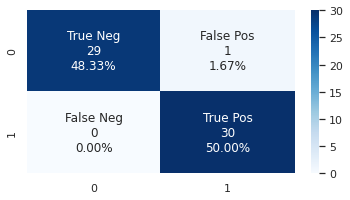

In [445]:
svmClfValF = 0.6546975739166068
svmClfValAcc = 0.7277777777777779
svmClf = svm.SVC(C = 10, gamma = 1, kernel='rbf', probability=True)
svmClfAcc, svmClfF = userModel(svmClf)

## Logistic Regression

Accuracy is: 0.35
f-measure: 0.13333333333333333
              precision    recall  f1-score   support

           0       0.40      0.60      0.48        30
           1       0.20      0.10      0.13        30

    accuracy                           0.35        60
   macro avg       0.30      0.35      0.31        60
weighted avg       0.30      0.35      0.31        60



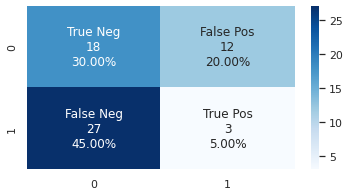

In [446]:
lrValF = 0.6385127916068719
lrValAcc = 0.6259259259259259
lr = LogisticRegression(penalty='l2', C=0.23357214690901212, solver='liblinear', fit_intercept=False)
lrAcc, lrF = userModel(lr)

## KNN

Accuracy is: 0.95
f-measure: 0.9523809523809523
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.91      1.00      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



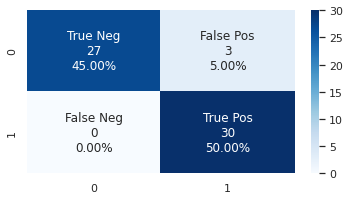

In [447]:
knnValF = 0.7825361922508234
knnValAcc = 0.7685185185185186
knn = KNeighborsClassifier(n_neighbors=20, weights='distance', algorithm='ball_tree', leaf_size=30, p=2)
knnAcc, knnF = userModel(knn)

## Decision Tree

Accuracy is: 0.5166666666666667
f-measure: 0.17142857142857143
              precision    recall  f1-score   support

           0       0.51      0.93      0.66        30
           1       0.60      0.10      0.17        30

    accuracy                           0.52        60
   macro avg       0.55      0.52      0.42        60
weighted avg       0.55      0.52      0.42        60



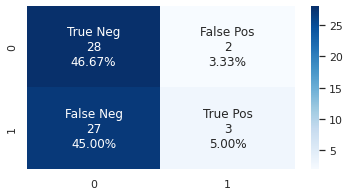

In [448]:
dtValF = 0.6176827867656182
dtValAcc = 0.6777777777777779
dt = DecisionTreeClassifier(criterion='gini', max_features='auto', max_depth=100, min_samples_split=5, min_samples_leaf=8, 
                            max_leaf_nodes=None, min_weight_fraction_leaf=0.1, splitter='best')
dtAcc, dtF = userModel(dt)

## Random Forest

Accuracy is: 0.9833333333333333
f-measure: 0.9836065573770492
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



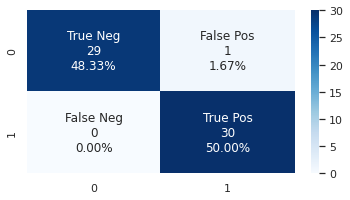

In [449]:
rfValF = 0.6780936492911548
rfValAcc = 0.7574074074074074
rf = RandomForestClassifier(n_estimators=200, max_features='auto', max_depth=None, min_samples_split=5, min_samples_leaf=2, bootstrap=False)
rfAcc, rfF = userModel(rf)

## Boosting

Accuracy is: 0.9833333333333333
f-measure: 0.9836065573770492
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



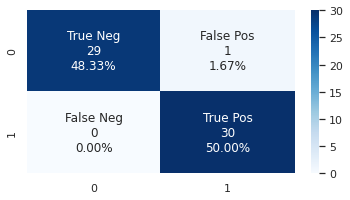

In [450]:
xgbClfValF = 0.7495015739479929
xgbClfValAcc = 0.788888888888889
xgbClf = xgb.XGBClassifier(n_estimators=2000, max_depth=10, learning_rate=0.0003, gamma=0.3, subsample=0.8, colsample_bytree=0.8,  
                           reg_alpha=0.01)
xgbClfAcc, xgbClfF = userModel(xgbClf)

## Plots

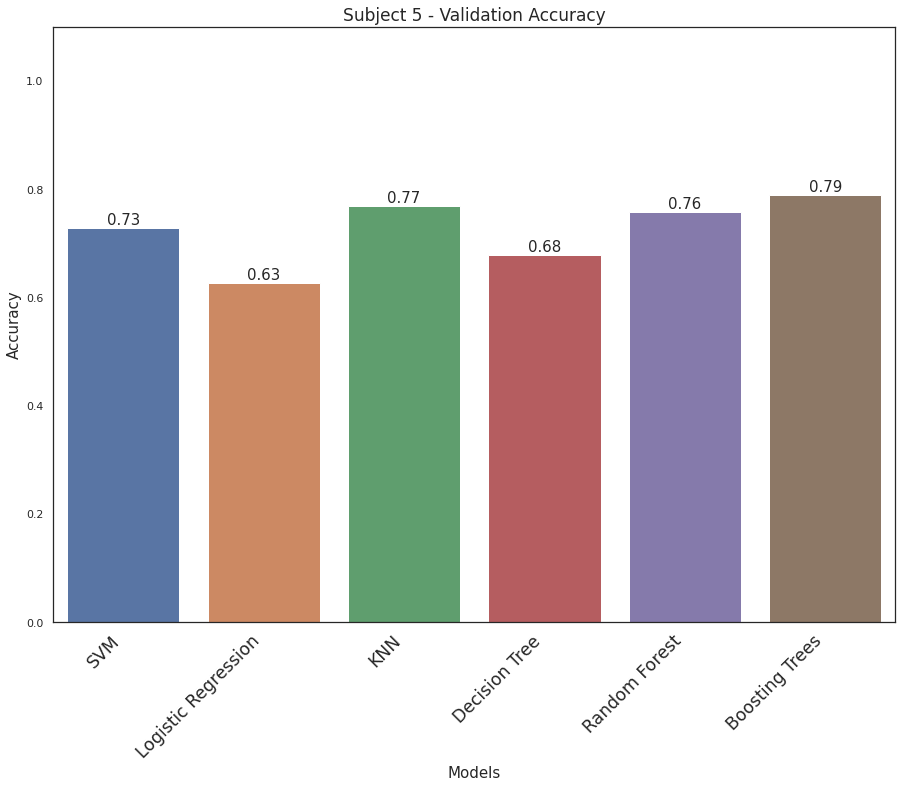

In [415]:
accuracies = [svmClfValAcc, lrValAcc, knnValAcc, dtValAcc, rfValAcc, xgbClfValAcc]
barPlot(accuracies, 'Subject 5 - Validation Accuracy', 'Accuracy')

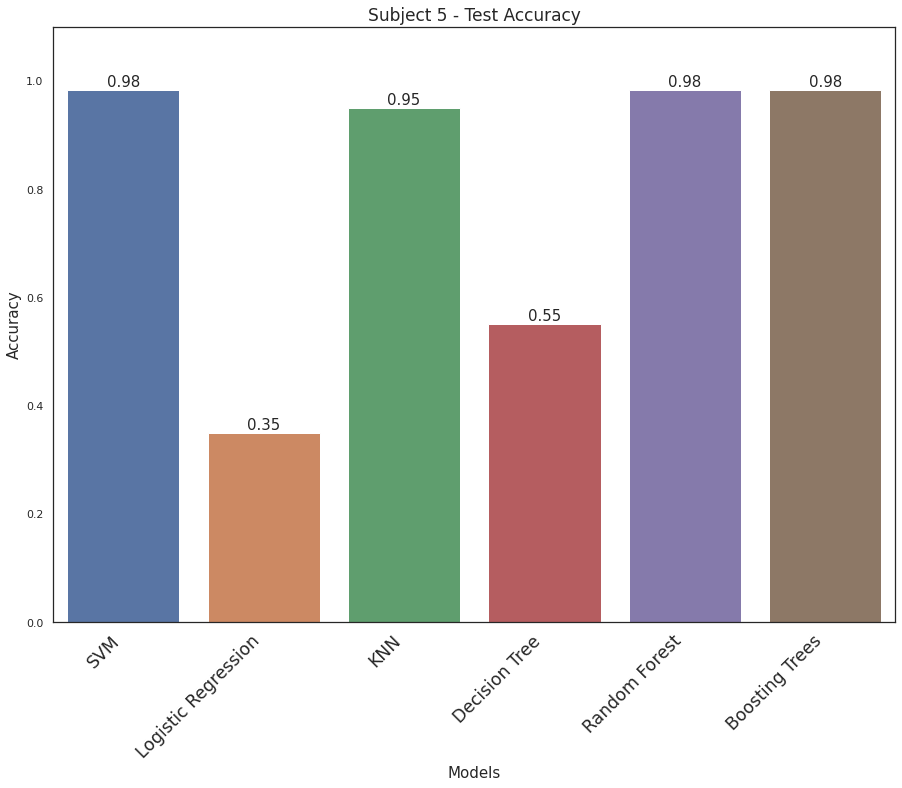

In [416]:
accuracies = [svmClfAcc, lrAcc, knnAcc, dtAcc, rfAcc, xgbClfAcc]
barPlot(accuracies, 'Subject 5 - Test Accuracy', 'Accuracy')

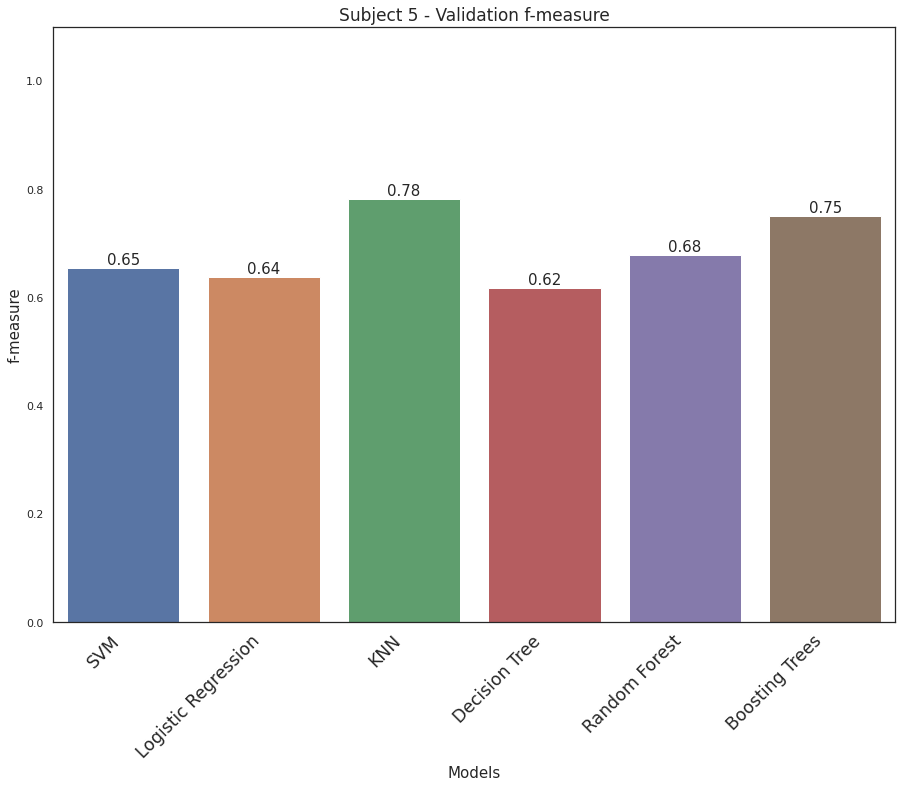

In [417]:
f_measure = [svmClfValF, lrValF, knnValF, dtValF, rfValF, xgbClfValF]
barPlot(f_measure, 'Subject 5 - Validation f-measure', 'f-measure')

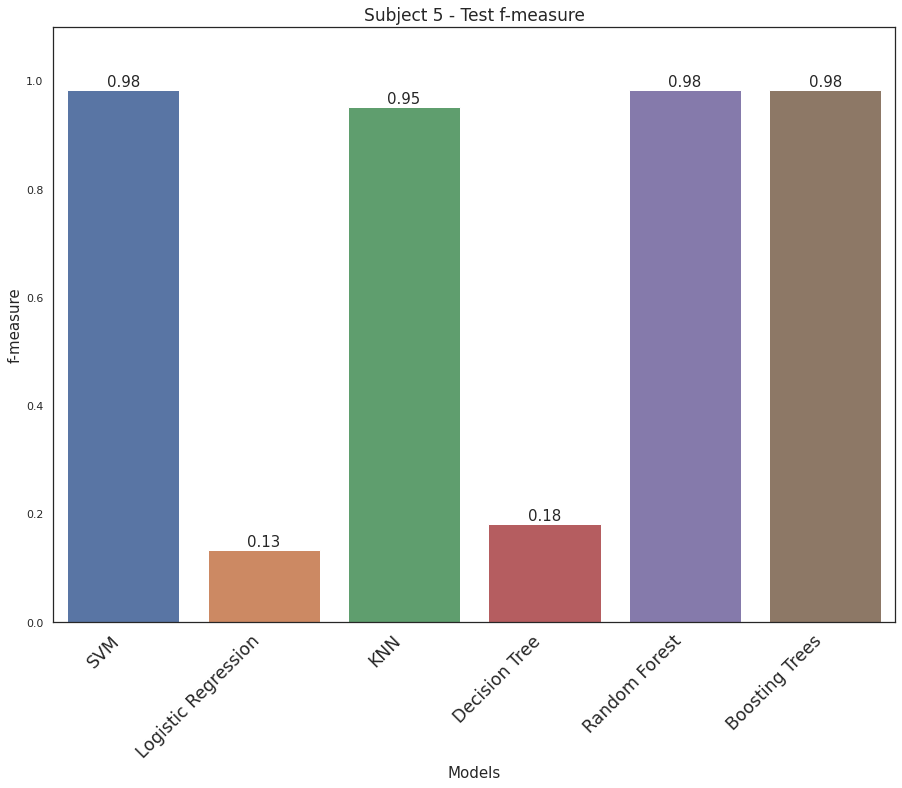

In [418]:
f_measure = [svmClfF, lrF, knnF, dtF, rfF, xgbClfF]
barPlot(f_measure, 'Subject 5 - Test f-measure', 'f-measure')

## Weighted Voting

### 3 WV

In [419]:
clf = [xgbClf, knn, rf]
weights = [xgbClfValAcc, knnValAcc, rfValAcc]
pred = WeightedVotingClassification(clf, weights)
s5_3wv = accuracy_score(df_testY, pred)
s5_3wv

0.9833333333333333

### 4 WV

In [420]:
clf = [xgbClf, knn, svmClf, rf]
weights = [xgbClfValAcc, knnValAcc, svmClfValAcc, rfValAcc]
pred = WeightedVotingClassification(clf, weights)
s5_4wv = accuracy_score(df_testY, pred)
s5_4wv

0.9833333333333333

### 5 WV

In [421]:
clf = [xgbClf, knn, svmClf, rf, lr]
weights = [xgbClfValAcc, knnValAcc, svmClfValAcc, rfValAcc, lrValAcc]
pred = WeightedVotingClassification(clf, weights)
s5_5wv = accuracy_score(df_testY, pred)
s5_5wv

0.9833333333333333

## Majority Voting

### 3 MV

In [423]:
clf = [xgbClf, knn, rf]
pred = MajorityVotingClassification(clf)
s5_3mv = accuracy_score(df_testY, pred)
s5_3mv

0.9833333333333333

### 4 MV

In [425]:
clf = [xgbClf, knn, svmClf, rf]
pred = MajorityVotingClassification(clf)
s5_4mv = accuracy_score(df_testY, pred)
s5_4mv

0.9833333333333333

### 5 MV

In [426]:
clf = [xgbClf, knn, svmClf, rf, lr]
pred = MajorityVotingClassification(clf)
s5_5mv = accuracy_score(df_testY, pred)
s5_5mv

0.9833333333333333

## Unanimous Voting

### 3 UV

In [451]:
clf = [xgbClf, knn, svmClf]
pred = UnanimousVotingClassification(clf)
s5_3uv = accuracy_score(df_testY, pred)
s5_3uv

0.9833333333333333

### 4 UV

In [452]:
clf = [xgbClf, knn, svmClf, rf]
pred = UnanimousVotingClassification(clf)
s5_4uv =accuracy_score(df_testY, pred)
s5_4uv

0.9833333333333333

### 5 UV

In [453]:
clf = [xgbClf, knn, svmClf, rf, lr]
pred = UnanimousVotingClassification(clf)
s5_5uv =accuracy_score(df_testY, pred)
s5_5uv

0.55

# Fold 6

In [456]:
df_train = pd.read_csv('Fold_6_Train_Dataset.csv', header=None) 
df_test = pd.read_csv('Fold_6_Test_Dataset.csv', header=None)

df_trainX = df_train.iloc[:,:-1]
df_trainY = df_train.iloc[:,-1]
df_testX = df_test.iloc[:,:-1]
df_testY = df_test.iloc[:,-1]

df_trainY[df_trainY==1] = 0
df_trainY[df_trainY==2] = 1
df_testY[df_testY==1] = 0
df_testY[df_testY==2] = 1

## Train Validation Sets

In [457]:
df_train_master, df_val_master = createMasterTrainVal(6)
df_trainX_master, df_trainY_master, df_valX_master, df_valY_master = getMasterTrainValXY(6, df_train_master, df_val_master)

## Hyperparameter Tuning

### SVM

In [ ]:
hyperparameterSearchSVM(6)

Iteration 1 C = 0.1 gamma = 1
Accuracy is: 0.4833333333333333
F-measure: 0.1933654775760039

Iteration 2 C = 0.1 gamma = 0.1
Accuracy is: 0.5425925925925925
F-measure: 0.5415528808094168

Iteration 3 C = 0.1 gamma = 0.01
Accuracy is: 0.46851851851851856
F-measure: 0.5482873921463616

Iteration 4 C = 0.1 gamma = 0.001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 5 C = 0.1 gamma = 0.0001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 6 C = 1 gamma = 1
Accuracy is: 0.6425925925925926
F-measure: 0.46153829473501606

Iteration 7 C = 1 gamma = 0.1
Accuracy is: 0.6518518518518518
F-measure: 0.5898099220921015

Iteration 8 C = 1 gamma = 0.01
Accuracy is: 0.5314814814814814
F-measure: 0.5347419903550826

Iteration 9 C = 1 gamma = 0.001
Accuracy is: 0.4629629629629629
F-measure: 0.5270136467346851

Iteration 10 C = 1 gamma = 0.0001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 11 C = 10 gamma = 1
Accuracy is: 0.7314814814814815
F-measure: 0.6463200305760739

I

{'0.10.0001': (0.0, 0.4444444444444444),
 '0.10.001': (0.0, 0.4444444444444444),
 '0.10.01': (0.5482873921463616, 0.46851851851851856),
 '0.10.1': (0.5415528808094168, 0.5425925925925925),
 '0.11': (0.1933654775760039, 0.4833333333333333),
 '10.0001': (0.0, 0.4444444444444444),
 '10.001': (0.5270136467346851, 0.4629629629629629),
 '10.01': (0.5347419903550826, 0.5314814814814814),
 '10.1': (0.5898099220921015, 0.6518518518518518),
 '100.0001': (0.011904761904761904, 0.3907407407407407),
 '100.001': (0.4709763175498815, 0.5092592592592592),
 '100.01': (0.4928477931539781, 0.5944444444444444),
 '100.1': (0.5306227520201663, 0.6407407407407407),
 '1000.0001': (0.4720857321642025, 0.5425925925925926),
 '1000.001': (0.42891918620643704, 0.5574074074074074),
 '1000.01': (0.5852286727466067, 0.6425925925925926),
 '1000.1': (0.46733826938430517, 0.6222222222222222),
 '10000.0001': (0.4377715618833807, 0.5648148148148149),
 '10000.001': (0.569669959846876, 0.6203703703703703),
 '10000.01': (0.4

### Logistic Regression

In [ ]:
hyperparameterSearchLR(6)

l20.23357214690901212liblinearFalse (0.6313635751857931, 0.6129629629629629)


{'l10.0001liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0001liblinearTrue': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearFalse': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearTrue': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearFalse': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearTrue': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearFalse': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearTrue': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearFalse': (0.0, 0.38518518518518513),
 'l10.03359818286283781liblinearTrue': (0.0, 0.38518518518518513),
 'l10.08858667904100823liblinearFalse': (0.46800288067550433,
  0.498148148

### KNN

In [ ]:
hyperparameterSearchKNN(6)

20distanceball_tree302 (0.7872875046545571, 0.7722222222222223)


{'10distanceauto1001': (0.6324995783834937, 0.701851851851852),
 '10distanceauto152': (0.6486846550270084, 0.7111111111111111),
 '10distanceauto602': (0.6486846550270084, 0.7111111111111111),
 '10distanceball_tree152': (0.6501922684749206, 0.712962962962963),
 '10distanceball_tree452': (0.6486846550270084, 0.7111111111111111),
 '10distancebrute1001': (0.6324995783834937, 0.701851851851852),
 '10distancebrute451': (0.6324995783834937, 0.701851851851852),
 '10distancebrute751': (0.6324995783834937, 0.701851851851852),
 '10distancebrute752': (0.6486846550270084, 0.7111111111111111),
 '10distancekd_tree302': (0.6486846550270084, 0.7111111111111111),
 '10uniformauto1001': (0.19560613678260738, 0.461111111111111),
 '10uniformauto1002': (0.21369251899979863, 0.4722222222222222),
 '10uniformauto152': (0.21369251899979863, 0.4722222222222222),
 '10uniformauto451': (0.19560613678260738, 0.461111111111111),
 '10uniformball_tree1001': (0.21227280344927404, 0.46851851851851856),
 '10uniformball_tre

### Decision Tree

In [ ]:
hyperparameterSearchDecisionTree(6)

giniauto20103800.1best (0.44992150022348454, 0.5833333333333334)


{'entropyNone1025300.4random': (0.11076555023923446, 0.3574074074074074),
 'entropyNone1029500.5best': (0.0, 0.4444444444444444),
 'entropyNone20106900.3random': (0.1452991452991453, 0.43333333333333335),
 'entropyNone2024100.3random': (0.1452991452991453, 0.43333333333333335),
 'entropyNone3059700.3best': (0.1452991452991453, 0.43333333333333335),
 'entropyNone40510900.4best': (0.11076555023923446, 0.3574074074074074),
 'entropyNone5027700.1random': (0.19387943699509394, 0.43333333333333335),
 'entropyNone5028None0.5random': (0.0, 0.4444444444444444),
 'entropyNone5055300.1random': (0.19387943699509394, 0.43333333333333335),
 'entropyNone60109600.5random': (0.0, 0.4444444444444444),
 'entropyNone6024900.4random': (0.11076555023923446, 0.3574074074074074),
 'entropyNone6028500.3best': (0.1452991452991453, 0.43333333333333335),
 'entropyNone7051100.1best': (0.19387943699509394, 0.43333333333333335),
 'entropyNone80104800.4random': (0.11076555023923446, 0.3574074074074074),
 'entropyNone

### Random Forest

In [ ]:
hyperparameterSearchRandomForest(6)

200log24051True (0.6642719589988763, 0.7592592592592592)


{'1000auto40104False': (0.6625092232329676, 0.7574074074074074),
 '1200auto4022False': (0.6625092232329676, 0.7574074074074074),
 '1600log22051False': (0.6608024473326433, 0.7555555555555555),
 '1800sqrt4054False': (0.6625092232329676, 0.7574074074074074),
 '2000sqrt10024True': (0.6590930483136197, 0.7518518518518519),
 '2000sqrt10052True': (0.6625092232329676, 0.7574074074074074),
 '2000sqrt1021True': (0.6625092232329676, 0.7574074074074074),
 '200autoNone52False': (0.6575464440766399, 0.7518518518518519),
 '200log24051True': (0.6642719589988763, 0.7592592592592592),
 '400autoNone51True': (0.6625092232329676, 0.7574074074074074),
 '400log211024True': (0.6590930483136197, 0.7537037037037037),
 '400sqrt5054False': (0.6608024473326433, 0.7555555555555555),
 '400sqrt60102True': (0.6608024473326433, 0.7555555555555555),
 '600auto6021False': (0.662565183098552, 0.7574074074074074),
 '600log220104True': (0.6590930483136197, 0.7537037037037037),
 '600sqrt3024False': (0.6625092232329676, 0.757

### Xgboost

In [ ]:
hyperparameterSearchXgb(6)

1400900.30.10.70.80.01 (0.6787102666089516, 0.7574074074074075)


{'10001100.030.00.80.90.01': (0.6625185983910445, 0.7574074074074075),
 '1000300.0030.20.60.61': (0.6550193509689427, 0.7444444444444445),
 '1000300.0030.40.80.9100': (0.0, 0.4444444444444444),
 '1000400.00010.10.60.61': (0.2897726214987546, 0.55),
 '1200100.0030.40.70.61e-05': (0.6613500396899012, 0.7574074074074075),
 '1200200.0030.10.70.90.01': (0.6555354758390812, 0.75),
 '1200400.010.00.70.70.01': (0.6648755112217186, 0.7611111111111112),
 '1200800.30.00.70.71e-05': (0.6787008914508745, 0.7574074074074075),
 '1400300.010.30.70.61': (0.6631246361018969, 0.7592592592592593),
 '1400600.0030.10.90.61e-05': (0.6579483485353397, 0.7537037037037038),
 '1400700.30.00.60.61': (0.6642719589988763, 0.7592592592592593),
 '1400900.30.10.70.80.01': (0.6787102666089516, 0.7574074074074075),
 '1600100.010.40.70.60.1': (0.6631805959674814, 0.7592592592592593),
 '16001000.010.00.70.90.1': (0.6642813341569532, 0.7592592592592593),
 '1600700.0030.00.60.90.1': (0.6596551244356639, 0.7537037037037038),

## SVM

Accuracy is: 0.9333333333333333
f-measure: 0.9375
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        30
           1       0.88      1.00      0.94        30

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



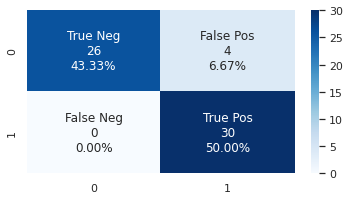

In [458]:
svmClfValF = 0.6588284600237547
svmClfValAcc = 0.7203703703703704
svmClf = svm.SVC(C = 1000, gamma = 0.1, kernel='rbf', probability=True)
svmClfAcc, svmClfF = userModel(svmClf)

## Logistic Regression

Accuracy is: 0.7666666666666667
f-measure: 0.8108108108108109
              precision    recall  f1-score   support

           0       1.00      0.53      0.70        30
           1       0.68      1.00      0.81        30

    accuracy                           0.77        60
   macro avg       0.84      0.77      0.75        60
weighted avg       0.84      0.77      0.75        60



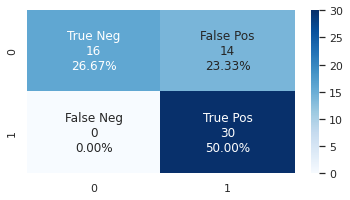

In [459]:
lrValF = 0.6313635751857931
lrValAcc = 0.6129629629629629
lr = LogisticRegression(penalty='l2', C=0.23357214690901212, solver='liblinear', fit_intercept=False)
lrAcc, lrF = userModel(lr)

## KNN

Accuracy is: 0.8166666666666667
f-measure: 0.8450704225352113
              precision    recall  f1-score   support

           0       1.00      0.63      0.78        30
           1       0.73      1.00      0.85        30

    accuracy                           0.82        60
   macro avg       0.87      0.82      0.81        60
weighted avg       0.87      0.82      0.81        60



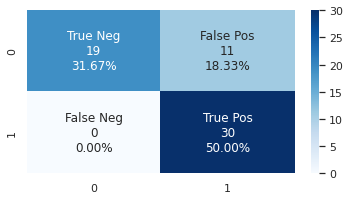

In [460]:
knnValF = 0.7872875046545571
knnValAcc = 0.7722222222222223
knn = KNeighborsClassifier(n_neighbors=20, weights='distance', algorithm='ball_tree', leaf_size=30, p=2)
knnAcc, knnF = userModel(knn)

## Decision Tree

Accuracy is: 0.36666666666666664
f-measure: 0.13636363636363638
              precision    recall  f1-score   support

           0       0.41      0.63      0.50        30
           1       0.21      0.10      0.14        30

    accuracy                           0.37        60
   macro avg       0.31      0.37      0.32        60
weighted avg       0.31      0.37      0.32        60



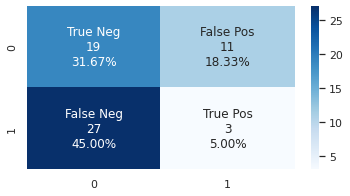

In [461]:
dtValF = 0.44992150022348454
dtValAcc = 0.5833333333333334
dt = DecisionTreeClassifier(criterion='gini', max_features='auto', max_depth=20, min_samples_split=10, min_samples_leaf=3, 
                            max_leaf_nodes=80, min_weight_fraction_leaf=0.1, splitter='best')
dtAcc, dtF = userModel(dt)

## Random Forest

Accuracy is: 0.95
f-measure: 0.9523809523809523
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.91      1.00      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



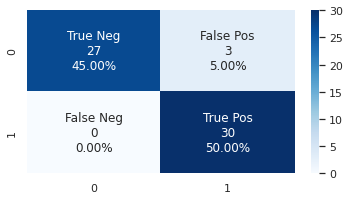

In [462]:
rfValF = 0.6642719589988763
rfValAcc = 0.7592592592592592
rf = RandomForestClassifier(n_estimators=200, max_features='log2', max_depth=40, min_samples_split=5, min_samples_leaf=1, bootstrap=True)
rfAcc, rfF = userModel(rf)

## Boosting

Accuracy is: 0.9666666666666667
f-measure: 0.967741935483871
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.94      1.00      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



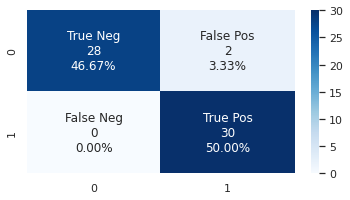

In [463]:
xgbClfValF = 0.6787102666089516
xgbClfValAcc = 0.7574074074074075
xgbClf = xgb.XGBClassifier(n_estimators=1400, max_depth=90, learning_rate=0.3, gamma=0.1, subsample=0.7, colsample_bytree=0.8,  
                           reg_alpha=0.01)
xgbClfAcc, xgbClfF = userModel(xgbClf)

## Plots

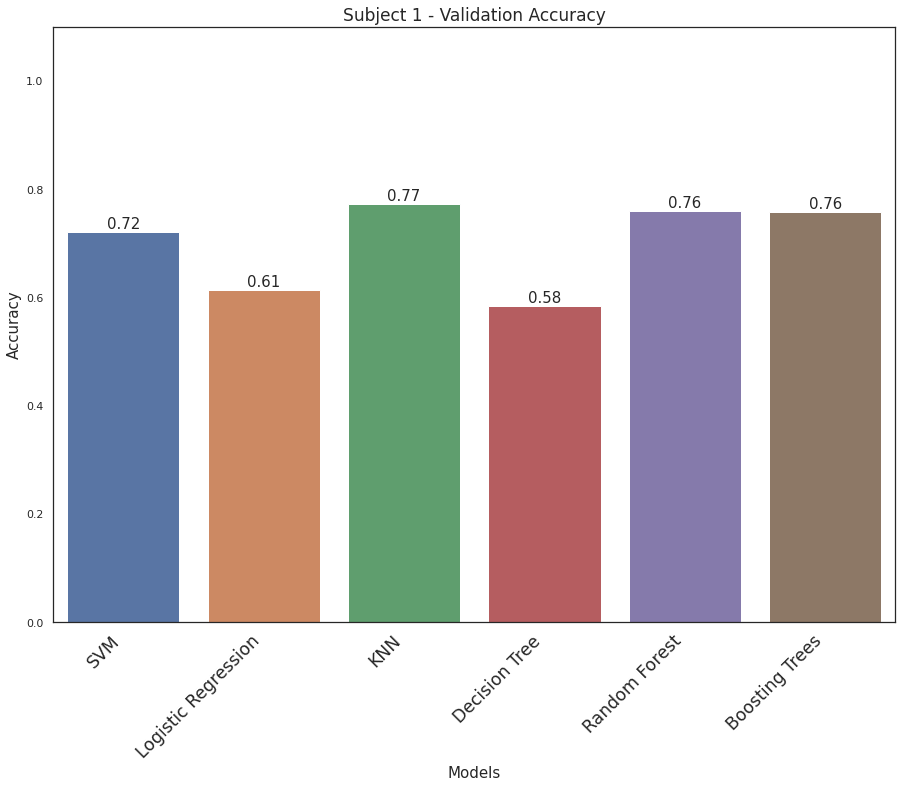

In [439]:
accuracies = [svmClfValAcc, lrValAcc, knnValAcc, dtValAcc, rfValAcc, xgbClfValAcc]
barPlot(accuracies, 'Subject 1 - Validation Accuracy', 'Accuracy')

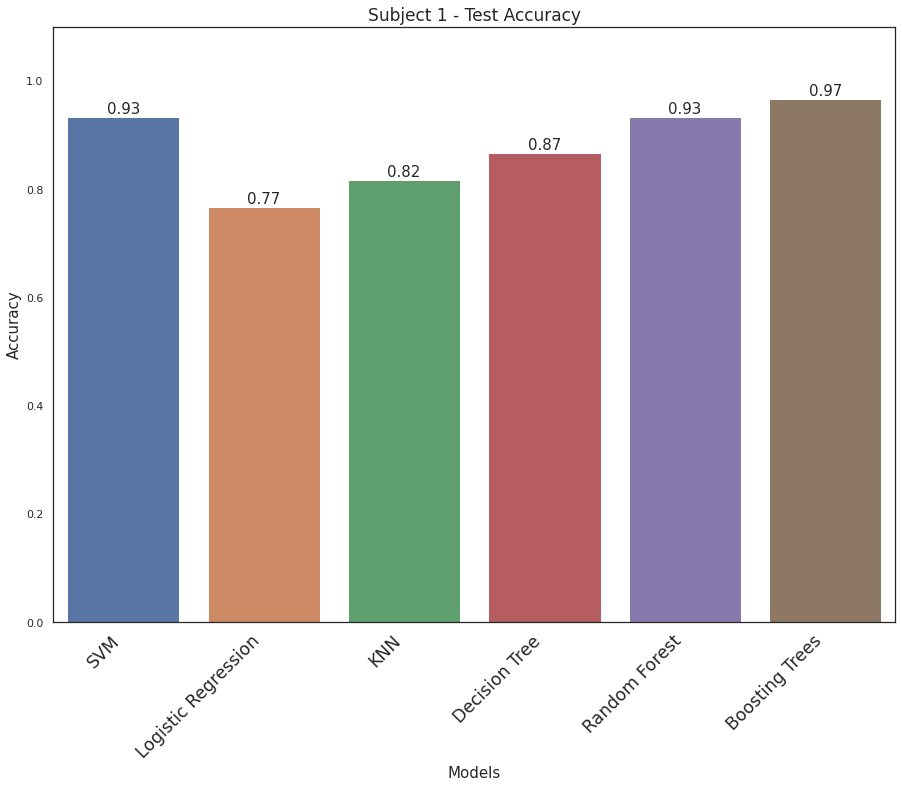

In [440]:
accuracies = [svmClfAcc, lrAcc, knnAcc, dtAcc, rfAcc, xgbClfAcc]
barPlot(accuracies, 'Subject 1 - Test Accuracy', 'Accuracy')

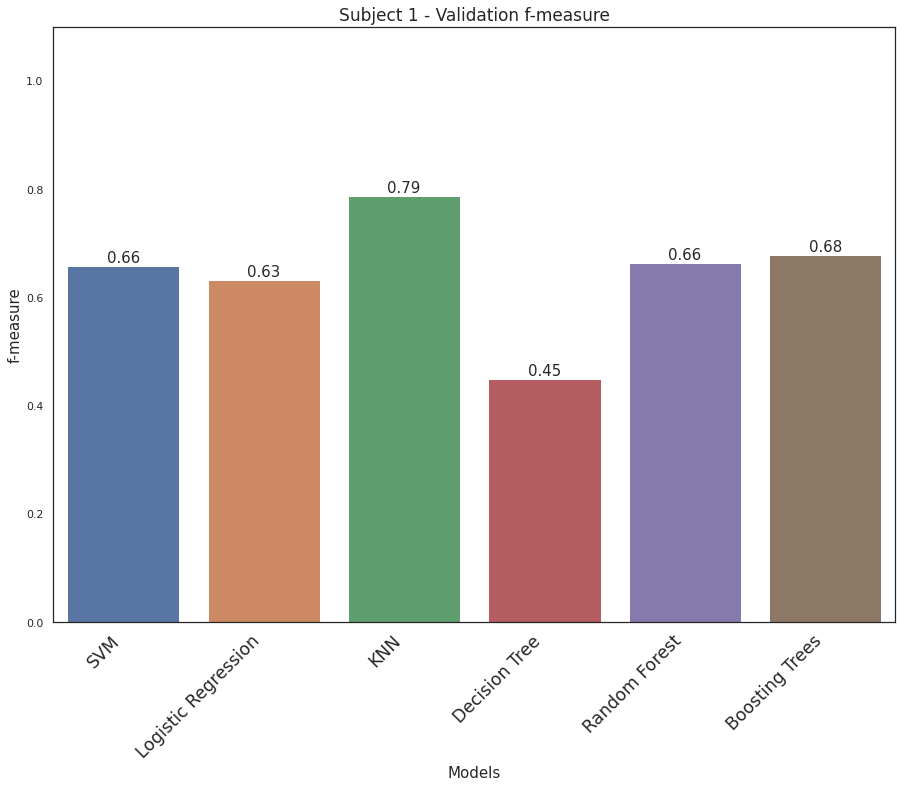

In [441]:
f_measure = [svmClfValF, lrValF, knnValF, dtValF, rfValF, xgbClfValF]
barPlot(f_measure, 'Subject 1 - Validation f-measure', 'f-measure')

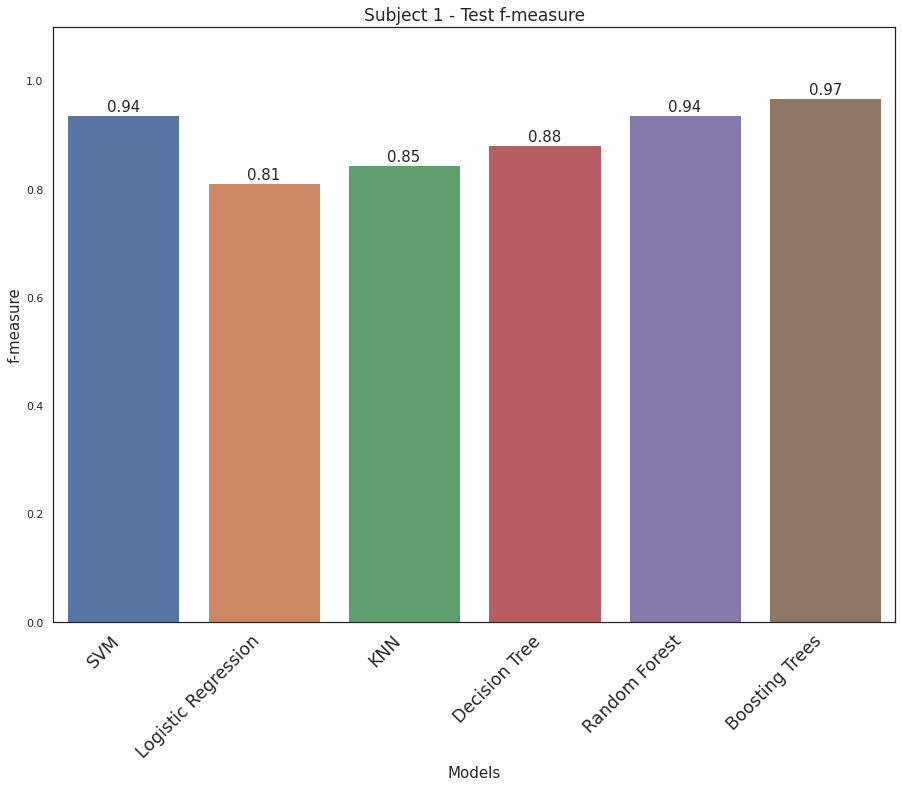

In [442]:
f_measure = [svmClfF, lrF, knnF, dtF, rfF, xgbClfF]
barPlot(f_measure, 'Subject 1 - Test f-measure', 'f-measure')

## Weighted Voting

### 3 WV

In [467]:
clf = [xgbClf, knn, svmClf]
weights = [xgbClfValAcc, knnValAcc, svmClfValAcc]
pred = WeightedVotingClassification(clf, weights)
s6_3wv = accuracy_score(df_testY, pred)
s6_3wv

0.9666666666666667

### 4 WV

In [468]:
clf = [xgbClf, knn, svmClf, rf]
weights = [xgbClfValAcc, knnValAcc, svmClfValAcc, rfValAcc]
pred = WeightedVotingClassification(clf, weights)
s6_4wv = accuracy_score(df_testY, pred)
s6_4wv

0.9666666666666667

### 5 WV

In [469]:
clf = [xgbClf, knn, svmClf, rf, lr]
weights = [xgbClfValAcc, knnValAcc, svmClfValAcc, rfValAcc, lrValAcc]
pred = WeightedVotingClassification(clf, weights)
s6_5wv = accuracy_score(df_testY, pred)
s6_5wv 

0.9666666666666667

## Majority Voting

### 3 MV

In [470]:
clf = [xgbClf, knn, svmClf]
pred = MajorityVotingClassification(clf)
s6_3mv = accuracy_score(df_testY, pred)
s6_3mv

0.9666666666666667

### 4 MV

In [471]:
clf = [xgbClf, knn, svmClf, rf]
pred = MajorityVotingClassification(clf)
s6_4mv = accuracy_score(df_testY, pred)
s6_4mv

0.9833333333333333

### 5 MV

In [472]:
clf = [xgbClf, knn, svmClf, rf, lr]
pred = MajorityVotingClassification(clf)
s6_5mv = accuracy_score(df_testY, pred)
s6_5mv

0.95

## Unanimous Voting

### 3 UV

In [473]:
clf = [xgbClf, knn, svmClf]
pred = UnanimousVotingClassification(clf)
s6_3uv = accuracy_score(df_testY, pred)
s6_3uv

0.9833333333333333

### 4 UV

In [474]:
clf = [xgbClf, knn, svmClf, rf]
pred = UnanimousVotingClassification(clf)
s6_4uv = accuracy_score(df_testY, pred)
s6_4uv 

0.9833333333333333

### 5 UV

In [475]:
clf = [xgbClf, knn, svmClf, rf, lr]
pred = UnanimousVotingClassification(clf)
s6_5uv = accuracy_score(df_testY, pred)
s6_5uv

0.9833333333333333

# Fold 7

In [476]:
df_train = pd.read_csv('Fold_7_Train_Dataset.csv', header=None) 
df_test = pd.read_csv('Fold_7_Test_Dataset.csv', header=None)

df_trainX = df_train.iloc[:,:-1]
df_trainY = df_train.iloc[:,-1]
df_testX = df_test.iloc[:,:-1]
df_testY = df_test.iloc[:,-1]

df_trainY[df_trainY==1] = 0
df_trainY[df_trainY==2] = 1
df_testY[df_testY==1] = 0
df_testY[df_testY==2] = 1

## Train Validation Sets

In [477]:
df_train_master, df_val_master = createMasterTrainVal(7)
df_trainX_master, df_trainY_master, df_valX_master, df_valY_master = getMasterTrainValXY(7, df_train_master, df_val_master)

## Hyperparameter Tuning

### SVM

In [36]:
hyperparameterSearchSVM(7)

Iteration 1 C = 0.1 gamma = 1
Accuracy is: 0.4462962962962963
F-measure: 0.11288293641234819

Iteration 2 C = 0.1 gamma = 0.1
Accuracy is: 0.5925925925925926
F-measure: 0.6143773300602375

Iteration 3 C = 0.1 gamma = 0.01
Accuracy is: 0.4759259259259259
F-measure: 0.5528933359056701

Iteration 4 C = 0.1 gamma = 0.001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 5 C = 0.1 gamma = 0.0001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 6 C = 1 gamma = 1
Accuracy is: 0.701851851851852
F-measure: 0.5699536400967803

Iteration 7 C = 1 gamma = 0.1
Accuracy is: 0.5537037037037038
F-measure: 0.4273240694293326

Iteration 8 C = 1 gamma = 0.01
Accuracy is: 0.5
F-measure: 0.4627055355039833

Iteration 9 C = 1 gamma = 0.001
Accuracy is: 0.48148148148148145
F-measure: 0.5361448195762746

Iteration 10 C = 1 gamma = 0.0001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 11 C = 10 gamma = 1
Accuracy is: 0.738888888888889
F-measure: 0.6656445205972853

Iteration 12 C = 1

{'0.10.0001': (0.0, 0.4444444444444444),
 '0.10.001': (0.0, 0.4444444444444444),
 '0.10.01': (0.5528933359056701, 0.4759259259259259),
 '0.10.1': (0.6143773300602375, 0.5925925925925926),
 '0.11': (0.11288293641234819, 0.4462962962962963),
 '10.0001': (0.0, 0.4444444444444444),
 '10.001': (0.5361448195762746, 0.48148148148148145),
 '10.01': (0.4627055355039833, 0.5),
 '10.1': (0.4273240694293326, 0.5537037037037038),
 '100.0001': (0.41074729558836637, 0.4833333333333333),
 '100.001': (0.3880134929834059, 0.45185185185185184),
 '100.01': (0.3437845969938396, 0.5111111111111112),
 '100.1': (0.4480642419561262, 0.5962962962962963),
 '1000.0001': (0.3861981858435759, 0.4703703703703704),
 '1000.001': (0.41642108741251943, 0.5333333333333334),
 '1000.01': (0.43488703496883846, 0.5574074074074074),
 '1000.1': (0.549990505137564, 0.6648148148148149),
 '10000.0001': (0.42200028275120127, 0.5407407407407407),
 '10000.001': (0.5107042643905381, 0.577777777777778),
 '10000.01': (0.371299363404626

### Logistic Regression

In [37]:
hyperparameterSearchLR(7)

l10.23357214690901212liblinearFalse (0.5662893040625481, 0.5833333333333334)


{'l10.0001liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0001liblinearTrue': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearFalse': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearTrue': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearFalse': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearTrue': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearFalse': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearTrue': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearFalse': (0.11472823472823472,
  0.3796296296296296),
 'l10.03359818286283781liblinearTrue': (0.11472823472823472,
  0.3796296296296296),
 'l10.08858667904100823liblinearFalse': (

### KNN

In [38]:
hyperparameterSearchKNN(7)

80distancekd_tree751 (0.7417750777411221, 0.7074074074074075)


{'10distanceauto1001': (0.6468047545033734, 0.7129629629629629),
 '10distanceauto152': (0.6484289419321919, 0.7148148148148148),
 '10distanceauto602': (0.6484289419321919, 0.7148148148148148),
 '10distanceball_tree152': (0.6499365553801038, 0.7166666666666666),
 '10distanceball_tree452': (0.6484289419321919, 0.7148148148148148),
 '10distancebrute1001': (0.6468047545033734, 0.7129629629629629),
 '10distancebrute451': (0.6468047545033734, 0.7129629629629629),
 '10distancebrute751': (0.6468047545033734, 0.7129629629629629),
 '10distancebrute752': (0.6484289419321919, 0.7148148148148148),
 '10distancekd_tree302': (0.6484289419321919, 0.7148148148148148),
 '10uniformauto1001': (0.2147915554503384, 0.47777777777777775),
 '10uniformauto1002': (0.28494667300637444, 0.5240740740740741),
 '10uniformauto152': (0.28494667300637444, 0.5240740740740741),
 '10uniformauto451': (0.2147915554503384, 0.47777777777777775),
 '10uniformball_tree1001': (0.216960000241734, 0.48148148148148145),
 '10uniformbal

### Decision Tree

In [39]:
hyperparameterSearchDecisionTree(7)

ginisqrt7059400.1best (0.5321540927184363, 0.6333333333333333)


{'entropyNone1025300.4random': (0.28857699805068227, 0.4129629629629629),
 'entropyNone1029500.5best': (0.0, 0.4444444444444444),
 'entropyNone20106900.3random': (0.32425213675213677, 0.5407407407407407),
 'entropyNone2024100.3random': (0.32425213675213677, 0.5407407407407407),
 'entropyNone3059700.3best': (0.32425213675213677, 0.5407407407407407),
 'entropyNone40510900.4best': (0.28857699805068227, 0.4129629629629629),
 'entropyNone5027700.1random': (0.2289244451367837, 0.47962962962962963),
 'entropyNone5028None0.5random': (0.0, 0.4444444444444444),
 'entropyNone5055300.1random': (0.22948466922641955, 0.48148148148148145),
 'entropyNone60109600.5random': (0.0, 0.4444444444444444),
 'entropyNone6024900.4random': (0.28857699805068227, 0.4129629629629629),
 'entropyNone6028500.3best': (0.32425213675213677, 0.5407407407407407),
 'entropyNone7051100.1best': (0.22948466922641955, 0.48148148148148145),
 'entropyNone80104800.4random': (0.28857699805068227, 0.4129629629629629),
 'entropyNone8

### Random Forest

In [40]:
hyperparameterSearchRandomForest(7)

1800sqrt4054False (0.679226814641392, 0.7611111111111112)


{'1000auto40104False': (0.679226814641392, 0.7611111111111112),
 '1200auto4022False': (0.6774734540335603, 0.7592592592592593),
 '1600log22051False': (0.6751843617145578, 0.7555555555555556),
 '1800sqrt4054False': (0.679226814641392, 0.7611111111111112),
 '2000sqrt10024True': (0.6762850999040296, 0.7555555555555556),
 '2000sqrt10052True': (0.6786326375766267, 0.7592592592592593),
 '2000sqrt1021True': (0.6786326375766267, 0.7592592592592593),
 '200autoNone52False': (0.6774734540335603, 0.7592592592592593),
 '200log24051True': (0.6735450174522627, 0.7537037037037037),
 '400autoNone51True': (0.676879276968795, 0.7574074074074075),
 '400log211024True': (0.6780384605118613, 0.7574074074074075),
 '400sqrt5054False': (0.676879276968795, 0.7574074074074075),
 '400sqrt60102True': (0.6786326375766267, 0.7592592592592593),
 '600auto6021False': (0.675778538779323, 0.7574074074074075),
 '600log220104True': (0.6746316607505904, 0.7537037037037038),
 '600sqrt3024False': (0.6774734540335603, 0.7592592

### Xgboost

In [41]:
hyperparameterSearchXgb(7)

16001000.010.00.70.90.1 (0.6774946898377243, 0.7592592592592593)


{'10001100.030.00.80.90.01': (0.6774946898377243, 0.7592592592592593),
 '1000300.0030.20.60.61': (0.6711300481416365, 0.7500000000000001),
 '1000300.0030.40.80.9100': (0.0, 0.4444444444444444),
 '1000400.00010.10.60.61': (0.3913274326123892, 0.6018518518518519),
 '1200100.0030.40.70.61e-05': (0.6751259163609633, 0.7555555555555556),
 '1200200.0030.10.70.90.01': (0.6694907038793413, 0.7481481481481482),
 '1200400.010.00.70.70.01': (0.6774946898377243, 0.7592592592592593),
 '1200800.30.00.70.71e-05': (0.671791656844431, 0.7518518518518519),
 '1400300.010.30.70.61': (0.6722884605984119, 0.7500000000000001),
 '1400600.0030.10.90.61e-05': (0.6717360858524888, 0.751851851851852),
 '1400700.30.00.60.61': (0.6734428617528131, 0.7537037037037038),
 '1400900.30.10.70.80.01': (0.6688722230234657, 0.7500000000000001),
 '1600100.010.40.70.60.1': (0.6757997745834871, 0.7574074074074075),
 '16001000.010.00.70.90.1': (0.6774946898377243, 0.7592592592592593),
 '1600700.0030.00.60.90.1': (0.669490703879

## SVM

Accuracy is: 0.9
f-measure: 0.9090909090909091
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        30
           1       0.83      1.00      0.91        30

    accuracy                           0.90        60
   macro avg       0.92      0.90      0.90        60
weighted avg       0.92      0.90      0.90        60



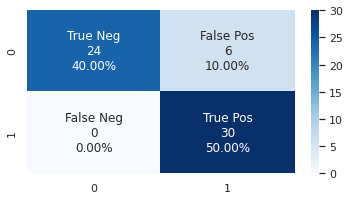

In [478]:
svmClfValF = 0.6656445205972853
svmClfValAcc = 0.738888888888889
svmClf = svm.SVC(C = 10, gamma = 1, kernel='rbf', probability=True)
svmClfAcc, svmClfF = userModel(svmClf)

## Logistic Regression

Accuracy is: 0.6666666666666666
f-measure: 0.7499999999999999
              precision    recall  f1-score   support

           0       1.00      0.33      0.50        30
           1       0.60      1.00      0.75        30

    accuracy                           0.67        60
   macro avg       0.80      0.67      0.62        60
weighted avg       0.80      0.67      0.62        60



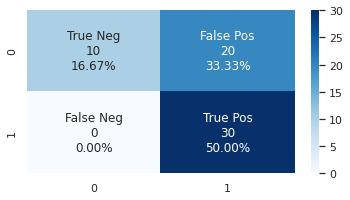

In [479]:
lrValF = 0.5662893040625481
lrValAcc = 0.5833333333333334
lr = LogisticRegression(penalty='l1', C=0.23357214690901212, solver='liblinear', fit_intercept=False)
lrAcc, lrF = userModel(lr)

## KNN

Accuracy is: 0.8333333333333334
f-measure: 0.8571428571428571
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        30
           1       0.75      1.00      0.86        30

    accuracy                           0.83        60
   macro avg       0.88      0.83      0.83        60
weighted avg       0.88      0.83      0.83        60



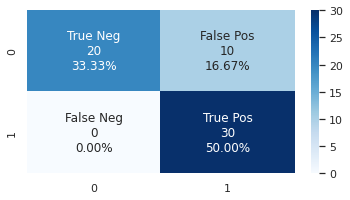

In [480]:
knnValF = 0.7417750777411221
knnValAcc = 0.7074074074074075
knn = KNeighborsClassifier(n_neighbors=80, weights='distance', algorithm='kd_tree', leaf_size=75, p=1)
knnAcc, knnF = userModel(knn)

## Decision Tree

Accuracy is: 0.5
f-measure: 0.16666666666666669
              precision    recall  f1-score   support

           0       0.50      0.90      0.64        30
           1       0.50      0.10      0.17        30

    accuracy                           0.50        60
   macro avg       0.50      0.50      0.40        60
weighted avg       0.50      0.50      0.40        60



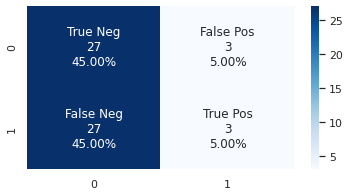

In [481]:
dtValF = 0.5321540927184363
dtValAcc = 0.6333333333333333
dt = DecisionTreeClassifier(criterion='gini', max_features='sqrt', max_depth=70, min_samples_split=5, min_samples_leaf=9, 
                            max_leaf_nodes=40, min_weight_fraction_leaf=0.1, splitter='best')
dtAcc, dtF = userModel(dt)

## Random Forest

Accuracy is: 0.9833333333333333
f-measure: 0.9836065573770492
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



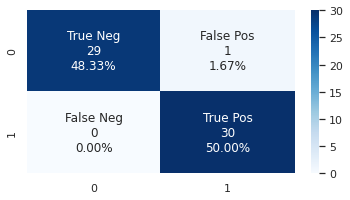

In [482]:
rfValF = 0.679226814641392
rfValAcc = 0.7611111111111112
rf = RandomForestClassifier(n_estimators=1800, max_features='sqrt', max_depth=40, min_samples_split=5, min_samples_leaf=4, bootstrap=False)
rfAcc, rfF = userModel(rf)

## Boosting

Accuracy is: 0.9833333333333333
f-measure: 0.9836065573770492
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



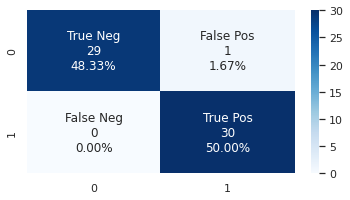

In [483]:
xgbClfValF = 0.6774946898377243
xgbClfValAcc = 0.7592592592592593
xgbClf = xgb.XGBClassifier(n_estimators=1600, max_depth=100, learning_rate=0.01, gamma=0, subsample=0.7, colsample_bytree=0.9,  
                           reg_alpha=0.1)
xgbClfAcc, xgbClfF = userModel(xgbClf)

## Plots

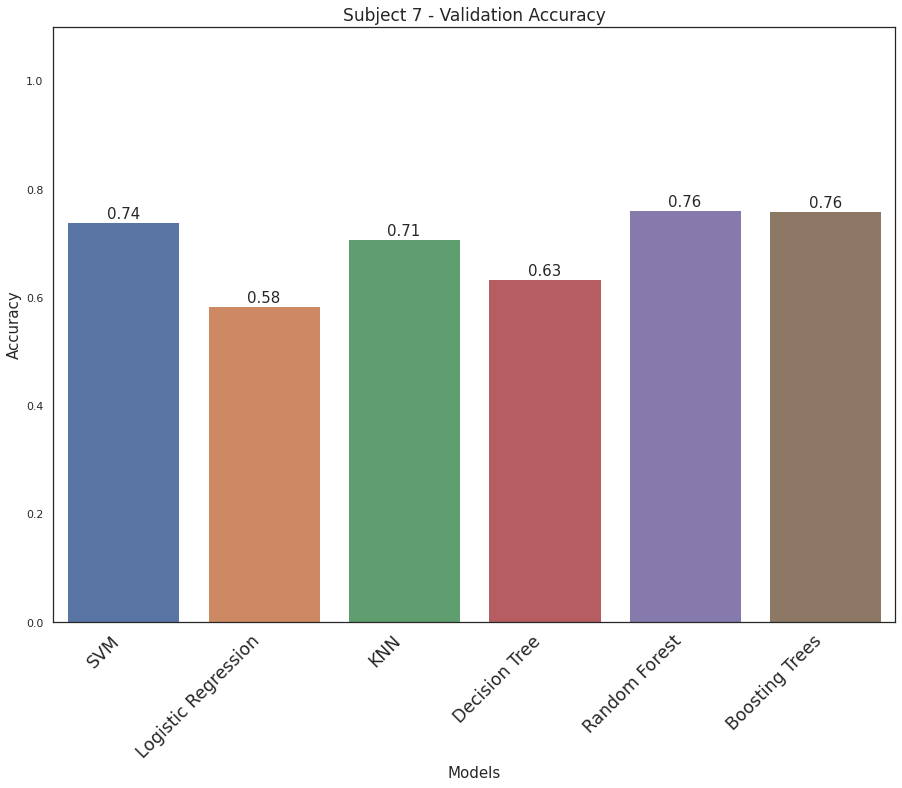

In [485]:
accuracies = [svmClfValAcc, lrValAcc, knnValAcc, dtValAcc, rfValAcc, xgbClfValAcc]
barPlot(accuracies, 'Subject 7 - Validation Accuracy', 'Accuracy')

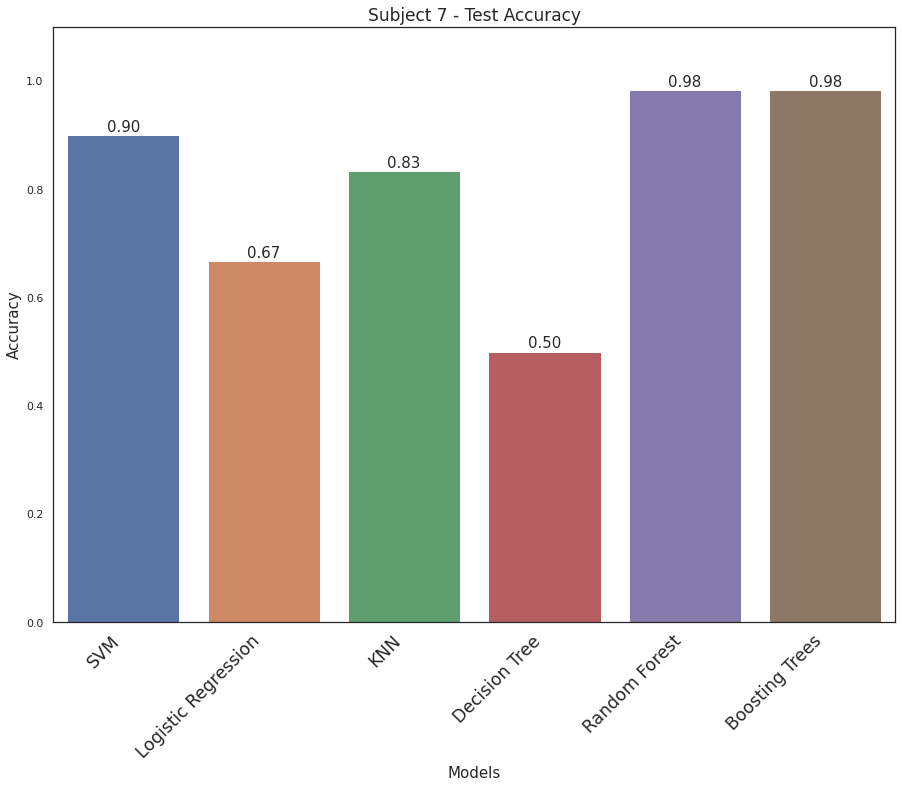

In [486]:
accuracies = [svmClfAcc, lrAcc, knnAcc, dtAcc, rfAcc, xgbClfAcc]
barPlot(accuracies, 'Subject 7 - Test Accuracy', 'Accuracy')

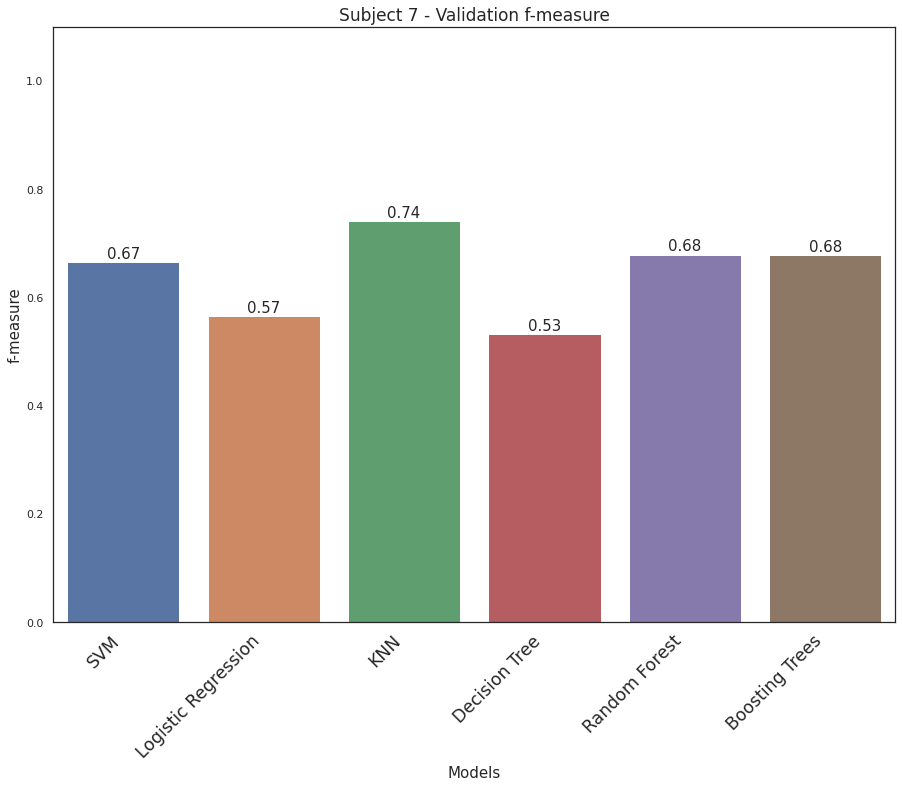

In [487]:
f_measure = [svmClfValF, lrValF, knnValF, dtValF, rfValF, xgbClfValF]
barPlot(f_measure, 'Subject 7 - Validation f-measure', 'f-measure')

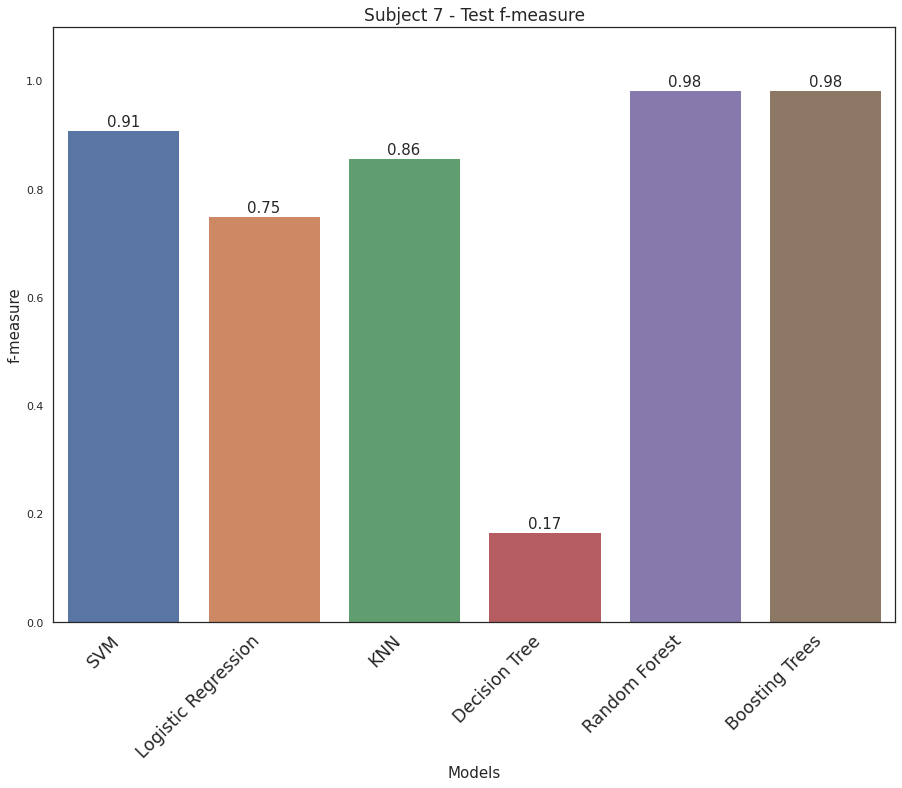

In [488]:
f_measure = [svmClfF, lrF, knnF, dtF, rfF, xgbClfF]
barPlot(f_measure, 'Subject 7 - Test f-measure', 'f-measure')

## Weighted Voting

### 3 WV

In [490]:
clf = [knn, xgbClf, rf]
weights = [knnValAcc, xgbClfValAcc, rfValAcc]
pred = WeightedVotingClassification(clf, weights)
s7_3wv = accuracy_score(df_testY, pred)
s7_3wv

0.9833333333333333

### 4 WV

In [491]:
clf = [knn, xgbClf, rf, svmClf]
weights = [knnValAcc, xgbClfValAcc, rfValAcc, svmClfValAcc]
pred = WeightedVotingClassification(clf, weights)
s7_4wv = accuracy_score(df_testY, pred)
s7_4wv

0.9833333333333333

### 5 WV

In [492]:
clf = [knn, xgbClf, rf, svmClf, lr]
weights = [knnValAcc, xgbClfValAcc, rfValAcc, svmClfValAcc, lrValAcc]
pred = WeightedVotingClassification(clf, weights)
s7_5wv = accuracy_score(df_testY, pred)
s7_5wv

0.9666666666666667

## Majority Voting

### 3 MV

In [493]:
clf = [knn, xgbClf, rf]
pred = MajorityVotingClassification(clf)
s7_3mv = accuracy_score(df_testY, pred)
s7_3mv

0.9833333333333333

### 4 MV

In [494]:
clf = [knn, xgbClf, rf, svmClf]
pred = MajorityVotingClassification(clf)
s7_4mv = accuracy_score(df_testY, pred)
s7_4mv

0.9833333333333333

### 5 MV

In [495]:
clf = [knn, xgbClf, rf, svmClf, lr]
pred = MajorityVotingClassification(clf)
s7_5mv = accuracy_score(df_testY, pred)
s7_5mv

0.9333333333333333

## Unanimous Voting

### 3 UV

In [496]:
clf = [knn, xgbClf, rf]
pred = UnanimousVotingClassification(clf)
s7_3uv = accuracy_score(df_testY, pred)
s7_3uv

0.9833333333333333

### 4 UV

In [497]:
clf = [knn, xgbClf, rf, svmClf]
pred = UnanimousVotingClassification(clf)
s7_4uv = accuracy_score(df_testY, pred)
s7_4uv

0.9833333333333333

### 5 UV

In [498]:
clf = [knn, xgbClf, rf, svmClf, lr]
pred = UnanimousVotingClassification(clf)
s7_5uv = accuracy_score(df_testY, pred)
s7_5uv

0.9833333333333333

# Fold 8

In [507]:
df_train = pd.read_csv('Fold_8_Train_Dataset.csv', header=None) 
df_test = pd.read_csv('Fold_8_Test_Dataset.csv', header=None)

df_trainX = df_train.iloc[:,:-1]
df_trainY = df_train.iloc[:,-1]
df_testX = df_test.iloc[:,:-1]
df_testY = df_test.iloc[:,-1]

df_trainY[df_trainY==1] = 0
df_trainY[df_trainY==2] = 1
df_testY[df_testY==1] = 0
df_testY[df_testY==2] = 1

## Train Validation Sets

In [508]:
df_train_master, df_val_master = createMasterTrainVal(8)
df_trainX_master, df_trainY_master, df_valX_master, df_valY_master = getMasterTrainValXY(8, df_train_master, df_val_master)

## Hyperparameter Tuning

### SVM

In [67]:
hyperparameterSearchSVM(8)

Iteration 1 C = 0.1 gamma = 1
Accuracy is: 0.5370370370370371
F-measure: 0.2860266227201711

Iteration 2 C = 0.1 gamma = 0.1
Accuracy is: 0.5759259259259258
F-measure: 0.5579000904159133

Iteration 3 C = 0.1 gamma = 0.01
Accuracy is: 0.4629629629629629
F-measure: 0.5479219019716213

Iteration 4 C = 0.1 gamma = 0.001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 5 C = 0.1 gamma = 0.0001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 6 C = 1 gamma = 1
Accuracy is: 0.7425925925925926
F-measure: 0.6512763046343163

Iteration 7 C = 1 gamma = 0.1
Accuracy is: 0.662962962962963
F-measure: 0.5962607639666898

Iteration 8 C = 1 gamma = 0.01
Accuracy is: 0.48148148148148145
F-measure: 0.45599809314956985

Iteration 9 C = 1 gamma = 0.001
Accuracy is: 0.46851851851851845
F-measure: 0.5296266595384479

Iteration 10 C = 1 gamma = 0.0001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 11 C = 10 gamma = 1
Accuracy is: 0.7333333333333334
F-measure: 0.643449588339858

It

{'0.10.0001': (0.0, 0.4444444444444444),
 '0.10.001': (0.0, 0.4444444444444444),
 '0.10.01': (0.5479219019716213, 0.4629629629629629),
 '0.10.1': (0.5579000904159133, 0.5759259259259258),
 '0.11': (0.2860266227201711, 0.5370370370370371),
 '10.0001': (0.0, 0.4444444444444444),
 '10.001': (0.5296266595384479, 0.46851851851851845),
 '10.01': (0.45599809314956985, 0.48148148148148145),
 '10.1': (0.5962607639666898, 0.662962962962963),
 '100.0001': (0.0784313725490196, 0.44074074074074077),
 '100.001': (0.38179256883699786, 0.4444444444444444),
 '100.01': (0.49600304662469635, 0.6037037037037037),
 '100.1': (0.4489649712172932, 0.6018518518518517),
 '1000.0001': (0.46327546752001375, 0.5148148148148147),
 '1000.001': (0.42358312713561924, 0.5314814814814814),
 '1000.01': (0.596203802086155, 0.6611111111111111),
 '1000.1': (0.633519407712956, 0.7092592592592593),
 '10000.0001': (0.40763757822599106, 0.5259259259259259),
 '10000.001': (0.48344014989697015, 0.5648148148148148),
 '10000.01': (

### Logistic Regression

In [68]:
hyperparameterSearchLR(8)

l11438.44988828766liblinearFalse (0.6323718804210263, 0.6166666666666667)


{'l10.0001liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0001liblinearTrue': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearFalse': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearTrue': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearFalse': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearTrue': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearFalse': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearTrue': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearFalse': (0.0, 0.3814814814814815),
 'l10.03359818286283781liblinearTrue': (0.0, 0.3814814814814815),
 'l10.08858667904100823liblinearFalse': (0.46977951467436047,
  0.50370370370

### KNN

In [69]:
hyperparameterSearchKNN(8)

80distanceauto302 (0.7331829220793141, 0.7000000000000001)


{'10distanceauto1001': (0.6376637926039554, 0.7092592592592593),
 '10distanceauto152': (0.6336194458726957, 0.7092592592592593),
 '10distanceauto602': (0.6336194458726957, 0.7092592592592593),
 '10distanceball_tree152': (0.6367296234231719, 0.7129629629629629),
 '10distanceball_tree452': (0.6352220099752599, 0.711111111111111),
 '10distancebrute1001': (0.6376637926039554, 0.7092592592592593),
 '10distancebrute451': (0.6376637926039554, 0.7092592592592593),
 '10distancebrute751': (0.6376637926039554, 0.7092592592592593),
 '10distancebrute752': (0.6336194458726957, 0.7092592592592593),
 '10distancekd_tree302': (0.6352220099752599, 0.711111111111111),
 '10uniformauto1001': (0.280065526964504, 0.5166666666666667),
 '10uniformauto1002': (0.37130367510248663, 0.5703703703703704),
 '10uniformauto152': (0.37130367510248663, 0.5703703703703704),
 '10uniformauto451': (0.280065526964504, 0.5166666666666667),
 '10uniformball_tree1001': (0.2851633202818453, 0.5240740740740741),
 '10uniformball_tree

### Decision Tree

In [70]:
hyperparameterSearchDecisionTree(8)

entropyauto20107400.1random (0.6133796362383731, 0.6703703703703704)


{'entropyNone1025300.4random': (0.0655282076334708, 0.3259259259259259),
 'entropyNone1029500.5best': (0.0, 0.4444444444444444),
 'entropyNone20106900.3random': (0.2539740896358543, 0.49444444444444446),
 'entropyNone2024100.3random': (0.2539740896358543, 0.49444444444444446),
 'entropyNone3059700.3best': (0.2539740896358543, 0.49444444444444446),
 'entropyNone40510900.4best': (0.0655282076334708, 0.3259259259259259),
 'entropyNone5027700.1random': (0.217639611039898, 0.4703703703703704),
 'entropyNone5028None0.5random': (0.0, 0.4444444444444444),
 'entropyNone5055300.1random': (0.217639611039898, 0.4703703703703704),
 'entropyNone60109600.5random': (0.0, 0.4444444444444444),
 'entropyNone6024900.4random': (0.0655282076334708, 0.3259259259259259),
 'entropyNone6028500.3best': (0.2539740896358543, 0.49444444444444446),
 'entropyNone7051100.1best': (0.217639611039898, 0.4703703703703704),
 'entropyNone80104800.4random': (0.0655282076334708, 0.3259259259259259),
 'entropyNone80510600.3ran

### Random Forest

In [71]:
hyperparameterSearchRandomForest(8)

1800sqrt4054False (0.6660346947647849, 0.7611111111111112)


{'1000auto40104False': (0.6660346947647849, 0.7611111111111112),
 '1200auto4022False': (0.6648661360636416, 0.7611111111111112),
 '1600log22051False': (0.659903356907314, 0.7555555555555556),
 '1800sqrt4054False': (0.6660346947647849, 0.7611111111111112),
 '2000sqrt10024True': (0.6591024234716967, 0.7537037037037038),
 '2000sqrt10052True': (0.6642719589988763, 0.7592592592592593),
 '2000sqrt1021True': (0.6613966243974087, 0.7574074074074075),
 '200autoNone52False': (0.6615059210098782, 0.7574074074074075),
 '200log24051True': (0.6613966243974087, 0.7574074074074075),
 '400autoNone51True': (0.6609117439451128, 0.7555555555555556),
 '400log211024True': (0.6573956475713724, 0.751851851851852),
 '400sqrt5054False': (0.6642719589988763, 0.7592592592592593),
 '400sqrt60102True': (0.6625092232329676, 0.7574074074074075),
 '600auto6021False': (0.6583493553533125, 0.7537037037037038),
 '600log220104True': (0.6573956475713724, 0.751851851851852),
 '600sqrt3024False': (0.6642719589988763, 0.75925

### Xgboost

In [72]:
hyperparameterSearchXgb(8)

10001100.030.00.80.90.01 (0.6666288718295503, 0.7611111111111112)


{'10001100.030.00.80.90.01': (0.6666288718295503, 0.7611111111111112),
 '1000300.0030.20.60.61': (0.6556888716710482, 0.7481481481481482),
 '1000300.0030.40.80.9100': (0.0, 0.4444444444444444),
 '1000400.00010.10.60.61': (0.4776280460477276, 0.6444444444444445),
 '1200100.0030.40.70.61e-05': (0.6625092232329676, 0.7574074074074075),
 '1200200.0030.10.70.90.01': (0.6545203129699048, 0.7481481481481482),
 '1200400.010.00.70.70.01': (0.6648661360636416, 0.7592592592592593),
 '1200800.30.00.70.71e-05': (0.6630474404321485, 0.7555555555555556),
 '1400300.010.30.70.61': (0.6608024473326433, 0.7537037037037038),
 '1400600.0030.10.90.61e-05': (0.6596898484970843, 0.751851851851852),
 '1400700.30.00.60.61': (0.6665729119639658, 0.7629629629629631),
 '1400900.30.10.70.80.01': (0.6595779287659155, 0.751851851851852),
 '1600100.010.40.70.60.1': (0.6648661360636416, 0.7592592592592593),
 '16001000.010.00.70.90.1': (0.6648661360636416, 0.7592592592592593),
 '1600700.0030.00.60.90.1': (0.660802447332

## SVM

Accuracy is: 0.5166666666666667
f-measure: 0.17142857142857143
              precision    recall  f1-score   support

           0       0.51      0.93      0.66        30
           1       0.60      0.10      0.17        30

    accuracy                           0.52        60
   macro avg       0.55      0.52      0.42        60
weighted avg       0.55      0.52      0.42        60



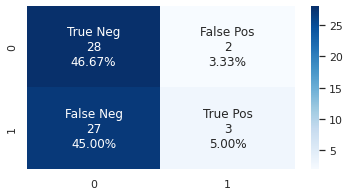

In [501]:
svmClfValF = 0.6512763046343163
svmClfValAcc = 0.7425925925925926
svmClf = svm.SVC(C = 1, gamma = 1, kernel='rbf', probability=True)
svmClfAcc, svmClfF = userModel(svmClf)

## Logistic Regression

Accuracy is: 0.35
f-measure: 0.13333333333333333
              precision    recall  f1-score   support

           0       0.40      0.60      0.48        30
           1       0.20      0.10      0.13        30

    accuracy                           0.35        60
   macro avg       0.30      0.35      0.31        60
weighted avg       0.30      0.35      0.31        60



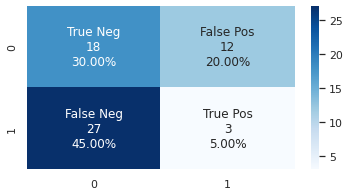

In [502]:
lrValF = 0.6323718804210263
lrValAcc = 0.6166666666666667
lr = LogisticRegression(penalty='l1', C=1438.44988828766, solver='liblinear', fit_intercept=False)
lrAcc, lrF = userModel(lr)

## KNN

Accuracy is: 0.7666666666666667
f-measure: 0.8108108108108109
              precision    recall  f1-score   support

           0       1.00      0.53      0.70        30
           1       0.68      1.00      0.81        30

    accuracy                           0.77        60
   macro avg       0.84      0.77      0.75        60
weighted avg       0.84      0.77      0.75        60



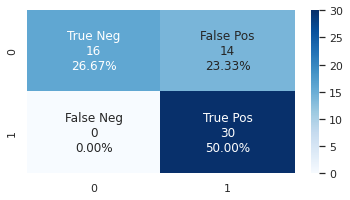

In [503]:
knnValF = 0.7331829220793141
knnValAcc = 0.7000000000000001
knn = KNeighborsClassifier(n_neighbors=80, weights='distance', algorithm='auto', leaf_size=30, p=2)
knnAcc, knnF = userModel(knn)

## Decision Tree

Accuracy is: 0.5
f-measure: 0.0
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        30
           1       0.00      0.00      0.00        30

    accuracy                           0.50        60
   macro avg       0.25      0.50      0.33        60
weighted avg       0.25      0.50      0.33        60



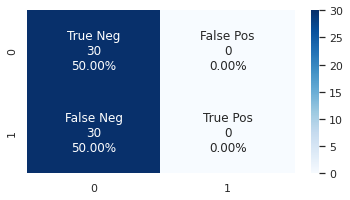

In [504]:
dtValF = 0.6133796362383731
dtValAcc = 0.6703703703703704
dt = DecisionTreeClassifier(criterion='entropy', max_features='auto', max_depth=20, min_samples_split=10, min_samples_leaf=7, 
                            max_leaf_nodes=40, min_weight_fraction_leaf=0.1, splitter='random')
dtAcc, dtF = userModel(dt)

## Random Forest

Accuracy is: 0.9666666666666667
f-measure: 0.967741935483871
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.94      1.00      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



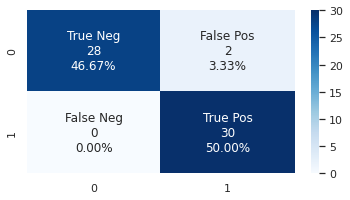

In [505]:
rfValF = 0.6660346947647849
rfValAcc = 0.7611111111111112
rf = RandomForestClassifier(n_estimators=1800, max_features='sqrt', max_depth=40, min_samples_split=5, min_samples_leaf=4, bootstrap=False)
rfAcc, rfF = userModel(rf)

## Boosting

Accuracy is: 0.9833333333333333
f-measure: 0.9836065573770492
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



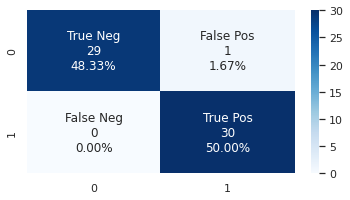

In [506]:
xgbClfValF = 0.6666288718295503
xgbClfValAcc = 0.7611111111111112
xgbClf = xgb.XGBClassifier(n_estimators=1000, max_depth=110, learning_rate=0.03, gamma=0, subsample=0.8, colsample_bytree=0.9,  
                           reg_alpha=0.01)
xgbClfAcc, xgbClfF = userModel(xgbClf)

## Plots

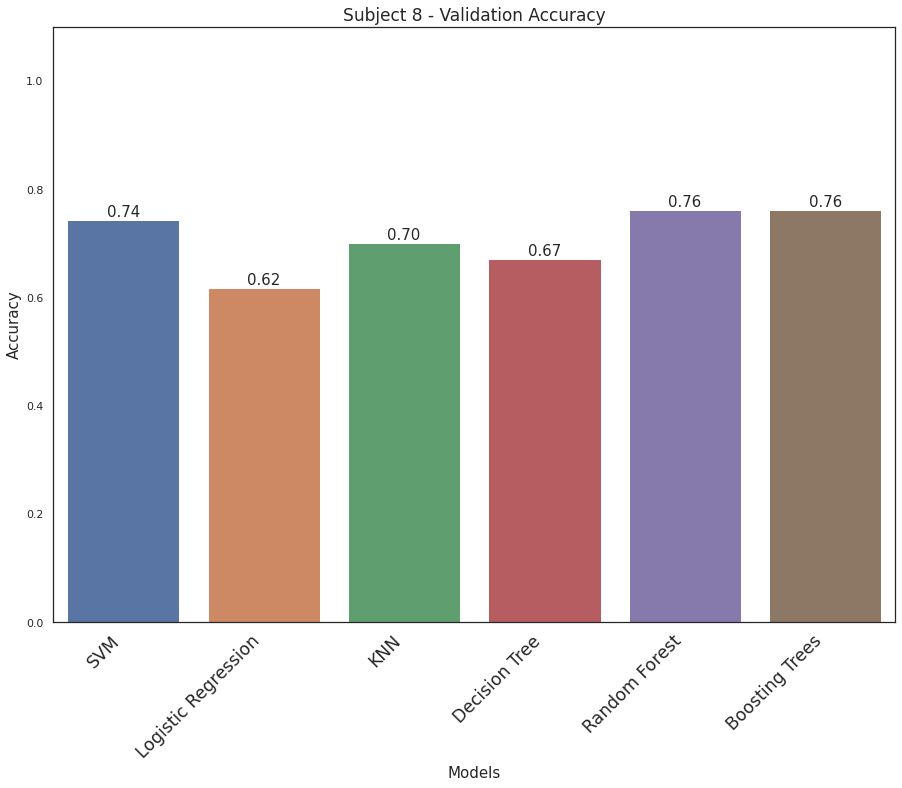

In [514]:
accuracies = [svmClfValAcc, lrValAcc, knnValAcc, dtValAcc, rfValAcc, xgbClfValAcc]
barPlot(accuracies, 'Subject 8 - Validation Accuracy', 'Accuracy')

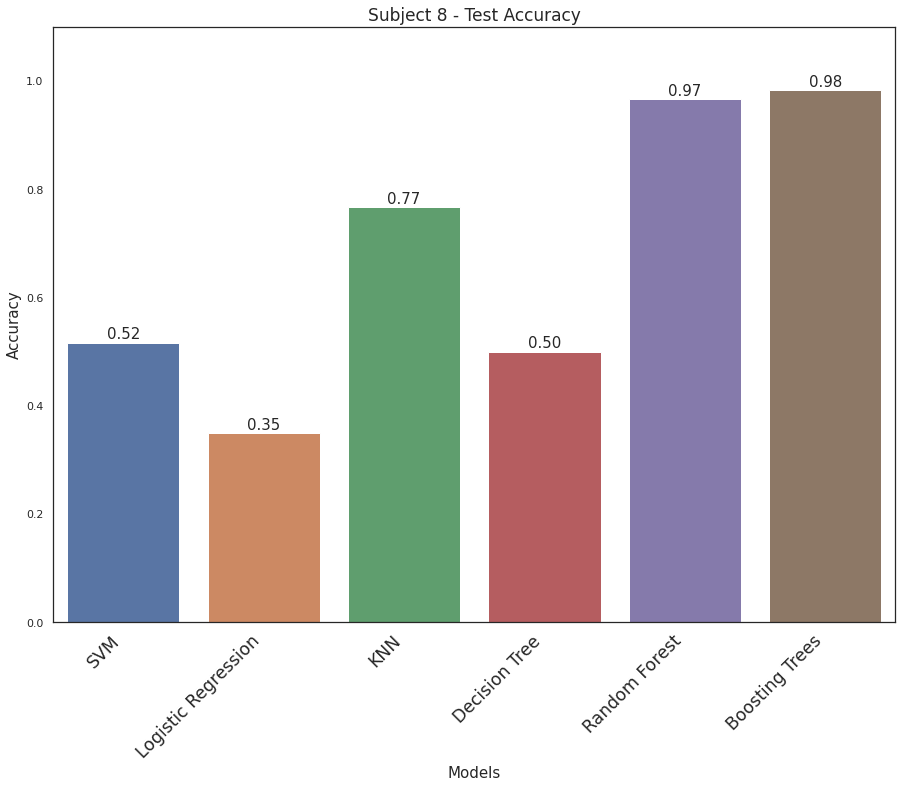

In [515]:
accuracies = [svmClfAcc, lrAcc, knnAcc, dtAcc, rfAcc, xgbClfAcc]
barPlot(accuracies, 'Subject 8 - Test Accuracy', 'Accuracy')

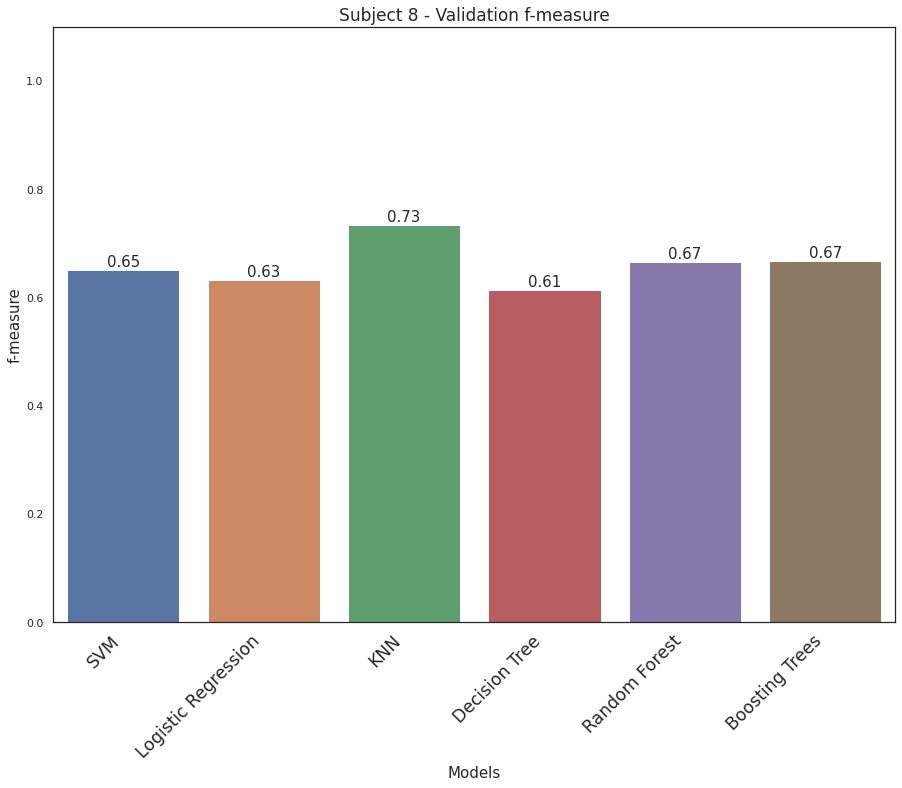

In [516]:
f_measure = [svmClfValF, lrValF, knnValF, dtValF, rfValF, xgbClfValF]
barPlot(f_measure, 'Subject 8 - Validation f-measure', 'f-measure')

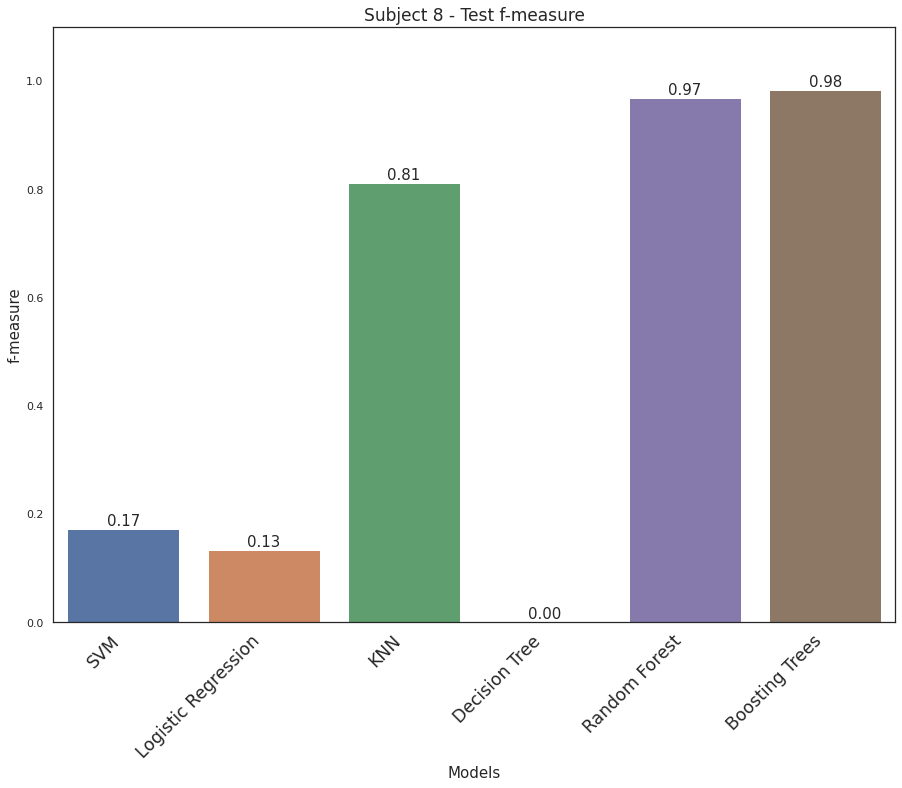

In [517]:
f_measure = [svmClfF, lrF, knnF, dtF, rfF, xgbClfF]
barPlot(f_measure, 'Subject 8 - Test f-measure', 'f-measure')

## Weighted Voting

### 3 WV

In [518]:
clf = [knn, xgbClf, rf]
weights = [knnValAcc, xgbClfValAcc, rfValAcc]
pred = WeightedVotingClassification(clf, weights)
s8_3wv = accuracy_score(df_testY, pred)
s8_3wv

0.9833333333333333

### 4 WV

In [519]:
clf = [knn, xgbClf, rf, svmClf]
weights = [knnValAcc, xgbClfValAcc, rfValAcc, svmClfValAcc]
pred = WeightedVotingClassification(clf, weights)
s8_4wv = accuracy_score(df_testY, pred)
s8_4wv

0.9833333333333333

### 5 WV

In [520]:
clf = [knn, xgbClf, rf, svmClf, lr]
weights = [knnValAcc, xgbClfValAcc, rfValAcc, svmClfValAcc, lrValAcc]
pred = WeightedVotingClassification(clf, weights)
s8_5wv = accuracy_score(df_testY, pred)
s8_5wv

0.95

## Majority Voting

### 3 MV

In [521]:
clf = [knn, xgbClf, rf]
pred = MajorityVotingClassification(clf)
s8_3mv = accuracy_score(df_testY, pred)
s8_3mv

0.9666666666666667

### 4 MV

In [522]:
clf = [knn, xgbClf, rf, svmClf]
pred = MajorityVotingClassification(clf)
s8_4mv =accuracy_score(df_testY, pred)
s8_4mv

0.9666666666666667

### 5 MV

In [523]:
clf = [knn, xgbClf, rf, svmClf, lr]
pred = MajorityVotingClassification(clf)
s8_5mv = accuracy_score(df_testY, pred)
s8_5mv

0.95

## Unanimous Voting

### 3 UV

In [524]:
clf = [knn, xgbClf, rf]
pred = UnanimousVotingClassification(clf)
s8_3uv = accuracy_score(df_testY, pred)
s8_3uv

0.9833333333333333

### 4 UV

In [525]:
clf = [knn, xgbClf, rf, svmClf]
pred = UnanimousVotingClassification(clf)
s8_4uv = accuracy_score(df_testY, pred)
s8_4uv

0.55

### 5 UV

In [526]:
clf = [knn, xgbClf, rf, svmClf, lr]
pred = UnanimousVotingClassification(clf)
s8_5uv = accuracy_score(df_testY, pred)
s8_5uv

0.55

# Fold 9

In [527]:
df_train = pd.read_csv('Fold_9_Train_Dataset.csv', header=None) 
df_test = pd.read_csv('Fold_9_Test_Dataset.csv', header=None)

df_trainX = df_train.iloc[:,:-1]
df_trainY = df_train.iloc[:,-1]
df_testX = df_test.iloc[:,:-1]
df_testY = df_test.iloc[:,-1]

df_trainY[df_trainY==1] = 0
df_trainY[df_trainY==2] = 1
df_testY[df_testY==1] = 0
df_testY[df_testY==2] = 1

## Train Validation Sets

In [528]:
df_train_master, df_val_master = createMasterTrainVal(9)
df_trainX_master, df_trainY_master, df_valX_master, df_valY_master = getMasterTrainValXY(9, df_train_master, df_val_master)

## Hyperparameter Tuning

### SVM

In [529]:
hyperparameterSearchSVM(9)

Iteration 1 C = 0.1 gamma = 1
Accuracy is: 0.5462962962962963
F-measure: 0.30544440544440543

Iteration 2 C = 0.1 gamma = 0.1
Accuracy is: 0.5018518518518519
F-measure: 0.418586981879715

Iteration 3 C = 0.1 gamma = 0.01
Accuracy is: 0.47777777777777775
F-measure: 0.5500438206310077

Iteration 4 C = 0.1 gamma = 0.001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 5 C = 0.1 gamma = 0.0001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 6 C = 1 gamma = 1
Accuracy is: 0.7555555555555556
F-measure: 0.6638450653191532

Iteration 7 C = 1 gamma = 0.1
Accuracy is: 0.6203703703703703
F-measure: 0.5230878913310189

Iteration 8 C = 1 gamma = 0.01
Accuracy is: 0.4740740740740741
F-measure: 0.45005703905874067

Iteration 9 C = 1 gamma = 0.001
Accuracy is: 0.4629629629629629
F-measure: 0.5279046740892249

Iteration 10 C = 1 gamma = 0.0001
Accuracy is: 0.4444444444444444
F-measure: 0.0

Iteration 11 C = 10 gamma = 1
Accuracy is: 0.7870370370370372
F-measure: 0.752193473143065

It

{'0.10.0001': (0.0, 0.4444444444444444),
 '0.10.001': (0.0, 0.4444444444444444),
 '0.10.01': (0.5500438206310077, 0.47777777777777775),
 '0.10.1': (0.418586981879715, 0.5018518518518519),
 '0.11': (0.30544440544440543, 0.5462962962962963),
 '10.0001': (0.0, 0.4444444444444444),
 '10.001': (0.5279046740892249, 0.4629629629629629),
 '10.01': (0.45005703905874067, 0.4740740740740741),
 '10.1': (0.5230878913310189, 0.6203703703703703),
 '100.0001': (0.07662835249042146, 0.4222222222222222),
 '100.001': (0.4034939271432265, 0.46481481481481485),
 '100.01': (0.6774945238659458, 0.6925925925925925),
 '100.1': (0.4533234533234533, 0.6111111111111112),
 '1000.0001': (0.4637676532123314, 0.5185185185185186),
 '1000.001': (0.5013001732011122, 0.5722222222222223),
 '1000.01': (0.4292016485430116, 0.5518518518518519),
 '1000.1': (0.6372562622562623, 0.7240740740740742),
 '10000.0001': (0.43422905251264216, 0.5333333333333334),
 '10000.001': (0.40776612422294456, 0.5166666666666666),
 '10000.01': (0

### Logistic Regression

In [95]:
hyperparameterSearchLR(9)

l20.08858667904100823liblinearFalse (0.4900171341952164, 0.5314814814814814)


{'l10.0001liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0001liblinearTrue': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearFalse': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearTrue': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearFalse': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearTrue': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearFalse': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearTrue': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearFalse': (0.0, 0.38518518518518513),
 'l10.03359818286283781liblinearTrue': (0.0, 0.38518518518518513),
 'l10.08858667904100823liblinearFalse': (0.4643406770579161,
  0.5148148148

### KNN

In [96]:
hyperparameterSearchKNN(9)

20distancebrute601 (0.8037831581237653, 0.7944444444444446)


{'10distanceauto1001': (0.7446348347135925, 0.7759259259259259),
 '10distanceauto152': (0.7386455491190438, 0.7703703703703705),
 '10distanceauto602': (0.7386455491190438, 0.7703703703703705),
 '10distanceball_tree152': (0.7407994887729834, 0.7740740740740741),
 '10distanceball_tree452': (0.7391460496195443, 0.7722222222222224),
 '10distancebrute1001': (0.7446348347135925, 0.7759259259259259),
 '10distancebrute451': (0.7446348347135925, 0.7759259259259259),
 '10distancebrute751': (0.7446348347135925, 0.7759259259259259),
 '10distancebrute752': (0.7386455491190438, 0.7703703703703705),
 '10distancekd_tree302': (0.7391460496195443, 0.7722222222222224),
 '10uniformauto1001': (0.21449704263171757, 0.48888888888888893),
 '10uniformauto1002': (0.38152406021843666, 0.5814814814814815),
 '10uniformauto152': (0.38152406021843666, 0.5814814814814815),
 '10uniformauto451': (0.21449704263171757, 0.48888888888888893),
 '10uniformball_tree1001': (0.21449704263171757, 0.48888888888888893),
 '10unifor

### Decision Tree

In [97]:
hyperparameterSearchDecisionTree(9)

ginisqrt901010500.1random (0.5446322878148071, 0.6407407407407407)


{'entropyNone1025300.4random': (0.22205730292686818, 0.4148148148148148),
 'entropyNone1029500.5best': (0.0, 0.4444444444444444),
 'entropyNone20106900.3random': (0.15908532471999967, 0.425925925925926),
 'entropyNone2024100.3random': (0.15908532471999967, 0.425925925925926),
 'entropyNone3059700.3best': (0.15908532471999967, 0.425925925925926),
 'entropyNone40510900.4best': (0.22205730292686818, 0.4148148148148148),
 'entropyNone5027700.1random': (0.28820085807173323, 0.5166666666666667),
 'entropyNone5028None0.5random': (0.0, 0.4444444444444444),
 'entropyNone5055300.1random': (0.28820085807173323, 0.5166666666666667),
 'entropyNone60109600.5random': (0.0, 0.4444444444444444),
 'entropyNone6024900.4random': (0.22205730292686818, 0.4148148148148148),
 'entropyNone6028500.3best': (0.15908532471999967, 0.425925925925926),
 'entropyNone7051100.1best': (0.28820085807173323, 0.5166666666666667),
 'entropyNone80104800.4random': (0.22205730292686818, 0.4148148148148148),
 'entropyNone8051060

### Random Forest

In [98]:
hyperparameterSearchRandomForest(9)

2000sqrt10024True (0.7741557535499805, 0.8148148148148149)


{'1000auto40104False': (0.770795538496217, 0.8111111111111112),
 '1200auto4022False': (0.7690328027303083, 0.8092592592592593),
 '1600log22051False': (0.7706862418837475, 0.8111111111111112),
 '1800sqrt4054False': (0.770795538496217, 0.8111111111111112),
 '2000sqrt10024True': (0.7741557535499805, 0.8148148148148149),
 '2000sqrt10052True': (0.7672700669643996, 0.8074074074074075),
 '2000sqrt1021True': (0.7672700669643996, 0.8074074074074075),
 '200autoNone52False': (0.770795538496217, 0.8111111111111112),
 '200log24051True': (0.7672700669643996, 0.8074074074074075),
 '400autoNone51True': (0.7672700669643996, 0.8074074074074075),
 '400log211024True': (0.770630282018163, 0.8111111111111112),
 '400sqrt5054False': (0.7690328027303083, 0.8092592592592593),
 '400sqrt60102True': (0.7574587286562342, 0.7944444444444445),
 '600auto6021False': (0.7672700669643996, 0.8074074074074075),
 '600log220104True': (0.7611426159840073, 0.8000000000000002),
 '600sqrt3024False': (0.770795538496217, 0.8111111

### Xgboost

In [99]:
hyperparameterSearchXgb(9)

1800200.10.00.60.60.01 (0.7793880009821221, 0.8203703703703704)


{'10001100.030.00.80.90.01': (0.7723930177840717, 0.812962962962963),
 '1000300.0030.20.60.61': (0.7700361049533977, 0.8092592592592593),
 '1000300.0030.40.80.9100': (0.0, 0.4444444444444444),
 '1000400.00010.10.60.61': (0.5045360488663505, 0.6666666666666666),
 '1200100.0030.40.70.61e-05': (0.7717988407193064, 0.8111111111111112),
 '1200200.0030.10.70.90.01': (0.7665665932871648, 0.8055555555555557),
 '1200400.010.00.70.70.01': (0.7759184893158891, 0.8166666666666668),
 '1200800.30.00.70.71e-05': (0.7705836973106556, 0.8111111111111112),
 '1400300.010.30.70.61': (0.7717988407193064, 0.8111111111111112),
 '1400600.0030.10.90.61e-05': (0.7689768428647238, 0.8092592592592593),
 '1400700.30.00.60.61': (0.7723930177840717, 0.812962962962963),
 '1400900.30.10.70.80.01': (0.774109168842473, 0.8148148148148149),
 '1600100.010.40.70.60.1': (0.7759184893158891, 0.8166666666666668),
 '16001000.010.00.70.90.1': (0.7741557535499805, 0.8148148148148149),
 '1600700.0030.00.60.90.1': (0.7717988407193

## SVM

Accuracy is: 0.9166666666666666
f-measure: 0.9152542372881356
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        30
           1       0.93      0.90      0.92        30

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



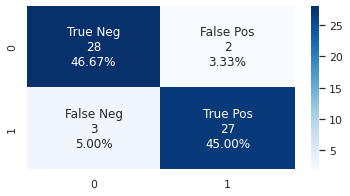

In [530]:
svmClfValF = 0.752193473143065
svmClfValAcc = 0.7870370370370372
svmClf = svm.SVC(C = 10, gamma = 1, kernel='rbf', probability=True)
svmClfAcc, svmClfF = userModel(svmClf)

## Logistic Regression

Accuracy is: 0.7666666666666667
f-measure: 0.7941176470588235
              precision    recall  f1-score   support

           0       0.86      0.63      0.73        30
           1       0.71      0.90      0.79        30

    accuracy                           0.77        60
   macro avg       0.79      0.77      0.76        60
weighted avg       0.79      0.77      0.76        60



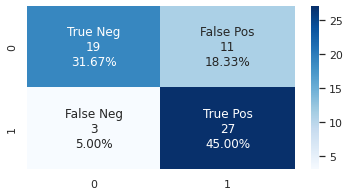

In [531]:
lrValF = 0.4900171341952164
lrValAcc = 0.5314814814814814
lr = LogisticRegression(penalty='l2', C=0.08858667904100823, solver='liblinear', fit_intercept=False)
lrAcc, lrF = userModel(lr)

## KNN

Accuracy is: 0.9
f-measure: 0.9032258064516129
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        30
           1       0.88      0.93      0.90        30

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



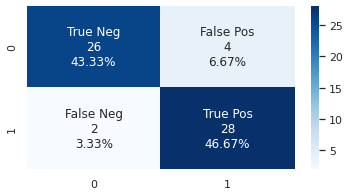

In [532]:
knnValF = 0.8037831581237653
knnValAcc = 0.7944444444444446
knn = KNeighborsClassifier(n_neighbors=20, weights='distance', algorithm='brute', leaf_size=60, p=1)
knnAcc, knnF = userModel(knn)

## Decision Tree

Accuracy is: 0.5
f-measure: 0.0
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        30
           1       0.00      0.00      0.00        30

    accuracy                           0.50        60
   macro avg       0.25      0.50      0.33        60
weighted avg       0.25      0.50      0.33        60



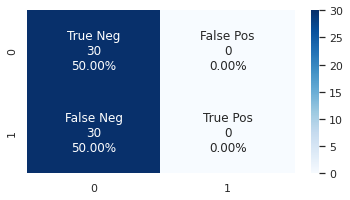

In [533]:
dtValF = 0.5446322878148071
dtValAcc = 0.6407407407407407
dt = DecisionTreeClassifier(criterion='gini', max_features='sqrt', max_depth=90, min_samples_split=10, min_samples_leaf=10, 
                            max_leaf_nodes=50, min_weight_fraction_leaf=0.1, splitter='random')
dtAcc, dtF = userModel(dt)

## Random Forest

Accuracy is: 0.9333333333333333
f-measure: 0.9310344827586207
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       0.96      0.90      0.93        30

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



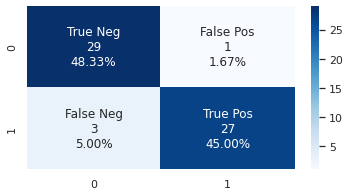

In [534]:
rfValF = 0.7741557535499805
rfValAcc = 0.8148148148148149
rf = RandomForestClassifier(n_estimators=2000, max_features='sqrt', max_depth=100, min_samples_split=2, min_samples_leaf=4, bootstrap=True)
rfAcc, rfF = userModel(rf)

## Boosting

Accuracy is: 0.9333333333333333
f-measure: 0.9310344827586207
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       0.96      0.90      0.93        30

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



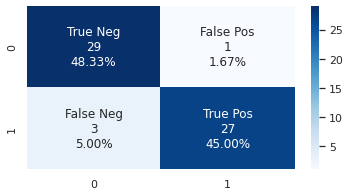

In [535]:
xgbClfValF = 0.7793880009821221
xgbClfValAcc = 0.8203703703703704
xgbClf = xgb.XGBClassifier(n_estimators=1800, max_depth=20, learning_rate=0.1, gamma=0, subsample=0.6, colsample_bytree=0.6,  
                           reg_alpha=0.01)
xgbClfAcc, xgbClfF = userModel(xgbClf)

## Plots

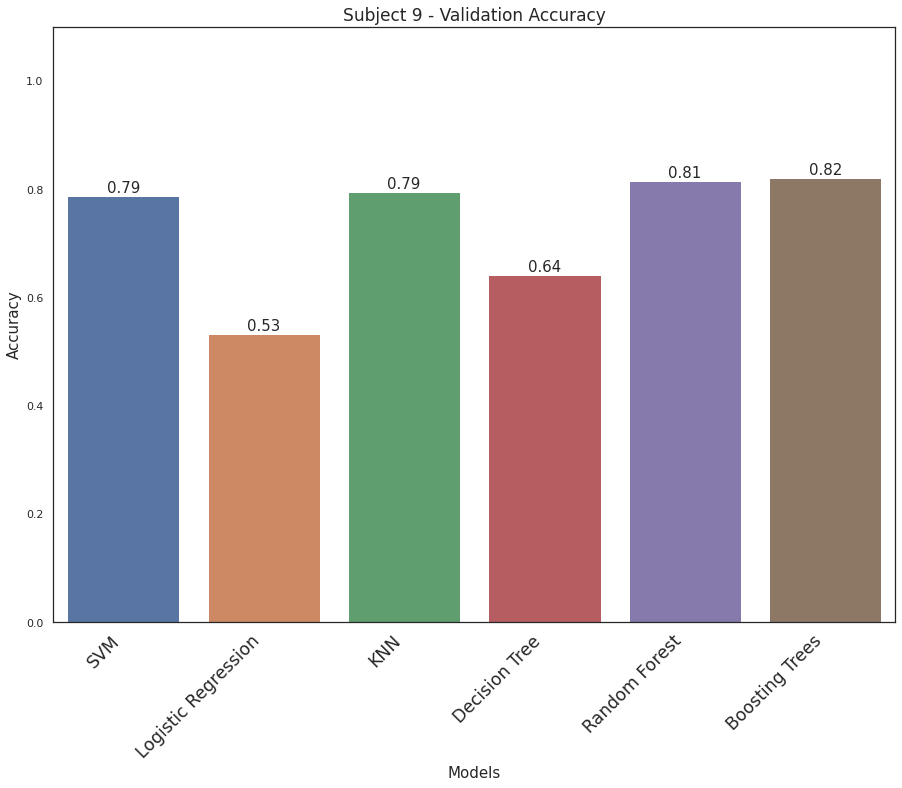

In [541]:
accuracies = [svmClfValAcc, lrValAcc, knnValAcc, dtValAcc, rfValAcc, xgbClfValAcc]
barPlot(accuracies, 'Subject 9 - Validation Accuracy', 'Accuracy')

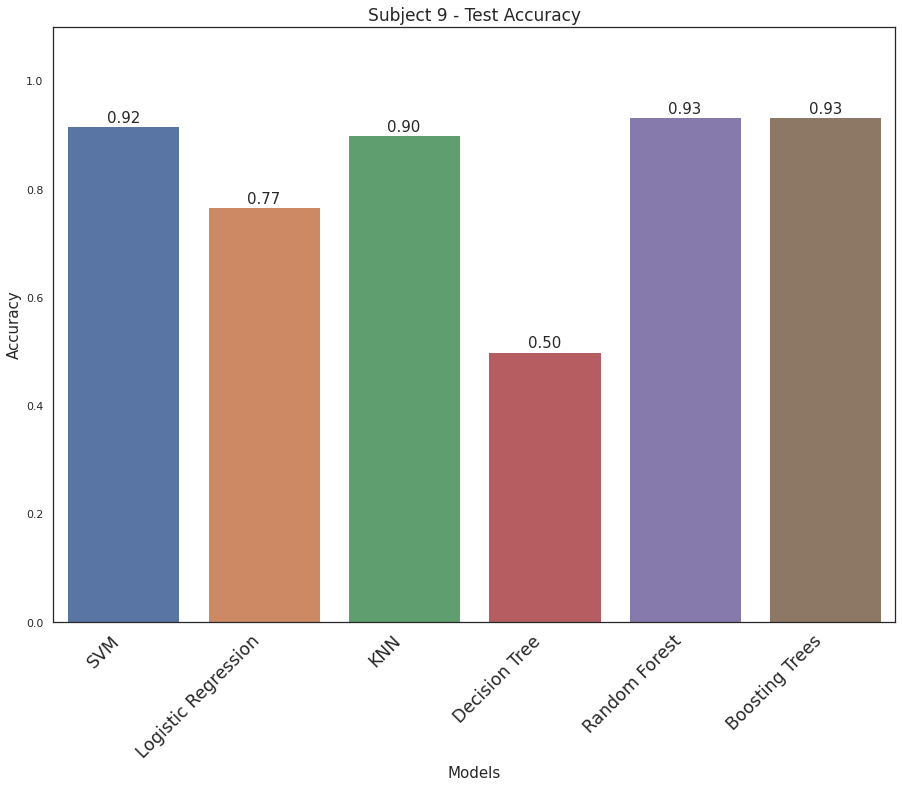

In [542]:
accuracies = [svmClfAcc, lrAcc, knnAcc, dtAcc, rfAcc, xgbClfAcc]
barPlot(accuracies, 'Subject 9 - Test Accuracy', 'Accuracy')

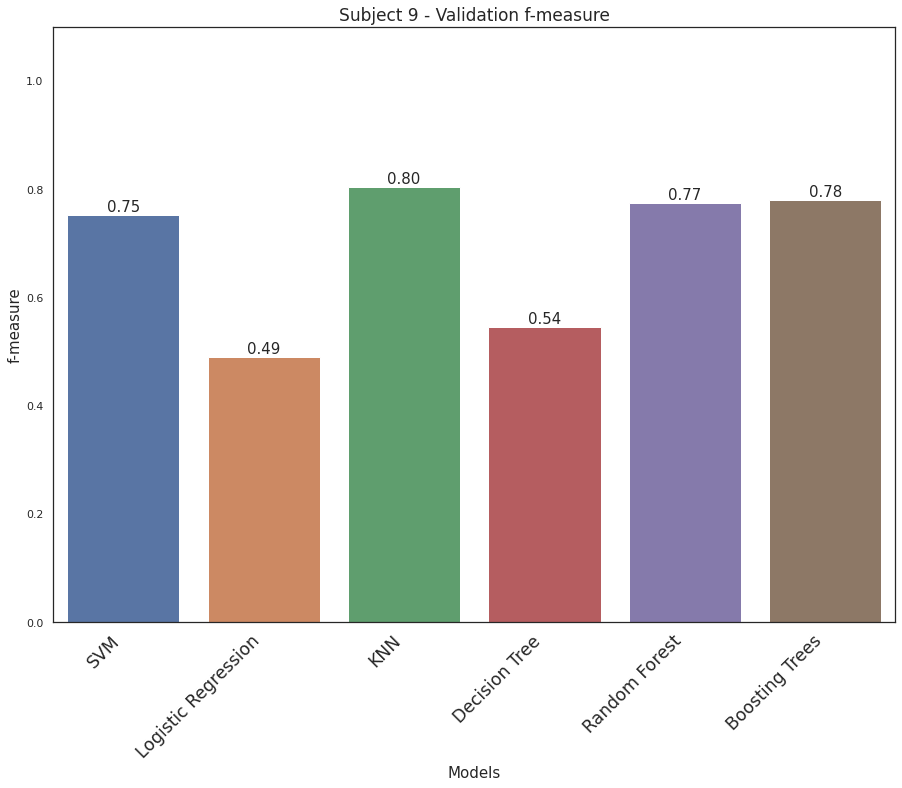

In [543]:
f_measure = [svmClfValF, lrValF, knnValF, dtValF, rfValF, xgbClfValF]
barPlot(f_measure, 'Subject 9 - Validation f-measure', 'f-measure')

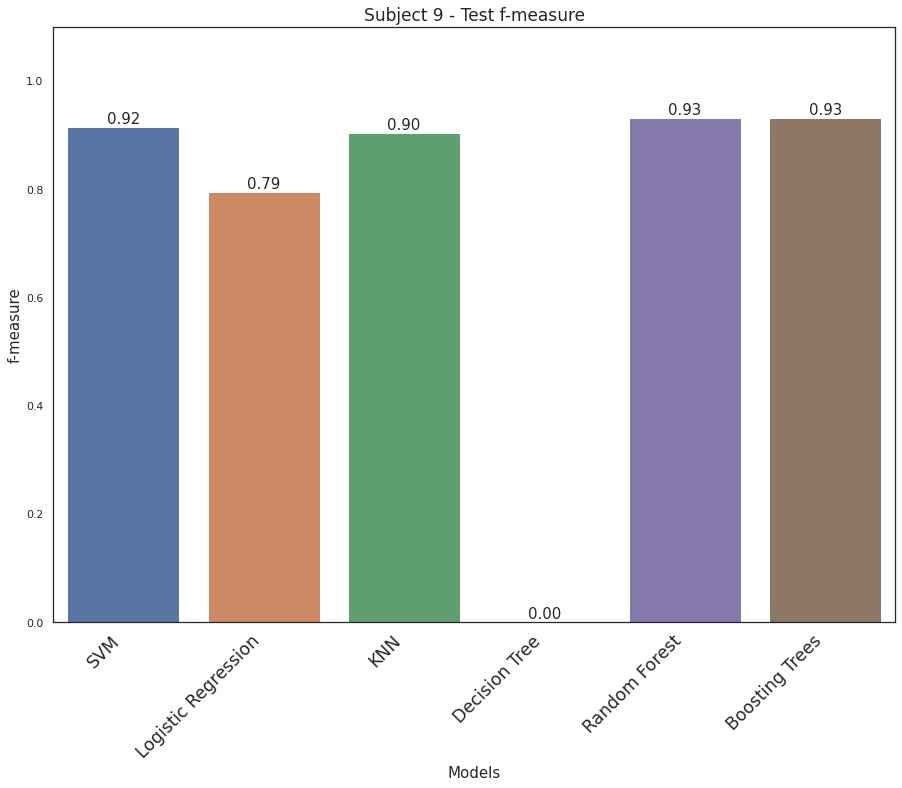

In [544]:
f_measure = [svmClfF, lrF, knnF, dtF, rfF, xgbClfF]
barPlot(f_measure, 'Subject 9 - Test f-measure', 'f-measure')

## Weighted Voting

### 3 WV

In [548]:
clf = [knn, xgbClf, rf]
weights = [knnValAcc, xgbClfValAcc, rfValAcc]
pred = WeightedVotingClassification(clf, weights)
s9_3wv = accuracy_score(df_testY, pred)
s9_3wv

0.9333333333333333

### 4 WV

In [549]:
clf = [knn, xgbClf, rf, svmClf]
weights = [knnValAcc, xgbClfValAcc, rfValAcc, svmClfValAcc]
pred = WeightedVotingClassification(clf, weights)
s9_4wv = accuracy_score(df_testY, pred)
s9_4wv 

0.9333333333333333

### 5 WV

In [547]:
clf = [knn, xgbClf, rf, svmClf, dt]
weights = [knnValAcc, xgbClfValAcc, rfValAcc, svmClfValAcc, dtValAcc]
pred = WeightedVotingClassification(clf, weights)
s9_5wv = accuracy_score(df_testY, pred)
s9_5wv

0.9333333333333333

## Majority Voting

### 3 MV

In [550]:
clf = [knn, xgbClf, rf]
pred = MajorityVotingClassification(clf)
s9_3mv = accuracy_score(df_testY, pred)
s9_3mv

0.9333333333333333

### 4 MV

In [551]:
clf = [knn, xgbClf, rf, svmClf]
pred = MajorityVotingClassification(clf)
s9_4mv = accuracy_score(df_testY, pred)
s9_4mv

0.9333333333333333

### 5 MV

In [552]:
clf = [knn, xgbClf, rf, svmClf, dt]
pred = MajorityVotingClassification(clf)
s9_5mv = accuracy_score(df_testY, pred)
s9_5mv

0.9166666666666666

## Unanimous Voting

### 3 UV

In [553]:
clf = [knn, xgbClf, rf]
pred = UnanimousVotingClassification(clf)
s9_3uv = accuracy_score(df_testY, pred)
s9_3uv

0.9333333333333333

### 4 UV

In [554]:
clf = [knn, xgbClf, rf, svmClf]
pred = UnanimousVotingClassification(clf)
s9_4uv = accuracy_score(df_testY, pred)
s9_4uv

0.9333333333333333

### 5 UV

In [555]:
clf = [knn, xgbClf, rf, svmClf, dt]
pred = UnanimousVotingClassification(clf)
s9_5uv = accuracy_score(df_testY, pred)
s9_5uv 

0.5

# Fold 10

In [556]:
df_train = pd.read_csv('Fold_10_Train_Dataset.csv', header=None) 
df_test = pd.read_csv('Fold_10_Test_Dataset.csv', header=None)

df_trainX = df_train.iloc[:,:-1]
df_trainY = df_train.iloc[:,-1]
df_testX = df_test.iloc[:,:-1]
df_testY = df_test.iloc[:,-1]

df_trainY[df_trainY==1] = 0
df_trainY[df_trainY==2] = 1
df_testY[df_testY==1] = 0
df_testY[df_testY==2] = 1

## Train Validation Sets

In [557]:
df_train_master, df_val_master = createMasterTrainVal(10)
df_trainX_master, df_trainY_master, df_valX_master, df_valY_master = getMasterTrainValXY(10, df_train_master, df_val_master)

## Hyperparameter Tuning

### SVM

In [127]:
hyperparameterSearchSVM(10)

Iteration 1 C = 0.1 gamma = 1
Accuracy is: 0.5925925925925926
F-measure: 0.31922950344002976

Iteration 2 C = 0.1 gamma = 0.1
Accuracy is: 0.6685185185185185
F-measure: 0.65224567295594

Iteration 3 C = 0.1 gamma = 0.01
Accuracy is: 0.5111111111111111
F-measure: 0.619828365264402

Iteration 4 C = 0.1 gamma = 0.001
Accuracy is: 0.5111111111111111
F-measure: 0.6718562581087366

Iteration 5 C = 0.1 gamma = 0.0001
Accuracy is: 0.5092592592592592
F-measure: 0.6701916721744878

Iteration 6 C = 1 gamma = 1
Accuracy is: 0.7648148148148148
F-measure: 0.5937177973604391

Iteration 7 C = 1 gamma = 0.1
Accuracy is: 0.6092592592592593
F-measure: 0.44617831759093174

Iteration 8 C = 1 gamma = 0.01
Accuracy is: 0.5407407407407407
F-measure: 0.5302313431365087

Iteration 9 C = 1 gamma = 0.001
Accuracy is: 0.487037037037037
F-measure: 0.6104168991200596

Iteration 10 C = 1 gamma = 0.0001
Accuracy is: 0.5092592592592592
F-measure: 0.6701916721744878

Iteration 11 C = 10 gamma = 1
Accuracy is: 0.91111111

{'0.10.0001': (0.6701916721744878, 0.5092592592592592),
 '0.10.001': (0.6718562581087366, 0.5111111111111111),
 '0.10.01': (0.619828365264402, 0.5111111111111111),
 '0.10.1': (0.65224567295594, 0.6685185185185185),
 '0.11': (0.31922950344002976, 0.5925925925925926),
 '10.0001': (0.6701916721744878, 0.5092592592592592),
 '10.001': (0.6104168991200596, 0.487037037037037),
 '10.01': (0.5302313431365087, 0.5407407407407407),
 '10.1': (0.44617831759093174, 0.6092592592592593),
 '100.0001': (0.605365741802339, 0.4759259259259259),
 '100.001': (0.5480285752713947, 0.5629629629629629),
 '100.01': (0.5159933337474112, 0.6481481481481481),
 '100.1': (0.47219215969215966, 0.6574074074074074),
 '1000.0001': (0.5764589086913634, 0.6185185185185185),
 '1000.001': (0.5921816443642735, 0.6518518518518518),
 '1000.01': (0.533373926244701, 0.6574074074074074),
 '1000.1': (0.6706198800188571, 0.7925925925925926),
 '10000.0001': (0.42662120017969796, 0.5685185185185186),
 '10000.001': (0.5848631112774373,

### Logistic Regression

In [128]:
hyperparameterSearchLR(10)

l20.03359818286283781liblinearTrue (0.5824506902481977, 0.6555555555555554)


{'l10.0001liblinearFalse': (0.0, 0.5),
 'l10.0001liblinearTrue': (0.0, 0.5),
 'l10.00026366508987303583liblinearFalse': (0.0, 0.5),
 'l10.00026366508987303583liblinearTrue': (0.0, 0.5),
 'l10.0006951927961775605liblinearFalse': (0.0, 0.5),
 'l10.0006951927961775605liblinearTrue': (0.0, 0.5),
 'l10.0018329807108324356liblinearFalse': (0.0, 0.5),
 'l10.0018329807108324356liblinearTrue': (0.0, 0.5),
 'l10.004832930238571752liblinearFalse': (0.0, 0.5),
 'l10.004832930238571752liblinearTrue': (0.0, 0.5),
 'l10.012742749857031334liblinearFalse': (0.0, 0.5),
 'l10.012742749857031334liblinearTrue': (0.0, 0.5),
 'l10.03359818286283781liblinearFalse': (0.0, 0.5),
 'l10.03359818286283781liblinearTrue': (0.0, 0.5),
 'l10.08858667904100823liblinearFalse': (0.5464793622180344,
  0.5833333333333334),
 'l10.08858667904100823liblinearTrue': (0.5464793622180344,
  0.5833333333333334),
 'l10.23357214690901212liblinearFalse': (0.5680816621501668,
  0.5981481481481482),
 'l10.23357214690901212liblinearTrue

### KNN

In [129]:
hyperparameterSearchKNN(10)

20distancekd_tree151 (0.8882645083592648, 0.8722222222222222)


{'10distanceauto1001': (0.8438546720915285, 0.8722222222222222),
 '10distanceauto152': (0.837346492246801, 0.862962962962963),
 '10distanceauto602': (0.837346492246801, 0.862962962962963),
 '10distanceball_tree152': (0.8405030579033667, 0.8666666666666667),
 '10distanceball_tree452': (0.8389004938008026, 0.8648148148148149),
 '10distancebrute1001': (0.8438546720915285, 0.8722222222222222),
 '10distancebrute451': (0.8438546720915285, 0.8722222222222222),
 '10distancebrute751': (0.8438546720915285, 0.8722222222222222),
 '10distancebrute752': (0.837346492246801, 0.862962962962963),
 '10distancekd_tree302': (0.837346492246801, 0.862962962962963),
 '10uniformauto1001': (0.15267691831159325, 0.4888888888888888),
 '10uniformauto1002': (0.3176351713295477, 0.5740740740740741),
 '10uniformauto152': (0.3176351713295477, 0.5740740740740741),
 '10uniformauto451': (0.15267691831159325, 0.4888888888888888),
 '10uniformball_tree1001': (0.15131396329010163, 0.4833333333333333),
 '10uniformball_tree151

### Decision Tree

In [130]:
hyperparameterSearchDecisionTree(10)

giniauto10058None0.1best (0.6520501046669936, 0.7537037037037037)


{'entropyNone1025300.4random': (0.11210561210561212, 0.3962962962962963),
 'entropyNone1029500.5best': (0.2060132849606534, 0.43148148148148147),
 'entropyNone20106900.3random': (0.17542688792688793, 0.4925925925925925),
 'entropyNone2024100.3random': (0.17542688792688793, 0.4925925925925925),
 'entropyNone3059700.3best': (0.17542688792688793, 0.4925925925925925),
 'entropyNone40510900.4best': (0.11210561210561212, 0.3962962962962963),
 'entropyNone5027700.1random': (0.405143752866713, 0.6425925925925926),
 'entropyNone5028None0.5random': (0.19059011164274323, 0.4222222222222223),
 'entropyNone5055300.1random': (0.40839975612271634, 0.6462962962962963),
 'entropyNone60109600.5random': (0.20981784139678877, 0.44074074074074077),
 'entropyNone6024900.4random': (0.11210561210561212, 0.3962962962962963),
 'entropyNone6028500.3best': (0.17542688792688793, 0.4925925925925925),
 'entropyNone7051100.1best': (0.40839975612271634, 0.6462962962962963),
 'entropyNone80104800.4random': (0.112105612

### Random Forest

In [131]:
hyperparameterSearchRandomForest(10)

400sqrt5054False (0.878269083469762, 0.9185185185185186)


{'1000auto40104False': (0.8719514652118452, 0.911111111111111),
 '1200auto4022False': (0.878269083469762, 0.9185185185185186),
 '1600log22051False': (0.8749062452972992, 0.914814814814815),
 '1800sqrt4054False': (0.8734590786597571, 0.912962962962963),
 '2000sqrt10024True': (0.8765596844507384, 0.9166666666666666),
 '2000sqrt10052True': (0.8765063477038533, 0.9166666666666666),
 '2000sqrt1021True': (0.8782131236041776, 0.9185185185185186),
 '200autoNone52False': (0.8766156443163228, 0.9166666666666666),
 '200log24051True': (0.8700429037404093, 0.9092592592592593),
 '400autoNone51True': (0.8765596844507384, 0.9166666666666666),
 '400log211024True': (0.7891255263198589, 0.8703703703703705),
 '400sqrt5054False': (0.878269083469762, 0.9185185185185186),
 '400sqrt60102True': (0.7908882620857676, 0.8722222222222222),
 '600auto6021False': (0.8765596844507384, 0.9166666666666666),
 '600log220104True': (0.527109139445787, 0.7277777777777777),
 '600sqrt3024False': (0.8750130802137588, 0.91481481

### Xgboost

In [132]:
hyperparameterSearchXgb(10)

18001000.10.10.70.81 (0.8886776184684609, 0.9296296296296297)


{'10001100.030.00.80.90.01': (0.885208106802228, 0.925925925925926),
 '1000300.0030.20.60.61': (0.6977903128173358, 0.8185185185185185),
 '1000300.0030.40.80.9100': (0.0, 0.5),
 '1000400.00010.10.60.61': (0.4185300634203331, 0.6685185185185185),
 '1200100.0030.40.70.61e-05': (0.8782131236041776, 0.9185185185185186),
 '1200200.0030.10.70.90.01': (0.8729808761720359, 0.912962962962963),
 '1200400.010.00.70.70.01': (0.8834453710363193, 0.924074074074074),
 '1200800.30.00.70.71e-05': (0.8828511939715539, 0.9222222222222223),
 '1400300.010.30.70.61': (0.8782131236041776, 0.9185185185185186),
 '1400600.0030.10.90.61e-05': (0.8748529085504141, 0.914814814814815),
 '1400700.30.00.60.61': (0.8869148827025523, 0.9277777777777777),
 '1400900.30.10.70.80.01': (0.8811977548181147, 0.9203703703703704),
 '1600100.010.40.70.60.1': (0.8851521469366435, 0.925925925925926),
 '16001000.010.00.70.90.1': (0.8834453710363193, 0.924074074074074),
 '1600700.0030.00.60.90.1': (0.8729808761720359, 0.912962962962

## SVM

Accuracy is: 0.5272727272727272
f-measure: 0.0
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        29
           1       0.00      0.00      0.00        26

    accuracy                           0.53        55
   macro avg       0.26      0.50      0.35        55
weighted avg       0.28      0.53      0.36        55



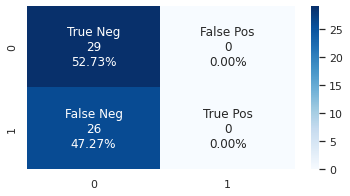

In [558]:
svmClfValF = 0.874766886154767
svmClfValAcc = 0.9111111111111112
svmClf = svm.SVC(C = 10, gamma = 1, kernel='rbf', probability=True)
svmClfAcc, svmClfF = userModel(svmClf)

## Logistic Regression

Accuracy is: 0.5818181818181818
f-measure: 0.43902439024390244
              precision    recall  f1-score   support

           0       0.57      0.79      0.67        29
           1       0.60      0.35      0.44        26

    accuracy                           0.58        55
   macro avg       0.59      0.57      0.55        55
weighted avg       0.59      0.58      0.56        55



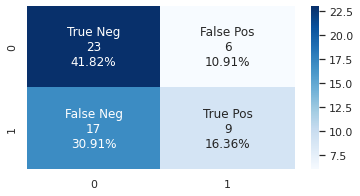

In [559]:
lrValF = 0.5824506902481977
lrValAcc = 0.6555555555555554
lr = LogisticRegression(penalty='l2', C=0.03359818286283781, solver='liblinear', fit_intercept=True)
lrAcc, lrF = userModel(lr)

## KNN

Accuracy is: 0.5818181818181818
f-measure: 0.30303030303030304
              precision    recall  f1-score   support

           0       0.56      0.93      0.70        29
           1       0.71      0.19      0.30        26

    accuracy                           0.58        55
   macro avg       0.64      0.56      0.50        55
weighted avg       0.63      0.58      0.51        55



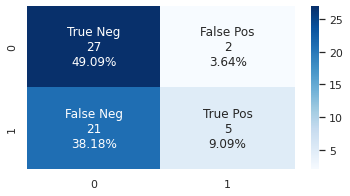

In [560]:
knnValF = 0.8882645083592648
knnValAcc = 0.8722222222222222
knn = KNeighborsClassifier(n_neighbors=20, weights='distance', algorithm='kd_tree', leaf_size=15, p=1)
knnAcc, knnF = userModel(knn)

## Decision Tree

Accuracy is: 0.509090909090909
f-measure: 0.18181818181818182
              precision    recall  f1-score   support

           0       0.52      0.86      0.65        29
           1       0.43      0.12      0.18        26

    accuracy                           0.51        55
   macro avg       0.47      0.49      0.42        55
weighted avg       0.48      0.51      0.43        55



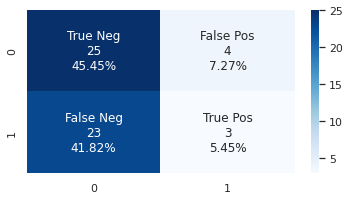

In [561]:
dtValF = 0.6520501046669936
dtValAcc = 0.7537037037037037
dt = DecisionTreeClassifier(criterion='gini', max_features='auto', max_depth=100, min_samples_split=5, min_samples_leaf=8, 
                            max_leaf_nodes=None, min_weight_fraction_leaf=0.1, splitter='best')
dtAcc, dtF = userModel(dt)

## Random Forest

Accuracy is: 0.5272727272727272
f-measure: 0.0
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        29
           1       0.00      0.00      0.00        26

    accuracy                           0.53        55
   macro avg       0.26      0.50      0.35        55
weighted avg       0.28      0.53      0.36        55



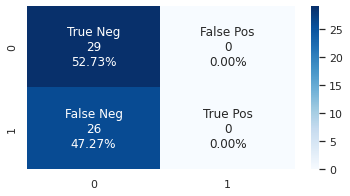

In [562]:
rfValF = 0.878269083469762
rfValAcc = 0.9185185185185186
rf = RandomForestClassifier(n_estimators=400, max_features='sqrt', max_depth=50, min_samples_split=5, min_samples_leaf=4, bootstrap=False)
rfAcc, rfF = userModel(rf)

## Boosting

Accuracy is: 0.5272727272727272
f-measure: 0.0
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        29
           1       0.00      0.00      0.00        26

    accuracy                           0.53        55
   macro avg       0.26      0.50      0.35        55
weighted avg       0.28      0.53      0.36        55



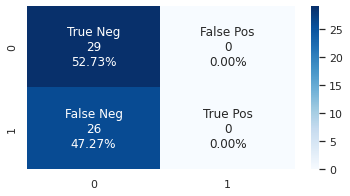

In [563]:
xgbClfValF = 0.8886776184684609
xgbClfValAcc = 0.9296296296296297
xgbClf = xgb.XGBClassifier(n_estimators=1800, max_depth=100, learning_rate=0.1, gamma=0.1, subsample=0.7, colsample_bytree=0.8,  
                           reg_alpha=1)
xgbClfAcc, xgbClfF = userModel(xgbClf)

## Plots

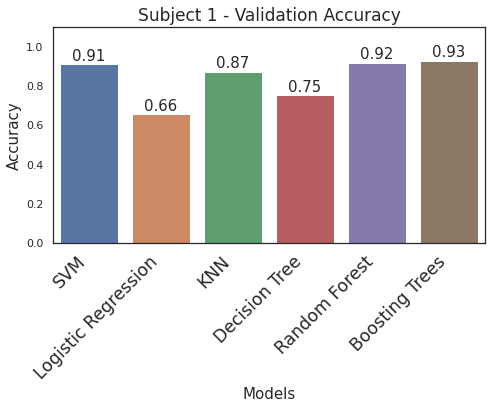

In [564]:
accuracies = [svmClfValAcc, lrValAcc, knnValAcc, dtValAcc, rfValAcc, xgbClfValAcc]
barPlot(accuracies, 'Subject 1 - Validation Accuracy', 'Accuracy')

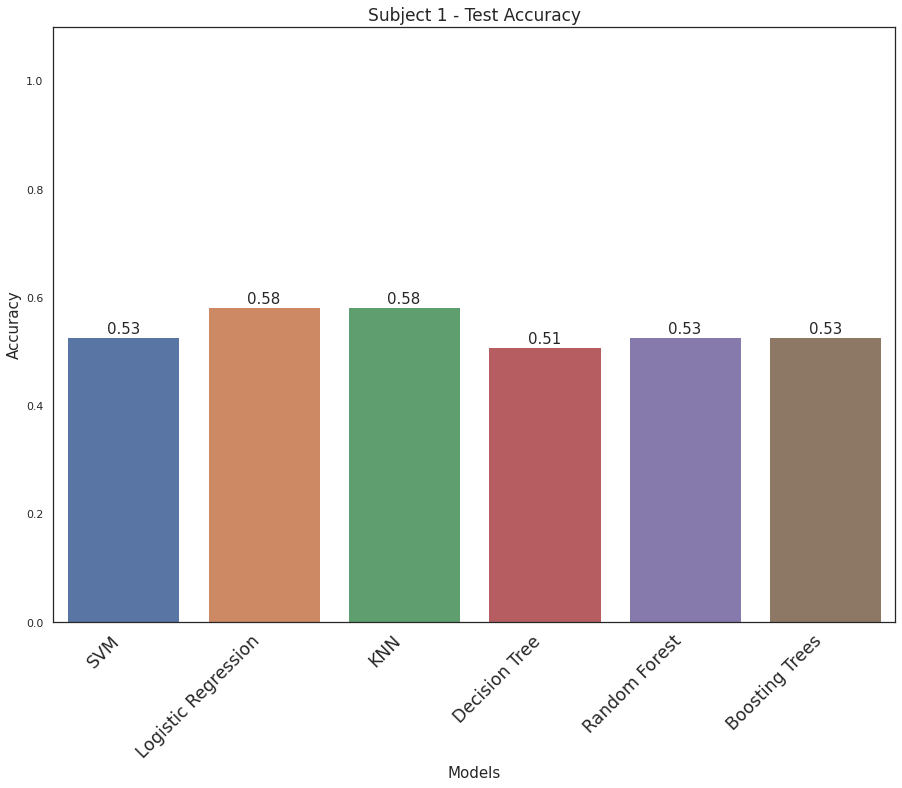

In [565]:
accuracies = [svmClfAcc, lrAcc, knnAcc, dtAcc, rfAcc, xgbClfAcc]
barPlot(accuracies, 'Subject 1 - Test Accuracy', 'Accuracy')

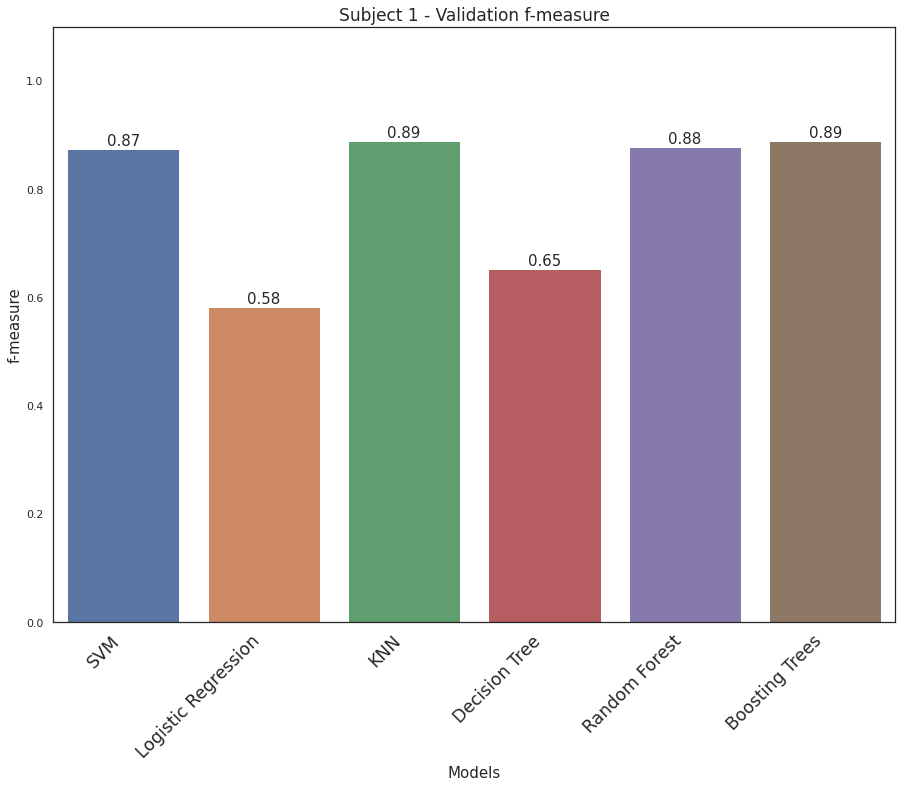

In [566]:
f_measure = [svmClfValF, lrValF, knnValF, dtValF, rfValF, xgbClfValF]
barPlot(f_measure, 'Subject 1 - Validation f-measure', 'f-measure')

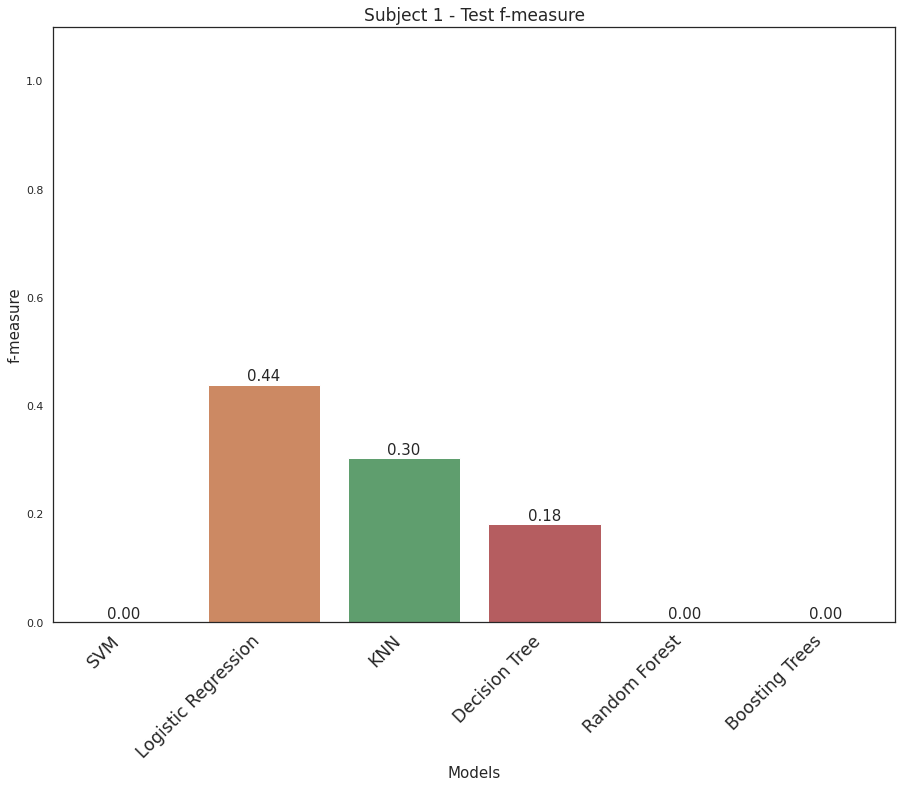

In [567]:
f_measure = [svmClfF, lrF, knnF, dtF, rfF, xgbClfF]
barPlot(f_measure, 'Subject 1 - Test f-measure', 'f-measure')

## Weighted Voting

### 3 WV

In [572]:
clf = [knn, xgbClf, rf]
weights = [knnValAcc, xgbClfValAcc, rfValAcc]
pred = WeightedVotingClassification(clf, weights)
s10_3wv = accuracy_score(df_testY, pred)
s10_3wv

0.5272727272727272

### 4 WV

In [573]:
clf = [knn, xgbClf, rf, svmClf]
weights = [knnValAcc, xgbClfValAcc, rfValAcc, svmClfValAcc]
pred = WeightedVotingClassification(clf, weights)
s10_4wv = accuracy_score(df_testY, pred)
s10_4wv

0.5272727272727272

### 5 WV

In [574]:
clf = [knn, xgbClf, rf, svmClf, dt]
weights = [knnValAcc, xgbClfValAcc, rfValAcc, svmClfValAcc, dtValAcc]
pred = WeightedVotingClassification(clf, weights)
s10_5wv = accuracy_score(df_testY, pred)
s10_5wv

0.5272727272727272

## Majority Voting

### 3 MV

In [575]:
clf = [knn, xgbClf, rf]
pred = MajorityVotingClassification(clf)
s10_3mv = accuracy_score(df_testY, pred)
s10_3mv

0.5272727272727272

### 4 MV

In [576]:
clf = [knn, xgbClf, rf, svmClf]
pred = MajorityVotingClassification(clf)
s10_4mv = accuracy_score(df_testY, pred)
s10_4mv

0.5272727272727272

### 5 MV

In [577]:
clf = [knn, xgbClf, rf, svmClf, dt]
pred = MajorityVotingClassification(clf)
s10_5mv = accuracy_score(df_testY, pred)
s10_5mv

0.5272727272727272

## Unanimous Voting

### 3 UV

In [579]:
clf = [knn, xgbClf, rf]
pred = UnanimousVotingClassification(clf)
s10_3uv = accuracy_score(df_testY, pred)
s10_3uv

0.5272727272727272

### 4 UV

In [580]:
clf = [knn, xgbClf, rf, svmClf]
pred = UnanimousVotingClassification(clf)
s10_4uv = accuracy_score(df_testY, pred)
s10_4uv

0.5272727272727272

### 5 UV

In [581]:
clf = [knn, xgbClf, rf, svmClf, dt]
pred = UnanimousVotingClassification(clf)
s10_5uv = accuracy_score(df_testY, pred)
s10_5uv

0.5272727272727272

# Observations & Results



## Weighted Voting Avg. Accuracy

### 3 WV

In [585]:
(s1_3wv+s2_3wv+s3_3wv+s4_3wv+s5_3wv+s6_3wv+s7_3wv+s8_3wv+s9_3wv+s10_3wv)/float(10)

0.866060606060606

### 4 WV

In [586]:
(s1_4wv+s2_4wv+s3_4wv+s4_4wv+s5_4wv+s6_4wv+s7_4wv+s8_4wv+s9_4wv+s10_4wv)/float(10)

0.8743939393939394

### 5 WV

In [587]:
(s1_5wv+s2_5wv+s3_5wv+s4_5wv+s5_5wv+s6_5wv+s7_5wv+s8_5wv+s9_5wv+s10_5wv)/float(10)

0.8677272727272728

## Majority Voting Avg. Accuracy

### 3 MV

In [590]:
(s1_3mv+s2_3mv+s3_3mv+s4_3mv+s5_3mv+s6_3mv+s7_3mv+s8_3mv+s9_3mv+s10_3mv)/float(10)

0.866060606060606

### 4 MV

In [589]:
(s1_4mv+s2_4mv+s3_4mv+s4_4mv+s5_4mv+s6_4mv+s7_4mv+s8_4mv+s9_4mv+s10_4mv)/float(10)

0.8843939393939394

### 5 MV

In [588]:
(s1_5mv+s2_5mv+s3_5mv+s4_5mv+s5_5mv+s6_5mv+s7_5mv+s8_5mv+s9_5mv+s10_5mv)/float(10)

0.8643939393939395

## Unanimous Voting Avg. Accuracy

### 3 UV

In [601]:
(s1_3uv+s2_3uv+s3_3uv+s4_3uv+s5_3uv+s6_3uv+s7_3uv+s8_3uv+s9_3uv+s10_3uv)/float(10)

0.8860606060606061

### 4 UV

In [602]:
(s1_4uv+s2_4uv+s3_4uv+s4_4uv+s5_4uv+s6_4uv+s7_4uv+s8_4uv+s9_4uv+s10_4uv)/float(10)

0.8427272727272728

### 5 UV

In [603]:
(s1_5uv+s2_5uv+s3_5uv+s4_5uv+s5_5uv+s6_5uv+s7_5uv+s8_5uv+s9_5uv+s10_5uv)/float(10)

0.6210606060606061

## Plots

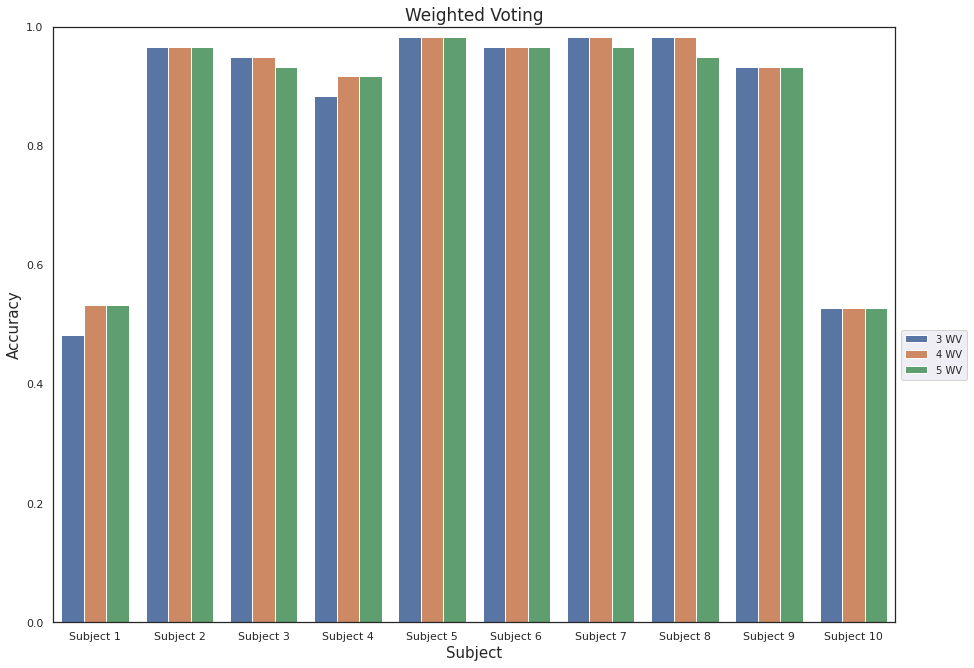

In [611]:
data = {
        'Accuracies': [s1_3wv,s2_3wv,s3_3wv,s4_3wv,s5_3wv,s6_3wv,s7_3wv,s8_3wv,s9_3wv,s10_3wv,s1_4wv,s2_4wv,s3_4wv,s4_4wv,s5_4wv,s6_4wv,s7_4wv,s8_4wv,s9_4wv,s10_4wv,s1_5wv,s2_5wv,s3_5wv,s4_5wv,s5_5wv,s6_5wv,s7_5wv,s8_5wv,s9_5wv,s10_5wv], 
        'Voting': ['3 WV','3 WV','3 WV','3 WV','3 WV','3 WV','3 WV','3 WV','3 WV','3 WV','4 WV','4 WV','4 WV','4 WV','4 WV','4 WV','4 WV','4 WV','4 WV','4 WV','5 WV','5 WV','5 WV','5 WV','5 WV','5 WV','5 WV','5 WV','5 WV','5 WV'],
        'Subject': ['Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10','Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10','Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10']
        }
df = pd.DataFrame(data)
masterBarPlot(df, 'Weighted Voting')

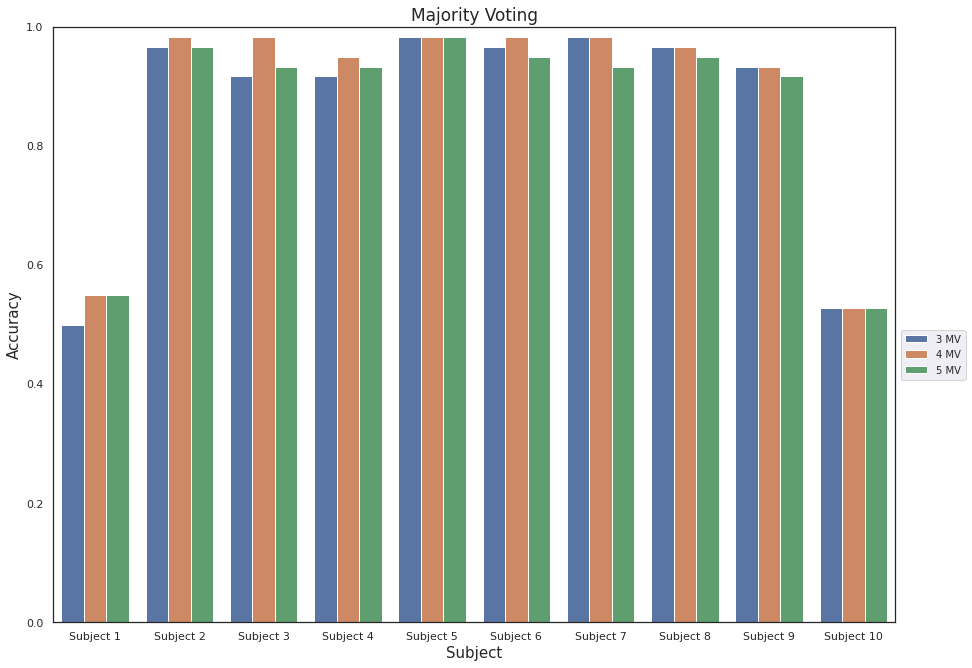

In [612]:
data = {
        'Accuracies': [s1_3mv,s2_3mv,s3_3mv,s4_3mv,s5_3mv,s6_3mv,s7_3mv,s8_3mv,s9_3mv,s10_3mv,s1_4mv,s2_4mv,s3_4mv,s4_4mv,s5_4mv,s6_4mv,s7_4mv,s8_4mv,s9_4mv,s10_4mv,s1_5mv,s2_5mv,s3_5mv,s4_5mv,s5_5mv,s6_5mv,s7_5mv,s8_5mv,s9_5mv,s10_5mv], 
        'Voting': ['3 MV','3 MV','3 MV','3 MV','3 MV','3 MV','3 MV','3 MV','3 MV','3 MV','4 MV','4 MV','4 MV','4 MV','4 MV','4 MV','4 MV','4 MV','4 MV','4 MV','5 MV','5 MV','5 MV','5 MV','5 MV','5 MV','5 MV','5 MV','5 MV','5 MV'],
        'Subject': ['Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10','Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10','Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10']
        }
df = pd.DataFrame(data)
masterBarPlot(df, 'Majority Voting')

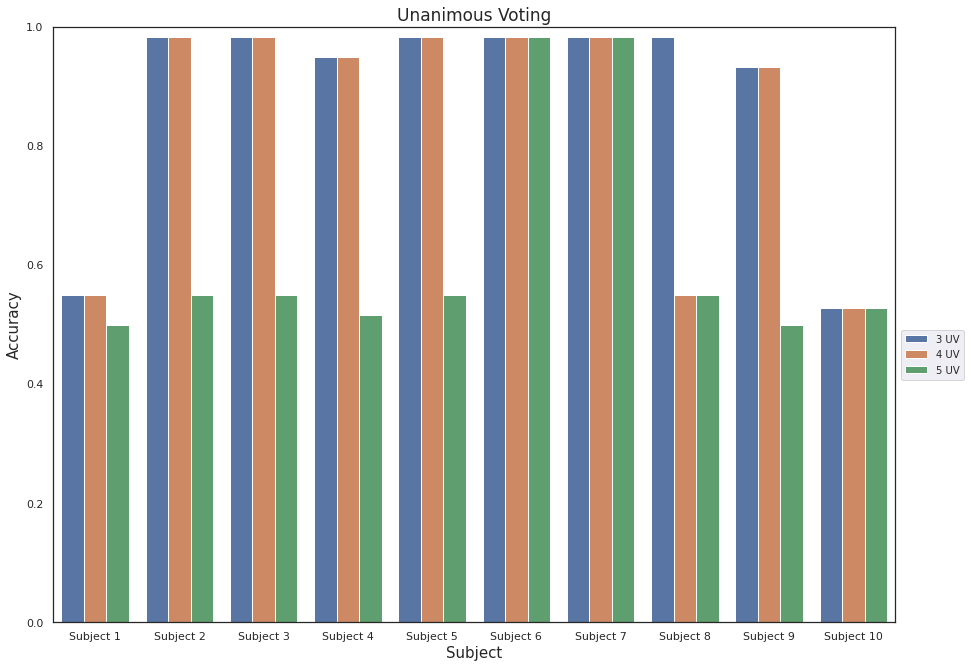

In [615]:
data = {
        'Accuracies': [s1_3uv,s2_3uv,s3_3uv,s4_3uv,s5_3uv,s6_3uv,s7_3uv,s8_3uv,s9_3uv,s10_3uv,s1_4uv,s2_4uv,s3_4uv,s4_4uv,s5_4uv,s6_4uv,s7_4uv,s8_4uv,s9_4uv,s10_4uv,s1_5uv,s2_5uv,s3_5uv,s4_5uv,s5_5uv,s6_5uv,s7_5uv,s8_5uv,s9_5uv,s10_5uv], 
        'Voting': ['3 UV','3 UV','3 UV','3 UV','3 UV','3 UV','3 UV','3 UV','3 UV','3 UV','4 UV','4 UV','4 UV','4 UV','4 UV','4 UV','4 UV','4 UV','4 UV','4 UV','5 UV','5 UV','5 UV','5 UV','5 UV','5 UV','5 UV','5 UV','5 UV','5 UV'],
        'Subject': ['Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10','Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10','Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10']
        }
df = pd.DataFrame(data)
masterBarPlot(df, 'Unanimous Voting')

In [616]:
wv_str = ['Weighted Voting' for i in range(10)]
mv_str = ['Majority Voting' for i in range(10)]
uv_str = ['Unanimous Voting' for i in range(10)]

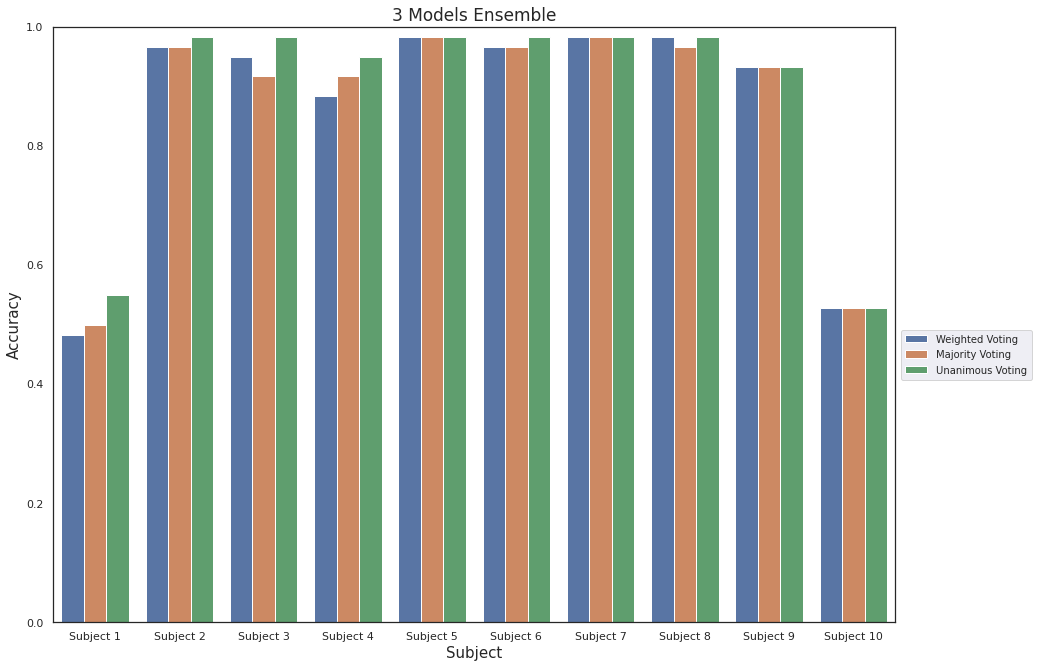

In [619]:
data = {
        'Accuracies': [s1_3wv,s2_3wv,s3_3wv,s4_3wv,s5_3wv,s6_3wv,s7_3wv,s8_3wv,s9_3wv,s10_3wv,s1_3mv,s2_3mv,s3_3mv,s4_3mv,s5_3mv,s6_3mv,s7_3mv,s8_3mv,s9_3mv,s10_3mv,s1_3uv,s2_3uv,s3_3uv,s4_3uv,s5_3uv,s6_3uv,s7_3uv,s8_3uv,s9_3uv,s10_3uv],
        'Voting': wv_str+mv_str+uv_str,
        'Subject': ['Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10','Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10','Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10']
        }
df = pd.DataFrame(data)
masterBarPlot(df, '3 Models Ensemble')

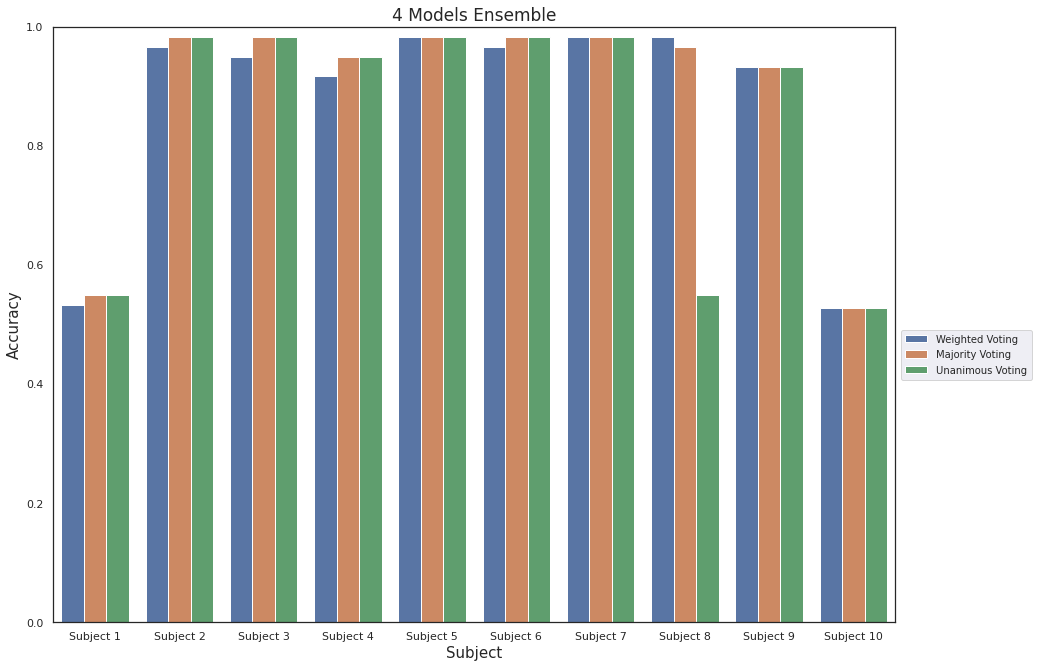

In [621]:
data = {
        'Accuracies': [s1_4wv,s2_4wv,s3_4wv,s4_4wv,s5_4wv,s6_4wv,s7_4wv,s8_4wv,s9_4wv,s10_4wv,s1_4mv,s2_4mv,s3_4mv,s4_4mv,s5_4mv,s6_4mv,s7_4mv,s8_4mv,s9_4mv,s10_4mv,s1_4uv,s2_4uv,s3_4uv,s4_4uv,s5_4uv,s6_4uv,s7_4uv,s8_4uv,s9_4uv,s10_4uv],
        'Voting': wv_str+mv_str+uv_str,
        'Subject': ['Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10','Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10','Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10']
        }
df = pd.DataFrame(data)
masterBarPlot(df, '4 Models Ensemble')

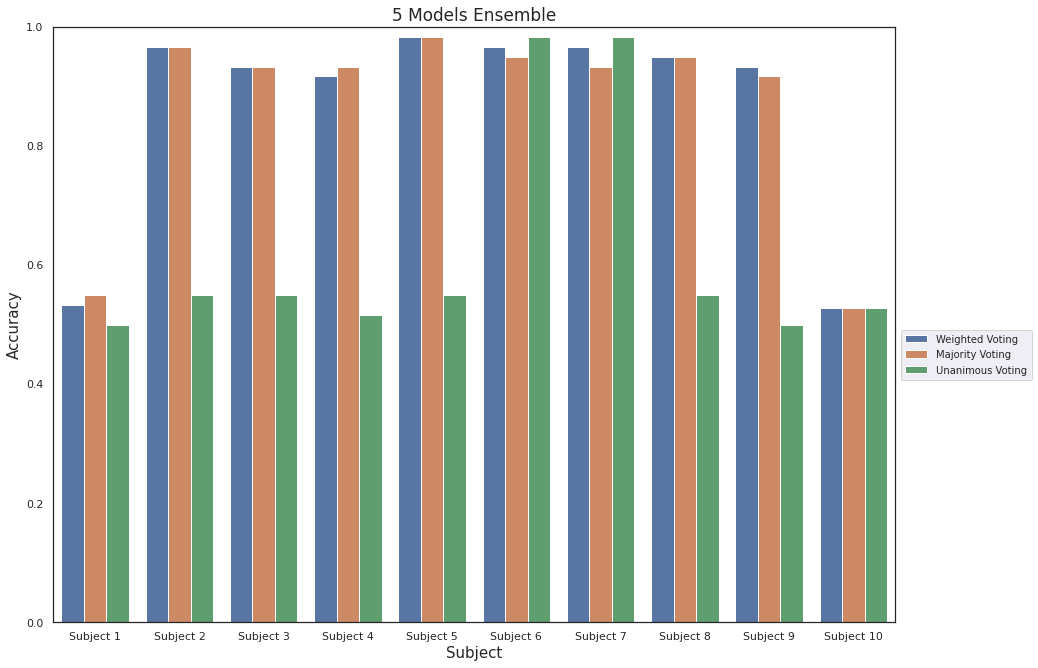

In [623]:
data = {
        'Accuracies': [s1_5wv,s2_5wv,s3_5wv,s4_5wv,s5_5wv,s6_5wv,s7_5wv,s8_5wv,s9_5wv,s10_5wv,s1_5mv,s2_5mv,s3_5mv,s4_5mv,s5_5mv,s6_5mv,s7_5mv,s8_5mv,s9_5mv,s10_5mv,s1_5uv,s2_5uv,s3_5uv,s4_5uv,s5_5uv,s6_5uv,s7_5uv,s8_5uv,s9_5uv,s10_5uv],
        'Voting': wv_str+mv_str+uv_str,
        'Subject': ['Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10','Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10','Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10']
        }
df = pd.DataFrame(data)
masterBarPlot(df, '5 Models Ensemble')